In [1]:
import pandas as pd
import numpy as np
import random
import math
from gravity_utils import *
import json
from datetime import timedelta as td
from datetime import time
from datetime import datetime
from matplotlib.pyplot import plot
from matplotlib import pyplot as plt

import sys
sys.path.insert(1, '../DRTsim')
import sim_utils, const
from sim_utils import Activity, Coord
from const import ActivityType
from shapely.geometry import Point
import shapely.wkt

# Data preparation

In [2]:
od_raw = pd.read_csv('data/OD_lolland_full_cleaned.csv')
# od_raw.drop(index=[5624],axis=0, inplace=True)
od_raw.head()

Unnamed: 0  OutputQueryRunID         StartStop DestinationsStop  \
0           0             20928    Nykøbing F St.      Nakskov St.   
1           1             20928    Nykøbing F St.       Maribo St.   
2           2             20928    Nykøbing F St.    Søllested St.   
3           3             20928  Øster Toreby St.      Nakskov St.   
4           4             20928  Øster Toreby St.       Maribo St.   

   StartKommune DestinationsKommune  RejseStartTidsbånd  AntalRejsende  \
0  Guldborgsund             Lolland                   0       3.410988   
1  Guldborgsund             Lolland                   0       1.306749   
2  Guldborgsund             Lolland                   0       0.125949   
3  Guldborgsund             Lolland                   0       0.043589   
4  Guldborgsund             Lolland                   0       0.023714   

   FraStopNr  TilStopNr  FraLTML2ZoneID  TilLTML2ZoneID  FraKomNr  TilKomNr  
0    8600824    8602623          376140          360240       376       360  
1    8600824    8602619          376140          360120       376       360  
2    8600824    8602645          376140          360210       376       360  
3    8602604    8602623          376210          360240       376       360  
4    8602604    8602619          376210          360120       376       360

In [3]:
stops = pd.read_csv('data/stops.txt')
stops = stops.set_index('stop_id')
stops.head()

stop_code                         stop_name  stop_desc   stop_lat  \
stop_id                                                                       
461011300       NaN  Dyrupgårds Alle (Odense Kommune)        NaN  55.354918   
8600718         NaN                      Vipperød St.        NaN  55.666828   
8600719         NaN                        Holbæk St.        NaN  55.715750   
8600716         NaN                        Hvalsø St.        NaN  55.595537   
8600717         NaN                       Tølløse St.        NaN  55.611893   

            stop_lon  location_type  parent_station  wheelchair_boarding  \
stop_id                                                                    
461011300  10.345035              0             NaN                  NaN   
8600718    11.738710              0             NaN                  NaN   
8600719    11.708598              0             NaN                  NaN   
8600716    11.859821              0             NaN                  NaN   
8600717    11.772803              0             NaN                  NaN   

           platform_code  
stop_id                   
461011300            NaN  
8600718              NaN  
8600719              NaN  
8600716              NaN  
8600717              NaN

In [4]:
def stop_coords(stop_id):
    lat = stops.loc[stop_id]['stop_lat']
    lon = stops.loc[stop_id]['stop_lon']
    latlon = (lat,lon)
    return latlon

In [5]:
class Population:
    def __init__(self):
        self.persons = []
    def to_JSON(self):
        return json.dumps(self, default=lambda o: _try(o), sort_keys=True, indent=4, separators=(',',':'))


class Person:
    def __init__(self):
        self.activities = []
        
#    def toJSON(self):
#        return json.dumps(self, default=lambda o: o.__dict__, 
#            sort_keys=True, indent=4)
        
#     def to_JSON(self):
#         return json.dumps(self, default=lambda o: _try(o), sort_keys=True, indent=4, separators=(',',':'))
        
def _try(o):
    try:
        if o.__class__ == ActivityType:
            raise Exception()
        return o.__dict__
    except:
        return str(o)

from enum import Enum
class ActivityType(Enum):
    HOME = 'HOME'
    WORK = 'WORK'

    def __str__(self):
        return self.name
    
class Activity(object):
    """Activity that is performed by a person.
    Person moves to a next activity after end_time is reached.

    Parameters
    ----------
    type_ : <ActivityType>
    coord : <Coord>
    start_time : <int> seconds from 00:00
    end_time : <int> seconds from 00:00
    """

    def __init__(self, type_, coord, start_time=None, end_time=None, zone=None):
        """docstring"""
        if start_time is None and end_time is None:
            raise Exception("Sanity check: both activity times are None")
        self.type = type_
        self.coord = coord
        self.start_time = start_time
        self.end_time = end_time
        self.zone = zone

    def __str__(self):
        return 'An ' + str(self.type) + ' at ' + str(self.coord)

In [6]:
def form_datetime(x):
    if type(x) in [np.float64, float, int, np.int64, np.int32]:
#         try:
#             x2 = math.trunc(x)
#         except TypeError:
#             x2 = x
        
        m = (x - math.trunc(x)) * 60
        s = math.trunc((m - math.trunc(m)) * 60)
        m = math.trunc(m)
        h = math.trunc(x)
        return datetime(year = 1970, month = 1 ,day = 1, hour = h, minute=m, second = s)
    elif type(x) == time:
        return datetime(year = 1970, month = 1 ,day = 1, hour = x.hour, minute=x.minute, second = x.second)
    
def form_td(x):
    if type(x) == np.float64:
        m = (x - math.trunc(x)) * 60
        s = math.trunc((m - math.trunc(m)) * 60)
        m = math.trunc(m)
        h = math.trunc(x)
        return td(hours = h, minutes=m, seconds = s)
    elif type(x) == time:
        return td(hours = x.hour, minutes=x.minute, seconds = x.second)

In [7]:
datetime(year = 1970, month = 1 ,day = 1, hour = 23) + td(minutes=90)

datetime.datetime(1970, 1, 2, 0, 30)

In [8]:
a = datetime(year = 1970, month = 1 ,day = 1, hour = 23)
b = td(minutes=90)
(a + b).date()

datetime.date(1970, 1, 2)

In [9]:
datetime(year = 1970, month = 1 ,day = 1, hour = 1).time() < time(1,30)

True

# Time probability distribution

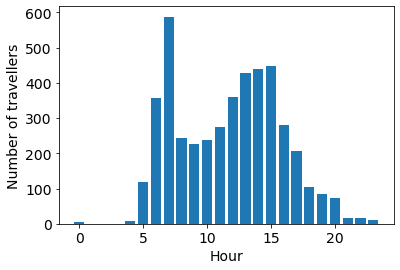

In [10]:
import matplotlib
font = {'size': 14}
matplotlib.rc('font', **font)
od_time_distr = od_raw.groupby('RejseStartTidsbånd')['AntalRejsende'].sum()
ax = plt.bar(od_time_distr.index,od_time_distr)
plt.xlabel('Hour')
plt.ylabel('Number of travellers')
plt.savefig('data/demand_distr.svg')

In [11]:
od_time_distr

RejseStartTidsbånd
0       4.933359
1       0.255949
4       8.664414
5     117.795972
6     356.114772
7     587.686223
8     243.018239
9     227.157782
10    236.972863
11    274.418550
12    358.583084
13    429.137330
14    439.133694
15    448.646509
16    281.128753
17    205.713572
18    103.239750
19     85.720891
20     73.994359
21     16.557322
22     15.794889
23     10.411483
Name: AntalRejsende, dtype: float64

In [12]:
x=np.arange(0,86400,1)
xp = od_time_distr.index.to_list()[0:2]+[2,3]+od_time_distr.index.to_list()[2:]+[24]
xp = [x*3600 + 1800 for x in xp]
fp = od_time_distr.to_list()[0:2]+[0,0]+od_time_distr.to_list()[2:]+[od_time_distr.to_list()[0]]
y = np.interp(x,xp,fp)
interp_time_distr = y

<BarContainer object of 86400 artists>

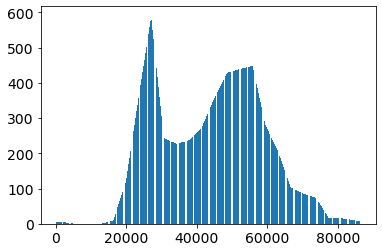

In [13]:
plt.bar(x,y)

In [14]:
# x=np.arange(0,86400,1)/3600
# y = np.interp(x,od_time_distr.index.to_list()+[24], od_time_distr.to_list()+[od_time_distr.to_list()[0]])
# interp_time_distr = y

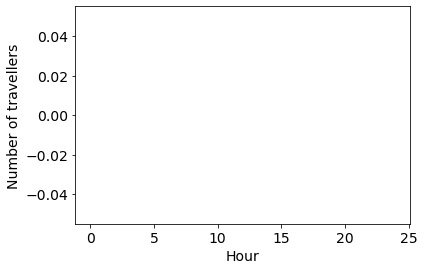

In [15]:
y2 = np.random.choice(x, 20000, p=y/sum(y))
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(x=y2, bins=np.arange(0,86400,86400/24/10)/3600, color='blue', alpha=0.7, rwidth=0.85, density=False)
plt.xlabel('Hour')
plt.ylabel('Number of travellers')
plt.savefig('data/demand_distr_smooth.svg')

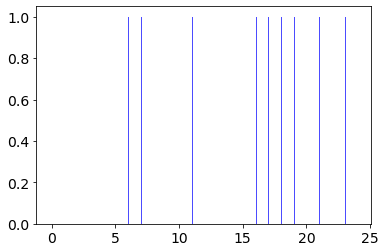

In [16]:
time_bin = 0
y3 = np.random.choice(x[time_bin*60*60:(time_bin+1)*60*60], 1000, p=y[time_bin*60*60:(time_bin+1)*60*60]/sum(y[time_bin*60*60:(time_bin+1)*60*60])) 
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(x=y3, bins=np.arange(0,86400,86400/24/10)/3600, color='blue', alpha=0.7, rwidth=0.85, density=False)

In [17]:
res = []
y = interp_time_distr
time_bin = 0
for _ in range(10000):
    x=np.arange(0,86400,1)
    sample = np.random.choice(x[time_bin*60*60:(time_bin+1)*60*60], p=y[time_bin*60*60:(time_bin+1)*60*60]/sum(y[time_bin*60*60:(time_bin+1)*60*60]))
    res.append(form_datetime(sample/3600).time())

In [18]:
def sample_time(time_bin, y):
    """Samples time in time_bin from distribution y
    Parameters
    ----------
    time_in : hour in 24 hours format
    y: distribution
    """
    x=np.arange(0,86400,1)
    sample = np.random.choice(x[time_bin*60*60:(time_bin+1)*60*60], p=y[time_bin*60*60:(time_bin+1)*60*60]/sum(y[time_bin*60*60:(time_bin+1)*60*60]))
    return form_datetime(sample/3600).time()

In [19]:
res = [sample_time(7, interp_time_distr) for _ in range(10000)]

(array([114.,  74.,  96.,  90., 104.,  97.,  90.,  93.,  94.,  87.,  87.,
         91., 111.,  90.,  88.,  91., 112.,  98., 119., 103., 106.,  91.,
        112.,  99., 100.,  99.,  99.,  90., 127.,  98., 117.,  91., 112.,
         84., 110., 109., 109., 129., 115., 101., 125., 111., 108.,  99.,
        116., 112.,  94., 115., 105.,  98., 115., 100., 106., 107., 107.,
        113., 106., 100., 119., 119.,  86., 127.,  95., 100., 116., 106.,
        104., 101., 100., 105., 102., 104.,  88.,  87., 103., 111.,  98.,
         93.,  99.,  78.,  91.,  86.,  87.,  84., 109.,  95.,  89., 130.,
         95.,  79.,  76., 104.,  83.,  79.,  80.,  78.,  81.,  83.,  97.,
         89.]),
 array([25200.  , 25235.99, 25271.98, 25307.97, 25343.96, 25379.95,
        25415.94, 25451.93, 25487.92, 25523.91, 25559.9 , 25595.89,
        25631.88, 25667.87, 25703.86, 25739.85, 25775.84, 25811.83,
        25847.82, 25883.81, 25919.8 , 25955.79, 25991.78, 26027.77,
        26063.76, 26099.75, 26135.74, 26171.73

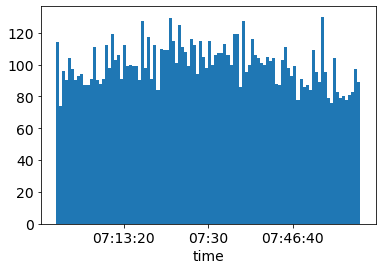

In [20]:
plt.hist(res, 100)

# Main cycle

In [217]:
population = Population()

def sample_time(time_bin, y):
    """Samples time in time_bin from distribution y
    Parameters
    ----------
    time_in : hour in 24 hours format
    y: distribution
    """
    x=np.arange(0,86400,1)
    sample = np.random.choice(x[time_bin*60*60:(time_bin+1)*60*60], p=y[time_bin*60*60:(time_bin+1)*60*60]/sum(y[time_bin*60*60:(time_bin+1)*60*60]))
    return form_datetime(sample/3600).time()

def form_activity(zone, act_type, coord=None, s_time=None, s_distr=None, e_time=None, e_distr=None, l_distr=None):
    """Combines an activity out of provided locations, type and times
    
    Parameters
    ----------
    coord: exact coordinate
    s_time, s_distr: starting time or time distribution.
    e_time, e_distr: end time or distribution.
    l_distr: distribution of activity duration. Added to start time
    """
    if coord is not None:
        location = coord
    else:
        coord = shapely.wkt.loads(buildings.sample(1).geometry.values[0])
        location = Coord(lat=coord.y, lon=coord.x)
    
    if s_time is not None:
        start_time = s_time
    else:
        start_time = sample_time(s_distr)
        
    if e_time is not None:
        end_time = e_time
    elif l_distr is not None:
        end_time_tmp = form_datetime(start_time) + form_td(sample_time(l_distr))
        if end_time_tmp.date() != form_datetime(start_time).date():
            end_time = time(23,59,59)
        else:
            end_time = end_time_tmp.time()
    else:
        end_time = sample_time(e_distr)
        
    return Activity(act_type,
                   location,
                   start_time=start_time,
                   end_time=end_time,
                   zone=zone
                  )

# exclude = [360240, 360210, ]



personnummer = 0
for _,row in od_raw.iterrows():
    try:
        origin_coord = stop_coords(row['FraStopNr'])
        destination_coord = stop_coords(row['TilStopNr'])
    except KeyError:
        continue
    origin_zone = row['FraLTML2ZoneID']
    destination_zone = row['TilLTML2ZoneID']
    persons = row['AntalRejsende']
    
    print("{} persons from {} to {}".format(persons, origin_coord, destination_coord))
    
    for i in range(0, int(persons) + int(random.random() < persons-int(persons))):
        new_pers = Person()
        new_pers.id = personnummer       
        personnummer +=1
        trip_time = sample_time(row['RejseStartTidsbånd'], interp_time_distr)
        act = form_activity(coord = origin_coord, 
                    zone = origin_zone,
                    act_type = ActivityType.WORK,
                    s_time = time(0),
                    e_time = trip_time
                    )
        new_pers.activities.append(act)
        
        act = form_activity(coord = destination_coord, 
                    zone = destination_zone, 
                    act_type = ActivityType.HOME,
                    s_time = new_pers.activities[-1].end_time,
                    e_time = time(23,59,59)
                    )
        new_pers.activities.append(act)
            
        population.persons.append(new_pers)
            

#        print(origin, destination, round(pop))
            
#        break
#    break
    

3.4109876155853303 persons from (54.767083977579006, 11.877372631171) to (54.833248872169, 11.138192792463)
1.30674870312214 persons from (54.767083977579006, 11.877372631171) to (54.776641266147, 11.501672983703001)
0.125948682427406 persons from (54.767083977579006, 11.877372631171) to (54.810959183161, 11.27016062816)
0.0435888059437275 persons from (54.759905110239, 11.836364419505) to (54.833248872169, 11.138192792463)
0.0237138886004686 persons from (54.759905110239, 11.836364419505) to (54.776641266147, 11.501672983703001)
0.0140808196738362 persons from (54.767083977579006, 11.877372631171) to (54.785122859397, 11.372628573919)
0.00536879757419229 persons from (54.767083977579006, 11.877372631171) to (54.829044870771, 11.21521502896)
0.00158121902495623 persons from (55.639089200424, 12.088546846093) to (54.924856167841995, 11.156316389459)
0.0013401006581261802 persons from (55.648869371621, 12.269580583877001) to (54.922780919152004, 11.156252180618)
0.14114336669445002 perso

0.00358155544381589 persons from (54.776641266147, 11.501672983703001) to (55.520685838114005, 12.208473938592)
0.00353419105522335 persons from (54.578365454818, 11.92701243141) to (54.776641266147, 11.501672983703001)
0.0035239318385720296 persons from (55.870982753497, 12.357044780934) to (54.810959183161, 11.27016062816)
0.0035026972182095107 persons from (54.833248872169, 11.138192792463) to (55.692498791312, 12.587785127349)
0.00348699744790792 persons from (54.776641266147, 11.501672983703001) to (55.69211524120401, 12.552155175979)
0.0034815676044672697 persons from (54.833248872169, 11.138192792463) to (54.667552226524, 11.732481805676999)
0.00345166609622538 persons from (54.833248872169, 11.138192792463) to (55.629055015949, 12.579388751037)
0.00343744060955942 persons from (55.766378617171, 12.19060787713) to (54.665172850507005, 11.33540335114)
0.00343512580730021 persons from (54.833248872169, 11.138192792463) to (55.658040350885, 12.353123542711)
0.00342761620413512 pers

4.27079004049301 persons from (54.833248872169, 11.138192792463) to (54.776641266147, 11.501672983703001)
2.47498947381973 persons from (54.796732641895, 11.635402511681) to (54.833248872169, 11.138192792463)
2.4570727944374102 persons from (54.796732641895, 11.635402511681) to (54.776641266147, 11.501672983703001)
1.85276904702187 persons from (54.767083977579006, 11.877372631171) to (54.696925135168, 11.391067650808)
1.67675219476223 persons from (54.810959183161, 11.27016062816) to (54.776641266147, 11.501672983703001)
1.39592928811908 persons from (54.767083977579006, 11.877372631171) to (54.776641266147, 11.501672983703001)
1.10669842362404 persons from (54.767083977579006, 11.877372631171) to (54.659255000264, 11.350879746442)
1.08836782723665 persons from (54.767083977579006, 11.877372631171) to (54.694126433950004, 11.387116278859999)
1.00875858962536 persons from (54.767083977579006, 11.877372631171) to (54.696523423075, 11.393201335964001)
0.9080324359238148 persons from (54.

0.13820682838559198 persons from (54.785122859397, 11.372628573919) to (55.231244192243004, 11.767053283819001)
0.134180322289467 persons from (54.659040610333, 11.354511233248001) to (54.776438613051006, 11.501473855515)
0.134130446705967 persons from (54.785122859397, 11.372628573919) to (54.776641266147, 11.501672983703001)
0.132638990879059 persons from (54.774916783401004, 11.485424881183) to (54.767083977579006, 11.877372631171)
0.131214782595634 persons from (54.776641266147, 11.501672983703001) to (55.715361927801, 12.559491548475)
0.13017962872982 persons from (54.835581519872996, 11.476911726965001) to (55.01258374163201, 11.900147187295001)
0.129100605845451 persons from (54.833008735511996, 11.139067684884) to (54.760710036500996, 11.134568040732999)
0.12879429757595098 persons from (54.888073638205, 12.034114400383999) to (54.776641266147, 11.501672983703001)
0.128752131015062 persons from (54.659448417925994, 11.350177644073998) to (54.694216649825, 11.387556120255999)
0.

0.0528515106998384 persons from (54.833248872169, 11.138192792463) to (55.381395248466, 10.366689757532999)
0.0527884820476174 persons from (54.776641266147, 11.501672983703001) to (55.407308046911, 11.34899519987)
0.0527122095227242 persons from (54.709025039527, 11.474777654291) to (54.695634244025, 11.731048291386001)
0.0526505094021559 persons from (54.665172850507005, 11.33540335114) to (54.796732641895, 11.635402511681)
0.05206762533634901 persons from (54.709025039527, 11.474777654291) to (55.253130713162, 11.780252613448)
0.0519352778792381 persons from (54.696925135168, 11.391067650808) to (54.759905110239, 11.836364419505)
0.0517196916043758 persons from (54.709025039527, 11.474777654291) to (54.842298084019006, 11.123485480924002)
0.0517151635140181 persons from (54.669076864933004, 11.337597174295) to (54.668997957171, 11.364812032474001)
0.0514201615005732 persons from (54.670898733968, 11.366907859718001) to (54.774916783401004, 11.485424881183)
0.0513693373650312 persons

0.0340637117624283 persons from (54.776641266147, 11.501672983703001) to (54.907805072681, 11.214250719598999)
0.0340408235788345 persons from (54.828615253553, 11.137932259479001) to (54.760352970161, 11.185890709666)
0.0339982146397233 persons from (54.810959183161, 11.27016062816) to (54.776746455918996, 11.490886792629)
0.0338122062385082 persons from (54.709551128152, 11.469701793355998) to (55.231244192243004, 11.767053283819001)
0.0336697930470109 persons from (54.785122859397, 11.372628573919) to (55.692498791312, 12.587785127349)
0.0335381962358952 persons from (54.833248872169, 11.138192792463) to (56.033618307517, 12.614168774899001)
0.0333669073879719 persons from (54.714772634099, 11.458280498946) to (54.714710098758005, 11.458261186112)
0.0332575896754861 persons from (54.688464142267, 11.383866549340999) to (54.776840834085, 11.491981195322001)
0.0331862084567547 persons from (54.711403466979, 11.45818526348) to (55.01258374163201, 11.900147187295001)
0.0331273409537971 

0.0234614480286837 persons from (54.659040610333, 11.354511233248001) to (54.776840834085, 11.491981195322001)
0.0233025751076639 persons from (54.669236194879, 11.361816987364) to (54.688464142267, 11.383866549340999)
0.0232985694892704 persons from (54.721033917669004, 11.430426293074) to (54.776438613051006, 11.501473855515)
0.0231803294736892 persons from (54.833248872169, 11.138192792463) to (55.417711435815, 12.137253930376)
0.0231803294736892 persons from (54.833248872169, 11.138192792463) to (55.373226496183, 12.076073045464002)
0.0231781862676144 persons from (54.694216649825, 11.387556120255999) to (54.776840834085, 11.491981195322001)
0.0231563439592719 persons from (54.711403466979, 11.45818526348) to (54.767083977579006, 11.877372631171)
0.0231072749011219 persons from (54.810959183161, 11.27016062816) to (54.718583503900994, 11.459644818569)
0.0231027789413929 persons from (54.810959183161, 11.27016062816) to (55.692498791312, 12.587785127349)
0.0230748802423477 persons f

0.0149446558207273 persons from (54.833248872169, 11.138192792463) to (55.478783479334, 12.165901053110002)
0.014941391767933998 persons from (54.774631322376, 11.484878652707) to (54.776553486278, 11.495462573126)
0.0148888153489679 persons from (54.833248872169, 11.138192792463) to (54.661947822955, 11.358943853862)
0.0147676523774862 persons from (54.831720759346, 11.483277967693) to (54.776303940283, 11.501465541187999)
0.0146431922912598 persons from (54.785122859397, 11.372628573919) to (55.638051335129994, 12.582928389951)
0.014597293920815 persons from (54.833248872169, 11.138192792463) to (54.819140491878, 12.052030999158001)
0.0145838437601924 persons from (54.77643572924401, 11.501613639374002) to (55.685244572735, 12.588632158835)
0.0145695894025266 persons from (54.661957405748, 11.358913395427999) to (54.77643572924401, 11.501613639374002)
0.0145490234717727 persons from (54.714710098758005, 11.458261186112) to (54.767083977579006, 11.877372631171)
0.014517375966533998 pe

0.009857765398919579 persons from (54.776641266147, 11.501672983703001) to (55.395357266920996, 12.118073845777)
0.00984552525915205 persons from (54.669076864933004, 11.337597174295) to (54.694216649825, 11.387556120255999)
0.00983787328004837 persons from (54.776641266147, 11.501672983703001) to (55.629855325049, 12.602094527521999)
0.009818274527788159 persons from (54.776641266147, 11.501672983703001) to (55.253130713162, 11.780252613448)
0.00975478976033628 persons from (54.668997957171, 11.364812032474001) to (54.758390798147, 11.855675236549)
0.00975392665714026 persons from (54.810959183161, 11.27016062816) to (55.636763058865, 12.268746072787001)
0.00974818714894354 persons from (54.685802092119, 11.383012233549) to (54.694216649825, 11.387556120255999)
0.00973055779468268 persons from (54.833248872169, 11.138192792463) to (55.62843449593, 12.578775863594998)
0.009719139896333221 persons from (54.833248872169, 11.138192792463) to (55.639125896184, 12.069905450971)
0.0097096443

0.0066102058626711395 persons from (54.776553486278, 11.495462573126) to (54.71033265099, 11.464874194314001)
0.0066080614924430795 persons from (54.696925135168, 11.391067650808) to (54.709917943803994, 11.413583545032001)
0.00660036550834775 persons from (54.688464142267, 11.383866549340999) to (56.01960123994701, 12.572209422771001)
0.00657762866467237 persons from (54.828615253553, 11.137932259479001) to (54.775752217862994, 11.018319037108)
0.00651011243462563 persons from (54.694216649825, 11.387556120255999) to (54.838026287628004, 11.362416146997)
0.00650057755410671 persons from (54.774631322376, 11.484878652707) to (54.75427144103, 11.448131432993)
0.00648538453970104 persons from (54.776641266147, 11.501672983703001) to (55.674997034951, 12.599260983759999)
0.00645989365875721 persons from (54.833248872169, 11.138192792463) to (54.709560106652, 11.469702339259)
0.0064477133564651 persons from (54.98229706557299, 12.283517256345) to (54.833248872169, 11.138192792463)
0.006416

0.00455827638506889 persons from (54.776641266147, 11.501672983703001) to (54.757835239538004, 11.883696176858)
0.004554735030978921 persons from (54.759905110239, 11.836364419505) to (54.849129120775004, 11.234666956542)
0.0045541906729340605 persons from (54.767083977579006, 11.877372631171) to (54.831948397910004, 11.483136221909001)
0.00453267025295645 persons from (54.776641266147, 11.501672983703001) to (55.683842758555, 12.571044165371001)
0.00453245500102639 persons from (54.696925135168, 11.391067650808) to (54.759173434745996, 11.877324109796)
0.00452356319874525 persons from (54.776641266147, 11.501672983703001) to (55.693156970207006, 12.43284211764)
0.00452109146863222 persons from (54.699960092228004, 11.395794060612) to (54.77583696367601, 11.877154457888999)
0.00450973445549607 persons from (54.694216649825, 11.387556120255999) to (54.759718764972, 11.891432437097)
0.00449589500203729 persons from (54.709025039527, 11.474777654291) to (54.77583696367601, 11.877154457888

0.00262726983055472 persons from (54.709025039527, 11.474777654291) to (54.697400805598, 11.627202239273)
0.0026234476827085 persons from (54.776641266147, 11.501672983703001) to (55.681668795871, 12.523102168664)
0.0026199657004326604 persons from (54.709025039527, 11.474777654291) to (54.665108201829995, 11.335492689042)
0.0026113300118595396 persons from (54.833248872169, 11.138192792463) to (55.676527566092, 12.455092661698)
0.0026108694728463893 persons from (54.773688918216, 11.872196384057) to (54.776641266147, 11.501672983703001)
0.00260727829299867 persons from (54.801080262104996, 11.993132059767001) to (54.776641266147, 11.501672983703001)
0.00260027823969722 persons from (54.912019252608005, 9.779156855179) to (54.669112184561996, 11.337630222958)
0.0025918672326952197 persons from (54.833248872169, 11.138192792463) to (54.685739543247, 11.382993051262)
0.00256979884579778 persons from (54.77643572924401, 11.501613639374002) to (54.707756824632995, 11.489728519017)
0.002560

0.00149011297617108 persons from (54.709025039527, 11.474777654291) to (54.750544235589, 11.468793844147001)
0.0014831627486273599 persons from (54.776641266147, 11.501672983703001) to (56.150440925290006, 10.204759714423)
0.00147763325367123 persons from (55.673059428552, 12.565557817097002) to (54.696925135168, 11.391067650808)
0.00147556187584996 persons from (54.709025039527, 11.474777654291) to (54.711403466979, 11.45818526348)
0.00147469213698059 persons from (54.776641266147, 11.501672983703001) to (55.728088253319996, 12.524497711261)
0.00147425197064877 persons from (54.833248872169, 11.138192792463) to (55.681223102593, 12.531719409916)
0.0014644202310591901 persons from (54.718583503900994, 11.459644818569) to (55.584204405688, 11.654741243963)
0.0014616793487221 persons from (54.776641266147, 11.501672983703001) to (54.695650450043004, 11.731126987174001)
0.00146154605317861 persons from (54.75443607711001, 11.448436682794002) to (54.77643572924401, 11.501613639374002)
0.00

2.79751348495483 persons from (54.916166295206004, 11.359331444714) to (54.833104707642, 11.139742347994002)
2.57607500255108 persons from (54.876194704875005, 11.089274489856) to (54.833045136199, 11.139552334830999)
2.49095726013184 persons from (54.833248872169, 11.138192792463) to (54.796732641895, 11.635402511681)
1.99569815397263 persons from (54.696925135168, 11.391067650808) to (54.776438613051006, 11.501473855515)
1.92245030403137 persons from (54.878009042673995, 11.023536767063) to (54.91060619673, 11.216900855634)
1.89403195679188 persons from (54.776641266147, 11.501672983703001) to (55.673059428552, 12.565557817097002)
1.77347780950367 persons from (54.829044870771, 11.21521502896) to (54.776641266147, 11.501672983703001)
1.67181565612555 persons from (54.776641266147, 11.501672983703001) to (54.810959183161, 11.27016062816)
1.6571948528289802 persons from (54.810709126677, 11.271033727944) to (54.778971532121, 11.298553480609)
1.49069286137819 persons from (54.6969251351

0.4429228529334071 persons from (54.773887903324, 11.034676657551) to (54.82839765976, 11.141097031626)
0.44083478301763496 persons from (54.916166295206004, 11.359331444714) to (54.767083977579006, 11.877372631171)
0.440463125705719 persons from (55.231244192243004, 11.767053283819001) to (54.833248872169, 11.138192792463)
0.4379773810505871 persons from (54.688464142267, 11.383866549340999) to (54.767083977579006, 11.877372631171)
0.4368762597441671 persons from (54.75918361139399, 11.896524568174) to (54.696523423075, 11.393201335964001)
0.434072054922581 persons from (54.833248872169, 11.138192792463) to (55.673059428552, 12.565557817097002)
0.430589288473129 persons from (54.907805072681, 11.214250719598999) to (54.833104707642, 11.139742347994002)
0.428567941300571 persons from (54.833248872169, 11.138192792463) to (54.77583696367601, 11.877154457888999)
0.42170868813991497 persons from (54.837181234146996, 11.366571791395) to (54.833155643586, 11.139402463476)
0.418073356151581 

0.224683195352554 persons from (54.776641266147, 11.501672983703001) to (55.683451957752, 12.571804282859)
0.22410971671342805 persons from (54.924491993562, 11.191241442806001) to (54.833045136199, 11.139552334830999)
0.222018294036388 persons from (54.776641266147, 11.501672983703001) to (55.329365215638, 11.961037514965)
0.221761483699083 persons from (54.714710098758005, 11.458261186112) to (54.77643572924401, 11.501613639374002)
0.21963995322585106 persons from (54.696925135168, 11.391067650808) to (54.776840834085, 11.491981195322001)
0.21917283535003695 persons from (54.775875097667, 11.010379432567001) to (54.82839765976, 11.141097031626)
0.21864153444767 persons from (54.806194654439004, 11.431600025829999) to (54.776016974779, 11.485694530679)
0.21835921052843305 persons from (54.710333281935995, 11.464843180915999) to (54.767083977579006, 11.877372631171)
0.217557854950428 persons from (54.810959183161, 11.27016062816) to (55.231244192243004, 11.767053283819001)
0.2149434648

0.13279179856181098 persons from (54.758472188390996, 11.895820796169) to (54.833248872169, 11.138192792463)
0.132668958511204 persons from (54.776641266147, 11.501672983703001) to (55.682394445712994, 12.371584384544)
0.13266621530056 persons from (54.699288825150006, 11.595503795072998) to (54.77643572924401, 11.501613639374002)
0.132396772503853 persons from (54.702021331374, 11.551515149467) to (54.766446220975, 11.876969719243)
0.13161366619169698 persons from (54.711403466979, 11.45818526348) to (54.767083977579006, 11.877372631171)
0.130541857331991 persons from (54.836338977892, 11.372876624168999) to (54.832151459905994, 11.157536788710999)
0.130283946171403 persons from (54.71033265099, 11.464874194314001) to (54.665108201829995, 11.335492689042)
0.12967967800796 persons from (54.696523423075, 11.393201335964001) to (54.77583696367601, 11.877154457888999)
0.12966379523277302 persons from (54.767083977579006, 11.877372631171) to (54.668987670243, 11.365338763373)
0.12917657359

0.0882290219888091 persons from (54.916166295206004, 11.359331444714) to (54.776016974779, 11.485694530679)
0.0880617573857307 persons from (54.839793008716, 11.355230221814) to (54.833008735511996, 11.139067684884)
0.0879249200224876 persons from (54.750472724153994, 11.468773949928) to (54.714772634099, 11.458280498946)
0.0876188557595015 persons from (54.659040610333, 11.354511233248001) to (54.694216649825, 11.387556120255999)
0.0874336063861847 persons from (54.908524312427, 11.214243409517) to (54.767083977579006, 11.877372631171)
0.0874254703521729 persons from (54.898505303332996, 11.124462246839002) to (54.907805072681, 11.214250719598999)
0.0873932763934135 persons from (54.800816109614, 11.425457359662001) to (54.836744349648, 11.365004392291999)
0.0872856080532074 persons from (54.835351896408994, 11.481990325284) to (54.833248872169, 11.138192792463)
0.0870805755257607 persons from (54.861124055251, 11.423747762437) to (54.776303940283, 11.501465541187999)
0.08667308837175

0.0671102106571198 persons from (54.709025039527, 11.474777654291) to (55.253130713162, 11.780252613448)
0.066948689520359 persons from (54.712032569812, 11.457307276955) to (55.673059428552, 12.565557817097002)
0.0668651964515448 persons from (54.655078914476, 11.354375089382) to (54.833248872169, 11.138192792463)
0.0668120845220983 persons from (54.655078914476, 11.354375089382) to (54.752904325613, 11.788591037673)
0.0666493689641356 persons from (54.69461782182999, 11.393647831510998) to (54.669112184561996, 11.337630222958)
0.0664387145079672 persons from (54.669076864933004, 11.337597174295) to (54.767083977579006, 11.877372631171)
0.0663793701678514 persons from (54.758238944051, 11.855633447446001) to (54.833248872169, 11.138192792463)
0.0662913066335022 persons from (54.829044870771, 11.21521502896) to (54.665108201829995, 11.335492689042)
0.0662651062011719 persons from (54.907682161657, 11.320518214045999) to (54.833104707642, 11.139742347994002)
0.0661114752292633 persons f

0.0537139326334 persons from (54.833008735511996, 11.139067684884) to (54.766166463682005, 11.155391682653999)
0.0536821782588959 persons from (54.833155643586, 11.139402463476) to (54.837246620396, 11.368288780745)
0.0535758528858423 persons from (54.776641266147, 11.501672983703001) to (54.773992567749005, 11.765175397679)
0.0534043535590172 persons from (54.67242585454701, 11.373852581615) to (55.01258374163201, 11.900147187295001)
0.0533445118926466 persons from (54.776746455918996, 11.490886792629) to (54.696523423075, 11.393201335964001)
0.0533242067322135 persons from (54.839776480915006, 11.355618637108) to (54.767083977579006, 11.877372631171)
0.0532959699630737 persons from (54.688464142267, 11.383866549340999) to (54.766274533163994, 11.514357277332001)
0.0532863095868379 persons from (54.709025039527, 11.474777654291) to (54.75820944452, 11.846568163264001)
0.0531602390110493 persons from (54.709025039527, 11.474777654291) to (54.757861382506, 11.835335324265001)
0.05311089

0.0472110584378242 persons from (54.67242585454701, 11.373852581615) to (54.694617515523994, 11.393663333034999)
0.0471609621308744 persons from (54.696523423075, 11.393201335964001) to (54.833248872169, 11.138192792463)
0.0471500717103481 persons from (54.829044870771, 11.21521502896) to (55.703525498364, 12.424421290117)
0.0471315486356616 persons from (54.833248872169, 11.138192792463) to (55.629442640199, 12.649165939903)
0.047012374503537985 persons from (54.696523423075, 11.393201335964001) to (54.707083796508996, 11.476072133349)
0.0469487942755222 persons from (54.83205260172, 11.141804388538999) to (54.835099280717, 11.150982279884)
0.0468447152525187 persons from (54.67242585454701, 11.373852581615) to (54.844128691099, 11.157303757606002)
0.046738788485527004 persons from (54.776641266147, 11.501672983703001) to (54.833155643586, 11.139402463476)
0.0467225876636803 persons from (54.776438613051006, 11.501473855515) to (54.720910704012006, 11.430294679651999)
0.04670448601245

0.0419604312628508 persons from (55.648869371621, 12.269580583877001) to (54.833248872169, 11.138192792463)
0.0419481629505754 persons from (54.767083977579006, 11.877372631171) to (54.685739543247, 11.382993051262)
0.0419473499059677 persons from (54.767083977579006, 11.877372631171) to (54.655078914476, 11.354375089382)
0.0419114478863776 persons from (54.669236194879, 11.361816987364) to (54.688464142267, 11.383866549340999)
0.0418685879558325 persons from (54.659040610333, 11.354511233248001) to (54.668997957171, 11.364812032474001)
0.0418557599186897 persons from (54.838026287628004, 11.362416146997) to (54.849129120775004, 11.234666956542)
0.0418161326088011 persons from (54.776746455918996, 11.490886792629) to (54.75427144103, 11.448131432993)
0.0417911047115922 persons from (54.810959183161, 11.27016062816) to (54.758390798147, 11.855675236549)
0.0417867191135883 persons from (54.847041410045996, 11.121585034136) to (54.90698668424599, 11.094145400420999)
0.0417819917201996 per

0.0362123474478722 persons from (54.757895368891, 11.883436175071001) to (54.776641266147, 11.501672983703001)
0.0360749624669552 persons from (54.833248872169, 11.138192792463) to (54.711395660361994, 11.923208320320999)
0.0360554978251457 persons from (54.810959183161, 11.27016062816) to (54.807874921216005, 11.425351223359002)
0.0360165424644947 persons from (54.923424810734, 11.283842308864) to (54.699638074333, 11.395712989155)
0.0359949581325054 persons from (54.842298084019006, 11.123485480924002) to (54.840977292422, 11.139831933378)
0.0359239098615944 persons from (54.665172850507005, 11.33540335114) to (54.776641266147, 11.501672983703001)
0.0359228029847145 persons from (54.914518917771, 11.222171540488999) to (54.834233403154, 11.115867634872)
0.0358924721367657 persons from (54.916166295206004, 11.359331444714) to (54.776840834085, 11.491981195322001)
0.0358819961547852 persons from (54.669112184561996, 11.337630222958) to (54.821470245253, 12.056629026131)
0.0358495814725

0.0303462103474885 persons from (54.776438613051006, 11.501473855515) to (54.655078914476, 11.354375089382)
0.0303219635970891 persons from (54.865253389927, 11.171865531415) to (54.833104707642, 11.139742347994002)
0.0302801616489887 persons from (54.832971301778, 11.138131401145001) to (54.840889303878, 11.11562412717)
0.0302723236382008 persons from (54.710333281935995, 11.464843180915999) to (54.659163911613, 11.354642413782)
0.0302125280722976 persons from (54.810959183161, 11.27016062816) to (55.639089200424, 12.088546846093)
0.0301893050782382 persons from (54.660673537777, 11.34494519309) to (54.833248872169, 11.138192792463)
0.0301479585468769 persons from (54.785122859397, 11.372628573919) to (55.438393811337, 11.786376030030999)
0.0300964056514204 persons from (54.776553486278, 11.495462573126) to (54.659255000264, 11.350879746442)
0.0300667528063059 persons from (54.668997957171, 11.364812032474001) to (54.696925135168, 11.391067650808)
0.0300486013293266 persons from (54.6

0.0277776420116425 persons from (54.766446220975, 11.876969719243) to (54.77643572924401, 11.501613639374002)
0.027744289021939 persons from (55.248323308050004, 11.786463204093002) to (54.833248872169, 11.138192792463)
0.0276825421024114 persons from (54.694617515523994, 11.393663333034999) to (54.774916783401004, 11.485424881183)
0.0276546906679869 persons from (54.833008735511996, 11.139067684884) to (54.77912167757, 11.297271217272)
0.0276434568222612 persons from (54.796732641895, 11.635402511681) to (54.711403466979, 11.45818526348)
0.027567595243454 persons from (54.833248872169, 11.138192792463) to (55.20558840425, 11.770176918366001)
0.0275333039462566 persons from (54.709917943803994, 11.413583545032001) to (54.90698668424599, 11.094145400420999)
0.0275090243667364 persons from (54.824918446109, 11.149771436094) to (55.478783479334, 12.165901053110002)
0.0274318605661392 persons from (54.844128691099, 11.157303757606002) to (54.806194654439004, 11.431600025829999)
0.027419870

0.0226222593337297 persons from (54.667552226524, 11.732481805676999) to (54.833248872169, 11.138192792463)
0.0225639003328979 persons from (54.709025039527, 11.474777654291) to (54.766734540141, 11.876943540520001)
0.0225557636003941 persons from (54.833248872169, 11.138192792463) to (54.763137629212, 11.856445015894)
0.0225486792623997 persons from (54.833248872169, 11.138192792463) to (55.694008418327996, 12.565619960933)
0.0224872045218945 persons from (54.776301056491, 11.501605324584) to (54.807874921216005, 11.425351223359002)
0.0224705543369055 persons from (54.809188617398995, 11.478657869304) to (54.767083977579006, 11.877372631171)
0.0224009077064693 persons from (54.881512389528, 11.358443540361) to (54.833248872169, 11.138192792463)
0.0223743040114641 persons from (54.923424810734, 11.283842308864) to (54.767083977579006, 11.877372631171)
0.0223742176312953 persons from (54.699960092228004, 11.395794060612) to (54.776641266147, 11.501672983703001)
0.0223542042076588 person

0.0194526389241219 persons from (55.231244192243004, 11.767053283819001) to (54.840977292422, 11.139831933378)
0.0193560477346182 persons from (54.839435472001, 11.124752377284) to (54.776641266147, 11.501672983703001)
0.0193454958498478 persons from (55.639089200424, 12.088546846093) to (54.696925135168, 11.391067650808)
0.0193412136286497 persons from (54.776301056491, 11.501605324584) to (54.849056995811004, 11.234678546687)
0.0193169917911291 persons from (54.776091029825004, 11.485590215829001) to (54.835508193538, 11.477421175105)
0.019281521672383 persons from (54.697850146826, 11.628038421267) to (54.709025039527, 11.474777654291)
0.0192752759903669 persons from (54.747303747275, 11.330976578952) to (54.980529848839, 12.278370044342001)
0.019273909041658 persons from (54.833248872169, 11.138192792463) to (54.659163911613, 11.354642413782)
0.0191802578046918 persons from (54.776641266147, 11.501672983703001) to (55.010899948976004, 11.908160360806)
0.0191302429884672 persons fro

0.0168097112327814 persons from (54.842089627258, 11.123583557577) to (54.804188231160005, 11.44019406248)
0.0167963219573721 persons from (54.696925135168, 11.391067650808) to (54.709917943803994, 11.413583545032001)
0.0167723399354145 persons from (54.776840834085, 11.491981195322001) to (54.767083977579006, 11.877372631171)
0.0167674815747887 persons from (54.776641266147, 11.501672983703001) to (55.69211524120401, 12.552155175979)
0.0167543289717287 persons from (54.833248872169, 11.138192792463) to (55.692498791312, 12.587785127349)
0.0167370531708002 persons from (54.709025039527, 11.474777654291) to (55.663996839913, 12.514449793547001)
0.0167336559388787 persons from (54.659448417925994, 11.350177644073998) to (54.696523423075, 11.393201335964001)
0.0167310871183872 persons from (54.828615253553, 11.137932259479001) to (54.812747987792996, 11.017315432814)
0.016718540340662 persons from (54.709025039527, 11.474777654291) to (54.776553486278, 11.495462573126)
0.0166919524781406 

0.0150042334571481 persons from (54.670898733968, 11.366907859718001) to (54.696925135168, 11.391067650808)
0.0149765741080046 persons from (54.833248872169, 11.138192792463) to (55.664819641674995, 12.458641179704001)
0.0149760679341853 persons from (54.839980095089, 11.351144844405) to (54.833248872169, 11.138192792463)
0.0149611115921289 persons from (54.776553486278, 11.495462573126) to (54.69461782182999, 11.393647831510998)
0.0149475457146764 persons from (54.832971301778, 11.138131401145001) to (54.833249901691, 11.129955354210999)
0.014934366568923003 persons from (54.718583503900994, 11.459644818569) to (54.699638074333, 11.395712989155)
0.0148979055229574 persons from (54.776438613051006, 11.501473855515) to (54.692863011297, 11.386452361508999)
0.0148756373673677 persons from (54.776641266147, 11.501672983703001) to (54.701389361760995, 11.759548351471)
0.0148735605180264 persons from (54.762974156913, 11.847726815635) to (54.833248872169, 11.138192792463)
0.0148590508615598

0.0132581787183881 persons from (54.759670154699, 11.206713615217) to (55.231244192243004, 11.767053283819001)
0.0132480675820261 persons from (54.767083977579006, 11.877372631171) to (54.709560106652, 11.469702339259)
0.0132460361346602 persons from (54.776091029825004, 11.485590215829001) to (54.811844069418, 11.411129587166)
0.0132268520537764 persons from (54.776438613051006, 11.501473855515) to (54.776553486278, 11.495462573126)
0.0132185354596004 persons from (54.696925135168, 11.391067650808) to (54.665108201829995, 11.335492689042)
0.0132128428667784 persons from (54.835351896408994, 11.481990325284) to (54.759718764972, 11.891432437097)
0.0132040689932182 persons from (54.776553486278, 11.495462573126) to (54.835351896408994, 11.481990325284)
0.0131958844140172 persons from (54.837246620396, 11.368288780745) to (55.680935071330005, 12.444803575299002)
0.0131734804017469 persons from (54.833248872169, 11.138192792463) to (55.430356624896, 11.559401692625)
0.0131627218797803 per

0.012035645544528998 persons from (54.776641266147, 11.501672983703001) to (54.695650450043004, 11.731126987174001)
0.0120332334190607 persons from (54.866280759462995, 11.398107272802) to (54.767083977579006, 11.877372631171)
0.0120311798527837 persons from (54.833248872169, 11.138192792463) to (56.033618307517, 12.614168774899001)
0.0119811473414302 persons from (54.776303940283, 11.501465541187999) to (54.91674263217399, 11.23716511582)
0.0119741708040237 persons from (54.659255000264, 11.350879746442) to (55.66482783277, 12.559511164526)
0.0119600808247924 persons from (54.833155643586, 11.139402463476) to (54.670898733968, 11.366907859718001)
0.0119524877518415 persons from (54.776641266147, 11.501672983703001) to (54.763137629212, 11.856445015894)
0.0119475240353495 persons from (54.774631322376, 11.484878652707) to (54.659163911613, 11.354642413782)
0.0119448946788907 persons from (54.758390798147, 11.855675236549) to (54.833248872169, 11.138192792463)
0.0119396173395216 persons

0.0104109549429268 persons from (54.776641266147, 11.501672983703001) to (55.494621241771, 11.97251476312)
0.010405755136162 persons from (54.833248872169, 11.138192792463) to (55.478783479334, 12.165901053110002)
0.0104000688297674 persons from (54.699960092228004, 11.395794060612) to (54.924579499269, 11.268268922054)
0.0103947492316365 persons from (54.776641266147, 11.501672983703001) to (54.781818206846, 11.861853274224998)
0.010359148029238 persons from (54.833248872169, 11.138192792463) to (55.403863537578, 11.387144663757999)
0.0103588653728366 persons from (54.914518917771, 11.222171540488999) to (54.810959183161, 11.27016062816)
0.0103328790282831 persons from (54.696925135168, 11.391067650808) to (55.407308046911, 11.34899519987)
0.0103273740969598 persons from (54.767083977579006, 11.877372631171) to (54.924579499269, 11.268268922054)
0.0103237656876445 persons from (54.776641266147, 11.501672983703001) to (54.755457888100004, 11.890273565469)
0.0103235989809036 persons fro

0.00875961966812611 persons from (54.840731917155, 11.457040914175) to (54.776016974779, 11.485694530679)
0.008710796129889791 persons from (54.833248872169, 11.138192792463) to (55.388894783076, 10.329595727723)
0.00870260456576943 persons from (54.819033195738, 12.052007331547001) to (54.833248872169, 11.138192792463)
0.00867869332432747 persons from (55.01258374163201, 11.900147187295001) to (54.741152639755, 11.357595738634)
0.008646214264445009 persons from (54.767083977579006, 11.877372631171) to (54.806282316289995, 11.431262916889999)
0.00864334974903613 persons from (54.760738209635, 11.8765490141) to (54.776641266147, 11.501672983703001)
0.00864173658192158 persons from (54.707083796508996, 11.476072133349) to (55.663422372255, 12.585216893318)
0.0086401104927063 persons from (54.776438613051006, 11.501473855515) to (54.833248872169, 11.138192792463)
0.008621943881735209 persons from (54.661957405748, 11.358913395427999) to (54.661947822955, 11.358943853862)
0.008615469560027

0.00738644087687135 persons from (55.648869371621, 12.269580583877001) to (54.776641266147, 11.501672983703001)
0.00736887054517865 persons from (55.715749854582995, 11.708598367335) to (54.776641266147, 11.501672983703001)
0.00734796561300755 persons from (54.668997957171, 11.364812032474001) to (54.670898733968, 11.366907859718001)
0.007334565278142691 persons from (54.835351896408994, 11.481990325284) to (54.780299509306005, 11.86182374001)
0.007326251827180391 persons from (54.709917943803994, 11.413583545032001) to (54.774916783401004, 11.485424881183)
0.00730936462059617 persons from (54.764522117, 11.404427513633001) to (54.833008735511996, 11.139067684884)
0.0072972602210938904 persons from (54.812747987792996, 11.017315432814) to (54.81168200946, 11.017635816688001)
0.0072878294158726905 persons from (54.776301056491, 11.501605324584) to (54.804503052983996, 11.438843597528999)
0.0072732325643301 persons from (55.290852379939004, 11.561689753408) to (54.810959183161, 11.270160

0.00660589570179582 persons from (54.832151459905994, 11.157536788710999) to (54.830884756801005, 11.140746000739)
0.00659760623238981 persons from (54.776641266147, 11.501672983703001) to (55.828949824362, 12.532825077685)
0.00658807856962085 persons from (54.776641266147, 11.501672983703001) to (55.852903753136, 12.563021639091)
0.006577561609447 persons from (55.313893166450995, 10.802582718726999) to (54.776641266147, 11.501672983703001)
0.006570750847458839 persons from (54.82687450054, 11.139288203187) to (54.75443607711001, 11.448436682794002)
0.00656828749924898 persons from (54.776301056491, 11.501605324584) to (54.774430729871, 11.529791963352)
0.0065496321767568606 persons from (54.778254732098, 11.861990346219999) to (54.709025039527, 11.474777654291)
0.00652967020869255 persons from (54.692863011297, 11.386452361508999) to (54.655078914476, 11.354375089382)
0.00651983544230461 persons from (54.696931666273, 11.391192198575) to (54.754886821274006, 11.373796765336001)
0.006

0.0057616736739873895 persons from (54.660663658515, 11.344991143103002) to (54.833248872169, 11.138192792463)
0.00574016710743308 persons from (54.746129659123, 11.361909618371) to (54.672435441118004, 11.37382211903)
0.00572474300861359 persons from (54.695319038237, 11.396374061545998) to (54.709025039527, 11.474777654291)
0.00571477180346847 persons from (54.709025039527, 11.474777654291) to (54.811844069418, 11.411129587166)
0.005696564912796021 persons from (54.849129120775004, 11.234666956542) to (55.693944916087, 12.548898573399)
0.00567719154059887 persons from (54.776746455918996, 11.490886792629) to (54.711351966583, 11.458508196966)
0.00567667651921511 persons from (54.796732641895, 11.635402511681) to (54.916166295206004, 11.359331444714)
0.00567315053194761 persons from (54.660663658515, 11.344991143103002) to (54.655078914476, 11.354375089382)
0.00565920316148549 persons from (54.776641266147, 11.501672983703001) to (55.763070336454, 12.583649167866001)
0.005636690650135

0.00482290191575885 persons from (54.776553486278, 11.495462573126) to (54.858900202811, 11.426621803389)
0.00481070298701525 persons from (54.776553486278, 11.495462573126) to (54.863884796546, 11.401533880976)
0.00480057951062918 persons from (54.659040610333, 11.354511233248001) to (54.659163911613, 11.354642413782)
0.00479468610137701 persons from (54.833248872169, 11.138192792463) to (55.677309772666995, 12.579232203443)
0.004794650711119179 persons from (54.709917943803994, 11.413583545032001) to (55.639089200424, 12.088546846093)
0.0047916130861267395 persons from (55.438393811337, 11.786376030030999) to (54.696925135168, 11.391067650808)
0.00478666974231601 persons from (54.776441817093, 11.501318540086999) to (54.746094044921996, 11.361892005650999)
0.00478011090308428 persons from (55.692498791312, 12.587785127349) to (54.833248872169, 11.138192792463)
0.00477902311831713 persons from (54.778254732098, 11.861990346219999) to (54.774631322376, 11.484878652707)
0.00477802008390

0.00424604304134846 persons from (54.776301056491, 11.501605324584) to (54.836338977892, 11.372876624168999)
0.004231003578752279 persons from (55.457547371159, 12.186332889024) to (54.833248872169, 11.138192792463)
0.0042260168120265 persons from (54.804188231160005, 11.44019406248) to (54.776492903956004, 11.495785419645)
0.00422114413231611 persons from (54.776441817093, 11.501318540086999) to (54.761888720733005, 11.325130663512)
0.004217208828777071 persons from (54.659255000264, 11.350879746442) to (54.694617515523994, 11.393663333034999)
0.00420906115323305 persons from (54.861134276952, 11.423686041278) to (54.872520341842005, 11.382531439551)
0.00418739952147007 persons from (54.694216649825, 11.387556120255999) to (54.694126433950004, 11.387116278859999)
0.0041873981244862106 persons from (54.659163911613, 11.354642413782) to (54.696925135168, 11.391067650808)
0.00418715504929423 persons from (55.903487812805004, 12.502056992157) to (54.694126433950004, 11.387116278859999)
0.

0.00362335937097669 persons from (54.833248872169, 11.138192792463) to (55.673300012116, 12.589669499165002)
0.00361813430208713 persons from (54.776641266147, 11.501672983703001) to (55.131758972525, 10.50888874583)
0.00361325778067112 persons from (54.766236779776, 11.154975675686) to (55.692498791312, 12.587785127349)
0.003609897335991261 persons from (54.830884756801005, 11.140746000739) to (54.838645495162, 11.114914910436001)
0.00360895972698927 persons from (55.231244192243004, 11.767053283819001) to (54.835351896408994, 11.481990325284)
0.0035754097625613204 persons from (55.963741861203005, 12.533407838632) to (54.714772634099, 11.458280498946)
0.00357513991184533 persons from (54.76559804981, 11.872929025769999) to (54.776641266147, 11.501672983703001)
0.00356502644717693 persons from (54.833248872169, 11.138192792463) to (54.578365454818, 11.92701243141)
0.00354293314740062 persons from (54.899254391134996, 11.332043803473) to (54.776016974779, 11.485694530679)
0.00354101601

0.0029101953841745892 persons from (54.669076864933004, 11.337597174295) to (54.668987670243, 11.365338763373)
0.00290806312114 persons from (54.727293127391995, 11.509689862471001) to (54.730202093953, 11.528463524945)
0.00290397298522294 persons from (54.775011130425995, 11.216256711493001) to (54.776492903956004, 11.495785419645)
0.00290120719000697 persons from (54.837246620396, 11.368288780745) to (54.837181234146996, 11.366571791395)
0.0028946548700332607 persons from (54.83888326652001, 11.149984388141998) to (54.833249901691, 11.129955354210999)
0.0028921163175255104 persons from (55.254461261820005, 11.334254491145) to (54.810959183161, 11.27016062816)
0.00289084878750145 persons from (54.711403466979, 11.45818526348) to (55.963741861203005, 12.533407838632)
0.00287787150591612 persons from (54.669112184561996, 11.337630222958) to (55.66210832242601, 12.616178784310998)
0.0028735010419040897 persons from (54.833248872169, 11.138192792463) to (55.681223102593, 12.531719409916)


0.0023357272148132303 persons from (55.679791008693, 12.563195009543) to (54.833248872169, 11.138192792463)
0.00231645232997835 persons from (55.438393811337, 11.786376030030999) to (54.776641266147, 11.501672983703001)
0.0023144376464188108 persons from (54.659255000264, 11.350879746442) to (54.696523423075, 11.393201335964001)
0.00231200968846679 persons from (55.683451957752, 12.571804282859) to (54.785122859397, 11.372628573919)
0.0023075437638908607 persons from (54.767083977579006, 11.877372631171) to (54.871381842794, 11.387405477809999)
0.00229367963038385 persons from (54.878787991157, 11.173513393764999) to (54.833120922202, 11.149506728413)
0.00227751978673041 persons from (54.810959183161, 11.27016062816) to (55.688290717935, 12.52796405295)
0.00227423710748553 persons from (54.655078914476, 11.354375089382) to (54.858900202811, 11.426621803389)
0.00227081915363669 persons from (55.01258374163201, 11.900147187295001) to (54.696925135168, 11.391067650808)
0.0022661960683763 

0.0018143533961847398 persons from (55.641802935091, 12.264508473142) to (54.810959183161, 11.27016062816)
0.00181103276554495 persons from (55.01258374163201, 11.900147187295001) to (54.659255000264, 11.350879746442)
0.00180787581484765 persons from (54.833248872169, 11.138192792463) to (55.705616051687, 12.590612704809999)
0.0017999381525442 persons from (55.436134019365, 12.153991715144) to (54.833248872169, 11.138192792463)
0.0017973700305447 persons from (55.001828487571004, 11.904406817644999) to (54.75427144103, 11.448131432993)
0.0017968351021409 persons from (54.833248872169, 11.138192792463) to (55.723962458860996, 12.356084075982)
0.0017884448170661898 persons from (54.998081750309, 11.893001140574) to (54.696925135168, 11.391067650808)
0.0017877072095871 persons from (54.766236779776, 11.154975675686) to (54.827072618005, 11.139267542491)
0.00178244570270181 persons from (54.696925135168, 11.391067650808) to (54.835351896408994, 11.481990325284)
0.00178210833109915 persons 

0.0012374228099361099 persons from (55.629442640199, 12.649165939903) to (54.773887903324, 11.034676657551)
0.0012332118349149804 persons from (54.659448417925994, 11.350177644073998) to (54.656448536267995, 11.356981605494001)
0.0012314815539866699 persons from (54.849129120775004, 11.234666956542) to (55.679184740345, 12.585228066864)
0.0012273363536223802 persons from (54.668987670243, 11.365338763373) to (54.661947822955, 11.358943853862)
0.0012234527384862304 persons from (54.832502075560996, 11.133637561228001) to (54.856252601291, 11.118625344784)
0.00122046936303377 persons from (54.832502075560996, 11.133637561228001) to (54.861816553022, 11.115535675697998)
0.0012199941556900696 persons from (55.629442640199, 12.649165939903) to (54.775752217862994, 11.018319037108)
0.00121918576769531 persons from (54.776641266147, 11.501672983703001) to (55.504500505253, 11.287744868394)
0.00121602835133672 persons from (54.702011373845, 11.551561093139998) to (54.710333281935995, 11.464843

9.05371658504009 persons from (54.796732641895, 11.635402511681) to (54.776641266147, 11.501672983703001)
7.407778978347781 persons from (54.91060619673, 11.216900855634) to (54.833104707642, 11.139742347994002)
5.952030256390572 persons from (54.833104707642, 11.139742347994002) to (54.907805072681, 11.214250719598999)
5.22787994146347 persons from (54.767083977579006, 11.877372631171) to (54.776641266147, 11.501672983703001)
5.2247446924448 persons from (54.916166295206004, 11.359331444714) to (54.833104707642, 11.139742347994002)
5.202851176261901 persons from (54.914518917771, 11.222171540488999) to (54.833104707642, 11.139742347994002)
5.19519260525703 persons from (54.835023495605, 11.374870678796999) to (54.800765345292994, 11.425298714463)
4.27845393121243 persons from (54.810959183161, 11.27016062816) to (54.776641266147, 11.501672983703001)
3.41317318379879 persons from (54.833248872169, 11.138192792463) to (54.796732641895, 11.635402511681)
3.37025274336338 persons from (54.

0.873956229537725 persons from (54.668997957171, 11.364812032474001) to (54.694216649825, 11.387556120255999)
0.8509914912283421 persons from (54.699960092228004, 11.395794060612) to (54.833248872169, 11.138192792463)
0.850032866001129 persons from (54.711403466979, 11.45818526348) to (54.844128691099, 11.157303757606002)
0.8389315903186801 persons from (54.922780919152004, 11.156252180618) to (54.907805072681, 11.214250719598999)
0.8353179842233659 persons from (54.916166295206004, 11.359331444714) to (54.776303940283, 11.501465541187999)
0.8325768858194351 persons from (54.694617515523994, 11.393663333034999) to (54.776438613051006, 11.501473855515)
0.8315360546112059 persons from (54.916010542706005, 11.352066195757999) to (54.91060619673, 11.216900855634)
0.829515367746353 persons from (54.847386949945005, 11.225769282791) to (54.838532174427, 11.153563292832)
0.826566338539124 persons from (54.906588424831, 11.202062409699) to (54.907805072681, 11.214250719598999)
0.82620757818222

0.4200112223625179 persons from (54.84252994390099, 11.138948443193) to (54.911629612045004, 11.216972727421)
0.419708415865898 persons from (54.776300729199, 11.501185420099) to (54.771894616157, 11.527254537569)
0.419256404042244 persons from (54.836338977892, 11.372876624168999) to (54.833008735511996, 11.139067684884)
0.418777465820313 persons from (54.706632840554, 11.521904201122) to (54.766446220975, 11.876969719243)
0.418022029101849 persons from (54.660673537777, 11.34494519309) to (54.776438613051006, 11.501473855515)
0.41659376770258 persons from (54.776641266147, 11.501672983703001) to (54.778608810057, 11.861844272874)
0.415641099214554 persons from (54.810959183161, 11.27016062816) to (54.796732641895, 11.635402511681)
0.41407039761543296 persons from (54.741164637509, 11.357441063399) to (54.697551056495, 11.388046906035)
0.41037715971469896 persons from (54.688464142267, 11.383866549340999) to (54.776840834085, 11.491981195322001)
0.409544937312603 persons from (54.6965

0.331594862043858 persons from (54.697551056495, 11.388046906035) to (54.83305431942, 11.140051117139)
0.32973164319992104 persons from (54.913414518941, 11.346859182921) to (54.833104707642, 11.139742347994002)
0.329345967620611 persons from (54.694216649825, 11.387556120255999) to (54.776840834085, 11.491981195322001)
0.32815952599048603 persons from (54.670898733968, 11.366907859718001) to (54.696523423075, 11.393201335964001)
0.328030146658421 persons from (54.776303940283, 11.501465541187999) to (54.835351896408994, 11.481990325284)
0.327740877866745 persons from (54.766236779776, 11.154975675686) to (54.82839765976, 11.141097031626)
0.32657787017524204 persons from (54.71033265099, 11.464874194314001) to (54.696939421298, 11.391254736635)
0.326576028950512 persons from (54.659448417925994, 11.350177644073998) to (54.696925135168, 11.391067650808)
0.325616355985403 persons from (54.91060619673, 11.216900855634) to (54.848898780464, 11.160502598521)
0.324875981546938 persons from (

0.26892802119255105 persons from (54.800816109614, 11.425457359662001) to (54.776840834085, 11.491981195322001)
0.26873139664530804 persons from (54.836161837468005, 11.113009696783) to (54.834472261906, 11.147304998657)
0.26870412006974204 persons from (54.91674263217399, 11.23716511582) to (54.848898780464, 11.160502598521)
0.268076390028 persons from (54.824918446109, 11.149771436094) to (54.834472261906, 11.147304998657)
0.267122883349657 persons from (54.833248872169, 11.138192792463) to (54.773992567749005, 11.765175397679)
0.266561239957809 persons from (54.833045136199, 11.139552334830999) to (54.874035851845, 11.092498490441)
0.266403950750828 persons from (54.806282316289995, 11.431262916889999) to (54.844235348114005, 11.157371754298)
0.26628027111291896 persons from (54.758238944051, 11.855633447446001) to (54.776641266147, 11.501672983703001)
0.265709489583969 persons from (54.928799232211, 11.192646335046) to (54.833045136199, 11.139552334830999)
0.262433975934982 persons

0.158269837498665 persons from (54.77646233655501, 11.501195396181) to (54.871381842794, 11.387405477809999)
0.15799365844577598 persons from (54.907682161657, 11.320518214045999) to (54.91060619673, 11.216900855634)
0.157439172267914 persons from (54.916166295206004, 11.359331444714) to (54.833120922202, 11.149506728413)
0.157266982831061 persons from (54.668997957171, 11.364812032474001) to (54.696925135168, 11.391067650808)
0.156726464629173 persons from (54.91439548177, 11.222039909085) to (54.916166295206004, 11.359331444714)
0.156668987125158 persons from (54.669076864933004, 11.337597174295) to (54.668997957171, 11.364812032474001)
0.15651555359363598 persons from (54.916166295206004, 11.359331444714) to (54.846161437053006, 11.444581497288999)
0.15619286894798298 persons from (54.878787991157, 11.173513393764999) to (54.838532174427, 11.153563292832)
0.15601115114986902 persons from (54.694126433950004, 11.387116278859999) to (54.670898733968, 11.366907859718001)
0.156008839607

0.121053583920002 persons from (54.874069502352, 11.092110548678) to (54.840073436398, 11.129894316959)
0.120576426386833 persons from (54.840181317768, 11.146222080883998) to (54.830884756801005, 11.140746000739)
0.119299273937941 persons from (54.741152639755, 11.357595738634) to (54.776840834085, 11.491981195322001)
0.119250720366836 persons from (54.694617515523994, 11.393663333034999) to (54.776840834085, 11.491981195322001)
0.118794105947018 persons from (54.760404998571, 11.19197122142) to (54.82839765976, 11.141097031626)
0.118679992854595 persons from (54.67242585454701, 11.373852581615) to (54.845630836095, 11.159268706396)
0.118012860417366 persons from (54.718583503900994, 11.459644818569) to (54.833248872169, 11.138192792463)
0.117829620838165 persons from (54.841581406780996, 11.135643073018) to (54.836161837468005, 11.113009696783)
0.117739090695977 persons from (54.7777805586, 11.036784766855) to (54.767083977579006, 11.877372631171)
0.117662267759442 persons from (54.7

0.0948754828423262 persons from (54.832971301778, 11.138131401145001) to (54.835099280717, 11.150982279884)
0.0948550999164581 persons from (54.833008735511996, 11.139067684884) to (54.776441817093, 11.501318540086999)
0.0948286382481456 persons from (54.696925135168, 11.391067650808) to (54.709917943803994, 11.413583545032001)
0.0941604655236006 persons from (54.688464142267, 11.383866549340999) to (54.767083977579006, 11.877372631171)
0.0941164121031761 persons from (54.833248872169, 11.138192792463) to (55.679184740345, 12.585228066864)
0.0940217496827245 persons from (54.665172850507005, 11.33540335114) to (54.776641266147, 11.501672983703001)
0.0937240943312645 persons from (54.831720759346, 11.483277967693) to (54.776303940283, 11.501465541187999)
0.0935066491365433 persons from (54.796732641895, 11.635402511681) to (54.806282316289995, 11.431262916889999)
0.0933828949928284 persons from (54.807508754160004, 11.143073227090001) to (54.830549978818, 11.144434132760999)
0.093134224

0.0774283818900585 persons from (54.776438613051006, 11.501473855515) to (54.774631322376, 11.484878652707)
0.0772402072325349 persons from (54.832971301778, 11.138131401145001) to (54.842861950878, 11.122082155388)
0.0771828275173903 persons from (54.888133209651, 12.040357584209001) to (54.833248872169, 11.138192792463)
0.0771485939621925 persons from (54.696939421298, 11.391254736635) to (54.718583503900994, 11.459644818569)
0.0770437112078071 persons from (54.694216649825, 11.387556120255999) to (54.776641266147, 11.501672983703001)
0.0770195201039314 persons from (54.696523423075, 11.393201335964001) to (54.776885417806994, 11.527612487169002)
0.0766083747148514 persons from (54.810959183161, 11.27016062816) to (54.820617585197, 11.144421358138)
0.0763893602415919 persons from (54.697982051422, 11.388072232648002) to (54.746129659123, 11.361909618371)
0.0759348934516311 persons from (54.835099280717, 11.150982279884) to (54.840977292422, 11.139831933378)
0.0757800936698914 persons

0.0622356347739697 persons from (54.77118351731, 11.529884690536) to (54.796732641895, 11.635402511681)
0.0620675338432193 persons from (54.820617585197, 11.144421358138) to (54.842298084019006, 11.123485480924002)
0.0620563980191946 persons from (55.648869371621, 12.269580583877001) to (54.833248872169, 11.138192792463)
0.0620461022481322 persons from (54.659448417925994, 11.350177644073998) to (54.660663658515, 11.344991143103002)
0.0619823317974806 persons from (54.699960092228004, 11.395794060612) to (54.776492903956004, 11.495785419645)
0.0619341917335987 persons from (54.923424810734, 11.283842308864) to (54.91060619673, 11.216900855634)
0.0618515433743596 persons from (54.832971301778, 11.138131401145001) to (54.834233403154, 11.115867634872)
0.0617826860398054 persons from (54.776746455918996, 11.490886792629) to (54.699638074333, 11.395712989155)
0.0616446838248521 persons from (54.774631322376, 11.484878652707) to (54.694126433950004, 11.387116278859999)
0.0616233721375465 pe

0.0514483526349068 persons from (54.670898733968, 11.366907859718001) to (54.668997957171, 11.364812032474001)
0.051345381885767004 persons from (54.709025039527, 11.474777654291) to (54.766734540141, 11.876943540520001)
0.051202860660851 persons from (54.669076864933004, 11.337597174295) to (54.696523423075, 11.393201335964001)
0.0511195622384548 persons from (54.771894616157, 11.527254537569) to (54.776641266147, 11.501672983703001)
0.0510963397100568 persons from (54.841581406780996, 11.135643073018) to (54.833249901691, 11.129955354210999)
0.0510871578007936 persons from (54.665172850507005, 11.33540335114) to (54.709025039527, 11.474777654291)
0.0510422317311168 persons from (54.838463240902996, 11.361211283658) to (54.776016974779, 11.485694530679)
0.0509987357072532 persons from (54.834233403154, 11.115867634872) to (54.796732641895, 11.635402511681)
0.0508213676512241 persons from (54.833008735511996, 11.139067684884) to (54.77308908281999, 11.146710447068)
0.0507219135761261 p

0.0420916676521301 persons from (54.709551128152, 11.469701793355998) to (54.776492903956004, 11.495785419645)
0.0420754821971059 persons from (54.709025039527, 11.474777654291) to (54.669112184561996, 11.337630222958)
0.0419404655694962 persons from (54.776641266147, 11.501672983703001) to (55.715361927801, 12.559491548475)
0.0419158255681396 persons from (54.837246620396, 11.368288780745) to (54.776300729199, 11.501185420099)
0.0418053651228547 persons from (54.830669027008, 11.140236314562) to (54.834472261906, 11.147304998657)
0.0418042838573456 persons from (54.699288825150006, 11.595503795072998) to (54.776301056491, 11.501605324584)
0.0417826790362597 persons from (54.776641266147, 11.501672983703001) to (54.760730172917, 11.897645640546)
0.0417743772268295 persons from (54.849056995811004, 11.234678546687) to (54.847386949945005, 11.225769282791)
0.0417547698598355 persons from (54.759670154699, 11.206713615217) to (54.759855011024, 11.137180989668)
0.0417203870601952 persons f

0.0365795828402042 persons from (54.718583503900994, 11.459644818569) to (54.771579521235, 11.529862763631)
0.0365189090371132 persons from (54.659040610333, 11.354511233248001) to (54.699960092228004, 11.395794060612)
0.0364897288382053 persons from (54.840977292422, 11.139831933378) to (54.834472261906, 11.147304998657)
0.0364625896327198 persons from (54.709025039527, 11.474777654291) to (54.685739543247, 11.382993051262)
0.036425519734621 persons from (54.833248872169, 11.138192792463) to (55.694008418327996, 12.565619960933)
0.0363354310393333 persons from (55.175588262872, 11.855901624726) to (54.833248872169, 11.138192792463)
0.036307692527771 persons from (54.747303747275, 11.330976578952) to (54.776840834085, 11.491981195322001)
0.0362850166857243 persons from (54.833248872169, 11.138192792463) to (55.662101302701, 12.616416741816002)
0.0362596700433642 persons from (54.776735247469, 11.518412169045) to (54.771894616157, 11.527254537569)
0.0362167917191982 persons from (54.694

0.0332053229212761 persons from (54.661957405748, 11.358913395427999) to (54.767083977579006, 11.877372631171)
0.0331660360097885 persons from (54.706643109706, 11.521842740021999) to (54.709025039527, 11.474777654291)
0.033164519816637004 persons from (54.840181317768, 11.146222080883998) to (54.823368779414, 11.139803372074999)
0.0331303174607456 persons from (54.832151459905994, 11.157536788710999) to (54.655078914476, 11.354375089382)
0.0331091172993183 persons from (54.766274533163994, 11.514357277332001) to (54.696925135168, 11.391067650808)
0.033099353313446 persons from (54.840487855154, 11.144135776700999) to (54.830669027008, 11.140236314562)
0.0330890044569969 persons from (54.685802092119, 11.383012233549) to (54.77643572924401, 11.501613639374002)
0.0330544225871563 persons from (54.834429636215, 11.483568932874) to (54.776016974779, 11.485694530679)
0.0330331362783909 persons from (54.776746455918996, 11.490886792629) to (54.697400805598, 11.627202239273)
0.03295974060893

0.0302237886935472 persons from (54.833248872169, 11.138192792463) to (54.707083796508996, 11.476072133349)
0.030190828256309 persons from (54.796732641895, 11.635402511681) to (54.863884796546, 11.401533880976)
0.030186508782208 persons from (54.823368779414, 11.139803372074999) to (54.834472261906, 11.147304998657)
0.0301616601645947 persons from (54.820617585197, 11.144421358138) to (54.835099280717, 11.150982279884)
0.030158651410602 persons from (54.916010542706005, 11.352066195757999) to (55.673059428552, 12.565557817097002)
0.0301564056426287 persons from (54.77912167757, 11.297271217272) to (54.833155643586, 11.139402463476)
0.0300781028345227 persons from (54.766274533163994, 11.514357277332001) to (54.835351896408994, 11.481990325284)
0.0300189554691315 persons from (54.709025039527, 11.474777654291) to (54.758390798147, 11.855675236549)
0.0300165936350822 persons from (54.672435441118004, 11.37382211903) to (54.665108201829995, 11.335492689042)
0.0300008608028293 persons fro

0.0273704417049885 persons from (54.699960092228004, 11.395794060612) to (54.875982092857, 11.03080828215)
0.0273681478574872 persons from (54.699288825150006, 11.595503795072998) to (54.776840834085, 11.491981195322001)
0.027367927134037004 persons from (54.835351896408994, 11.481990325284) to (54.776492903956004, 11.495785419645)
0.02732860785909 persons from (54.776840834085, 11.491981195322001) to (54.767083977579006, 11.877372631171)
0.0273275338113308 persons from (54.832151459905994, 11.157536788710999) to (54.830669027008, 11.140236314562)
0.0272763189859688 persons from (54.768843875324, 11.848154854413) to (54.776641266147, 11.501672983703001)
0.027261795476079 persons from (54.833248872169, 11.138192792463) to (54.766666185491, 11.877171925399)
0.0272260811179876 persons from (54.820710632493, 11.141188349638) to (54.834472261906, 11.147304998657)
0.0272191059775651 persons from (54.832971301778, 11.138131401145001) to (54.832761865744, 11.134710138808)
0.0272153969854116 pe

0.0244089402258396 persons from (54.833248872169, 11.138192792463) to (55.692498791312, 12.587785127349)
0.0244078454561532 persons from (54.796732641895, 11.635402511681) to (54.836161837468005, 11.113009696783)
0.0243537034839392 persons from (54.774094893885, 11.076031337851) to (54.767083977579006, 11.877372631171)
0.0243510864675045 persons from (54.766274533163994, 11.514357277332001) to (54.76559804981, 11.872929025769999)
0.0243346281349659 persons from (54.776641266147, 11.501672983703001) to (55.478897203818995, 12.166717525694)
0.0243327023927122 persons from (54.685739543247, 11.382993051262) to (54.665108201829995, 11.335492689042)
0.0243270234204829 persons from (54.77643572924401, 11.501613639374002) to (54.696523423075, 11.393201335964001)
0.0243133883923292 persons from (54.828615253553, 11.137932259479001) to (54.760352970161, 11.185890709666)
0.0242998357862234 persons from (54.833248872169, 11.138192792463) to (54.712032569812, 11.457307276955)
0.0242415592074394 pe

0.0222663935273886 persons from (54.834429636215, 11.483568932874) to (54.776492903956004, 11.495785419645)
0.0222536446526647 persons from (54.699638074333, 11.395712989155) to (54.659163911613, 11.354642413782)
0.022216085344553 persons from (54.670898733968, 11.366907859718001) to (54.672435441118004, 11.37382211903)
0.0221774820238352 persons from (54.698989747965, 11.748441867698) to (54.833248872169, 11.138192792463)
0.0221669459715486 persons from (54.659040610333, 11.354511233248001) to (54.759905110239, 11.836364419505)
0.022145451977849 persons from (55.629442640199, 12.649165939903) to (54.776641266147, 11.501672983703001)
0.0221382474992424 persons from (54.692863011297, 11.386452361508999) to (54.694216649825, 11.387556120255999)
0.0221365224570036 persons from (54.833248872169, 11.138192792463) to (54.659163911613, 11.354642413782)
0.0220926111796871 persons from (54.661947822955, 11.358943853862) to (54.694617515523994, 11.393663333034999)
0.0220826510339975 persons from

0.0204219482839108 persons from (54.766274533163994, 11.514357277332001) to (54.776703542861995, 11.51517548939)
0.0203874439466745 persons from (54.776553486278, 11.495462573126) to (54.699638074333, 11.395712989155)
0.0203442927449942 persons from (54.807507308615996, 11.426652046365) to (54.776885417806994, 11.527612487169002)
0.020299980416894 persons from (54.84252994390099, 11.138948443193) to (54.830669027008, 11.140236314562)
0.0202669901773334 persons from (54.776303940283, 11.501465541187999) to (54.863884796546, 11.401533880976)
0.0202348595485091 persons from (54.807507308615996, 11.426652046365) to (54.771579521235, 11.529862763631)
0.020190242677927 persons from (54.771468555232, 11.869146500195999) to (54.776641266147, 11.501672983703001)
0.020167825743556 persons from (54.706632840554, 11.521904201122) to (54.667552226524, 11.732481805676999)
0.0201501093106344 persons from (54.776641266147, 11.501672983703001) to (55.629442640199, 12.649165939903)
0.0201425806153566 pe

0.0184367597103119 persons from (54.721033917669004, 11.430426293074) to (54.660663658515, 11.344991143103002)
0.0184216983616352 persons from (54.885424888604, 12.036129774025) to (54.833248872169, 11.138192792463)
0.0184056975413114 persons from (54.829044870771, 11.21521502896) to (54.806282316289995, 11.431262916889999)
0.0184053834527731 persons from (54.696523423075, 11.393201335964001) to (55.231244192243004, 11.767053283819001)
0.0183755939360708 persons from (54.711403466979, 11.45818526348) to (54.79740781154101, 11.522047409406)
0.0183410085737705 persons from (54.791491959994005, 11.099307451212999) to (54.778608810057, 11.861844272874)
0.0182679353747517 persons from (54.829044870771, 11.21521502896) to (54.759885784482, 11.136965000752001)
0.0182624254375696 persons from (54.840181317768, 11.146222080883998) to (54.839507518908995, 11.127310332999999)
0.0182597993407398 persons from (54.776091029825004, 11.485590215829001) to (54.846121762295, 11.444766032454)
0.018235696

0.0163787733763456 persons from (54.840977292422, 11.139831933378) to (54.842298084019006, 11.123485480924002)
0.0163732897490263 persons from (54.833008735511996, 11.139067684884) to (54.783857104772, 11.150298236189)
0.0163454227149487 persons from (54.747303747275, 11.330976578952) to (54.98229706557299, 12.283517256345)
0.0163357390556484 persons from (54.863597832844, 11.401953183857) to (54.655078914476, 11.354375089382)
0.0163031648844481 persons from (54.774631322376, 11.484878652707) to (54.689940943824, 11.384651450708999)
0.0162928232457489 persons from (54.835099280717, 11.150982279884) to (54.91060619673, 11.216900855634)
0.016285689547658 persons from (54.776746455918996, 11.490886792629) to (54.806282316289995, 11.431262916889999)
0.0162835940718651 persons from (54.75427144103, 11.448131432993) to (54.774993454261, 11.216240195122001)
0.0162765812128782 persons from (54.838633616209, 11.138166074882) to (54.830884756801005, 11.140746000739)
0.0162465609610081 persons fr

0.0148088810965419 persons from (54.843965996568, 11.448249518826001) to (54.776016974779, 11.485694530679)
0.0147853074595332 persons from (54.923424810734, 11.283842308864) to (54.699638074333, 11.395712989155)
0.0147804825101048 persons from (54.69461782182999, 11.393647831510998) to (54.661947822955, 11.358943853862)
0.0147673969622701 persons from (54.776300729199, 11.501185420099) to (54.776703542861995, 11.51517548939)
0.0147659203503281 persons from (54.776438613051006, 11.501473855515) to (54.796732641895, 11.635402511681)
0.0147580255288631 persons from (54.823368779414, 11.139803372074999) to (54.840977292422, 11.139831933378)
0.0147406012983993 persons from (54.692863011297, 11.386452361508999) to (54.696925135168, 11.391067650808)
0.0146924590226263 persons from (54.820617585197, 11.144421358138) to (54.830669027008, 11.140236314562)
0.014676938066259 persons from (54.833248872169, 11.138192792463) to (54.75918361139399, 11.896524568174)
0.0146567716728896 persons from (54

0.0123012241674587 persons from (54.759905110239, 11.836364419505) to (54.75427144103, 11.448131432993)
0.0122866451274604 persons from (54.776553486278, 11.495462573126) to (54.659255000264, 11.350879746442)
0.0122465193271637 persons from (54.833008735511996, 11.139067684884) to (54.833248872169, 11.138192792463)
0.0122324889525771 persons from (54.925199627851, 11.156209906995) to (55.654936578518, 12.610252610999)
0.0122277997434139 persons from (54.685739543247, 11.382993051262) to (54.659255000264, 11.350879746442)
0.0122259119525552 persons from (54.695319038237, 11.396374061545998) to (54.709025039527, 11.474777654291)
0.0122215992305428 persons from (54.699960092228004, 11.395794060612) to (55.01258374163201, 11.900147187295001)
0.0122211808338761 persons from (54.670898733968, 11.366907859718001) to (55.673059428552, 12.565557817097002)
0.0122056752443314 persons from (54.915064181973, 11.349873203548999) to (54.776303940283, 11.501465541187999)
0.0122040100395679 persons fro

0.0113005740568042 persons from (54.82452895491, 11.158546956442) to (54.856252601291, 11.118625344784)
0.0112664147745818 persons from (54.830884756801005, 11.140746000739) to (54.834233403154, 11.115867634872)
0.0112548391334713 persons from (54.655078914476, 11.354375089382) to (54.668997957171, 11.364812032474001)
0.0112131595378742 persons from (54.833248872169, 11.138192792463) to (54.819140491878, 12.052030999158001)
0.0112001784145832 persons from (54.776303940283, 11.501465541187999) to (54.846121762295, 11.444766032454)
0.0111860828474164 persons from (54.766394975783996, 11.151128631782) to (54.833008735511996, 11.139067684884)
0.0111786462366581 persons from (54.775283586118, 11.878499327578002) to (54.833248872169, 11.138192792463)
0.0111585012637079 persons from (54.776091029825004, 11.485590215829001) to (54.899155321611005, 11.332053673809)
0.0111559219658375 persons from (54.776641266147, 11.501672983703001) to (54.755457888100004, 11.890273565469)
0.0111465798690915 p

0.00940926745533943 persons from (55.012152202140996, 11.900147308552) to (54.833248872169, 11.138192792463)
0.0093807652592659 persons from (54.83006153889399, 11.142570900903001) to (54.835636643263996, 11.157676027112998)
0.00937357451766729 persons from (54.776303940283, 11.501465541187999) to (54.841963258754, 11.452162483235)
0.00934364181011915 persons from (54.832502075560996, 11.133637561228001) to (54.90698668424599, 11.094145400420999)
0.00933940522372723 persons from (54.776641266147, 11.501672983703001) to (54.758238944051, 11.855633447446001)
0.00933773443102837 persons from (54.694617515523994, 11.393663333034999) to (55.673059428552, 12.565557817097002)
0.00930612441152334 persons from (54.665172850507005, 11.33540335114) to (54.712032569812, 11.457307276955)
0.009301832877099507 persons from (55.673059428552, 12.565557817097002) to (54.670898733968, 11.366907859718001)
0.00929546635597944 persons from (54.776641266147, 11.501672983703001) to (54.839723548998, 12.095568

0.00775797863025218 persons from (54.655078914476, 11.354375089382) to (54.659255000264, 11.350879746442)
0.00773871364071965 persons from (54.810959183161, 11.27016062816) to (55.709712156787994, 12.561143190059)
0.007685218472033741 persons from (55.671065314181995, 12.34797040106) to (54.833248872169, 11.138192792463)
0.00767434318549931 persons from (54.776301056491, 11.501605324584) to (54.835351896408994, 11.481990325284)
0.007671460509300229 persons from (54.830669027008, 11.140236314562) to (54.838101410286, 11.155549363454002)
0.00766472576651722 persons from (54.668987670243, 11.365338763373) to (54.661947822955, 11.358943853862)
0.007664446136914191 persons from (54.98229706557299, 12.283517256345) to (54.776641266147, 11.501672983703001)
0.00764401024207473 persons from (54.844128691099, 11.157303757606002) to (54.575287257296, 11.930119073396002)
0.00763769866898656 persons from (54.665172850507005, 11.33540335114) to (55.673059428552, 12.565557817097002)
0.007636171067133

0.00654771085828543 persons from (54.776438613051006, 11.501473855515) to (54.696908095026, 11.391020086958001)
0.0065326439216733 persons from (54.694216649825, 11.387556120255999) to (55.231244192243004, 11.767053283819001)
0.006519428221508861 persons from (55.730129908955, 12.358398226426) to (54.833248872169, 11.138192792463)
0.00649983377661556 persons from (55.01258374163201, 11.900147187295001) to (54.699638074333, 11.395712989155)
0.00648844765964895 persons from (54.776641266147, 11.501672983703001) to (54.791491959994005, 11.099307451212999)
0.00648235273547471 persons from (54.767083977579006, 11.877372631171) to (54.670898733968, 11.366907859718001)
0.00648006680421531 persons from (54.711403466979, 11.45818526348) to (54.793096931679, 11.52271236977)
0.00647421460598707 persons from (54.833248872169, 11.138192792463) to (55.628887082785, 12.482553214688)
0.0064510152442380795 persons from (54.776641266147, 11.501672983703001) to (55.655812763991, 12.588989675279)
0.006450

0.00532318337354809 persons from (54.810959183161, 11.27016062816) to (54.773992567749005, 11.765175397679)
0.00532298348844051 persons from (55.494621241771, 11.97251476312) to (54.668987670243, 11.365338763373)
0.00532074365764856 persons from (54.776641266147, 11.501672983703001) to (55.013854993773, 11.920280233183998)
0.00531399203464389 persons from (54.761888720733005, 11.325130663512) to (54.77912167757, 11.297271217272)
0.00531179830431938 persons from (54.767083977579006, 11.877372631171) to (54.696523423075, 11.393201335964001)
0.00528892828151584 persons from (54.772119902565, 11.510785869061001) to (54.771894616157, 11.527254537569)
0.00528788240626454 persons from (55.630653215435, 12.096511595408002) to (54.833248872169, 11.138192792463)
0.0052871876396238795 persons from (54.839435472001, 11.124752377284) to (54.861816553022, 11.115535675697998)
0.00528122624382377 persons from (55.436134019365, 12.153991715144) to (54.833248872169, 11.138192792463)
0.00525589706376195 

0.00423935567960143 persons from (54.779542191742, 11.524792140406001) to (54.776300729199, 11.501185420099)
0.00423745764419436 persons from (54.833248872169, 11.138192792463) to (55.963741861203005, 12.533407838632)
0.00422077625989914 persons from (54.823368779414, 11.139803372074999) to (54.827015086649, 11.146597710035)
0.0042068655602634 persons from (54.810959183161, 11.27016062816) to (55.694008418327996, 12.565619960933)
0.0041978061199188215 persons from (54.67242585454701, 11.373852581615) to (55.667283846884004, 12.545814223887)
0.00416467199102044 persons from (54.833248872169, 11.138192792463) to (55.110590464535, 11.869263766903998)
0.00416175508871675 persons from (55.660706296057995, 12.279490584639001) to (54.776641266147, 11.501672983703001)
0.00416140165179968 persons from (54.694126433950004, 11.387116278859999) to (55.637635138262, 12.618515527465998)
0.00415077630896121 persons from (55.654282026983005, 12.396565284647) to (54.776641266147, 11.501672983703001)
0.

0.0031869055237621104 persons from (55.222926562832, 12.163747983451) to (54.776641266147, 11.501672983703001)
0.0031839993316680197 persons from (55.210884502418004, 11.764979505676001) to (54.696523423075, 11.393201335964001)
0.0031829285435378604 persons from (54.669076864933004, 11.337597174295) to (54.665108201829995, 11.335492689042)
0.0031710583716630897 persons from (54.833248872169, 11.138192792463) to (55.738750479134, 12.380733552465)
0.0031601267401129 persons from (54.710333281935995, 11.464843180915999) to (55.76187165751799, 12.453554242659)
0.00314522767439485 persons from (54.767083977579006, 11.877372631171) to (54.714772634099, 11.458280498946)
0.0031410343945026398 persons from (55.683451957752, 12.571804282859) to (54.665172850507005, 11.33540335114)
0.0031346925534308 persons from (54.833569855694996, 11.131186817034) to (54.837540025921, 11.125711764992001)
0.00312937959097326 persons from (54.772744825638, 11.520527764188001) to (54.776300729199, 11.501185420099

0.00252090580761433 persons from (55.629855325049, 12.602094527521999) to (54.670898733968, 11.366907859718001)
0.0025077676400542303 persons from (54.776641266147, 11.501672983703001) to (55.664510478176005, 12.474345981619)
0.0025068763643503198 persons from (54.75918361139399, 11.896524568174) to (54.668987670243, 11.365338763373)
0.00249990331940353 persons from (55.657932877717, 12.608047487877) to (54.660673537777, 11.34494519309)
0.00249423645436764 persons from (55.644118247246, 12.472745162632) to (54.696925135168, 11.391067650808)
0.0024913705419749 persons from (55.684137863655, 12.420321912013) to (54.665172850507005, 11.33540335114)
0.00249022408388555 persons from (55.703120361677, 12.530065836744) to (54.776641266147, 11.501672983703001)
0.0024829667527228602 persons from (55.639089200424, 12.088546846093) to (54.707756824632995, 11.489728519017)
0.00248262681998312 persons from (54.758238944051, 11.855633447446001) to (54.69461782182999, 11.393647831510998)
0.0024758423

0.00215593376196921 persons from (55.499189489779, 12.173985792874) to (54.696925135168, 11.391067650808)
0.00215502013452351 persons from (54.833248872169, 11.138192792463) to (55.660262137524995, 11.398026360987)
0.00213991268537939 persons from (55.705745322079004, 12.522579507856) to (54.670898733968, 11.366907859718001)
0.0021346970461309 persons from (54.767083977579006, 11.877372631171) to (54.746094044921996, 11.361892005650999)
0.00212818407453597 persons from (55.717920319624994, 12.356091028474) to (54.776641266147, 11.501672983703001)
0.00212400942109525 persons from (55.831873219662, 12.424472617614) to (54.833248872169, 11.138192792463)
0.00212124944664538 persons from (55.6665150822, 12.578770646912) to (54.833248872169, 11.138192792463)
0.00211969017982483 persons from (55.692359448389, 12.551795290588) to (54.776641266147, 11.501672983703001)
0.0021175236906856303 persons from (55.494621241771, 11.97251476312) to (54.833248872169, 11.138192792463)
0.00211724708788097 p

0.00157715601380914 persons from (55.673059428552, 12.565557817097002) to (54.707065839587, 11.476071038829)
0.00157657673116773 persons from (54.833248872169, 11.138192792463) to (54.718583503900994, 11.459644818569)
0.00157611281611025 persons from (54.767083977579006, 11.877372631171) to (54.807874921216005, 11.425351223359002)
0.00157147564459592 persons from (55.640078665242996, 12.499698874584999) to (54.833248872169, 11.138192792463)
0.00157053547445685 persons from (54.833248872169, 11.138192792463) to (55.812027443634, 12.373533850732)
0.0015663687372580199 persons from (55.675676138541, 12.355922288373) to (54.833248872169, 11.138192792463)
0.00155808671843261 persons from (55.663325717228005, 12.602928881164) to (54.665172850507005, 11.33540335114)
0.00155168317724019 persons from (55.719117822544, 12.362597149181001) to (54.776641266147, 11.501672983703001)
0.00155007268767804 persons from (54.759905110239, 11.836364419505) to (54.69461782182999, 11.393647831510998)
0.00154

0.0010907877003774 persons from (54.669112184561996, 11.337630222958) to (55.963741861203005, 12.533407838632)
0.00109065871220082 persons from (55.693944916087, 12.548898573399) to (54.665172850507005, 11.33540335114)
0.00108729023486376 persons from (55.651981630044006, 12.551347128262998) to (54.833248872169, 11.138192792463)
0.001081517431885 persons from (54.767083977579006, 11.877372631171) to (54.840819336660005, 11.456719133604)
0.00108048308175057 persons from (54.98229706557299, 12.283517256345) to (54.810959183161, 11.27016062816)
0.00107223214581609 persons from (54.769744603604, 11.509581394349999) to (54.771894616157, 11.527254537569)
0.0010645802831277301 persons from (55.407308046911, 11.34899519987) to (54.924579499269, 11.268268922054)
0.0010611538309603901 persons from (54.833248872169, 11.138192792463) to (54.755276626697, 11.883918345656)
0.00104860321152955 persons from (54.833248872169, 11.138192792463) to (54.754408814473, 11.898437385899)
0.0010469508124515401 

0.419935472309589 persons from (54.741152639755, 11.357595738634) to (54.776441817093, 11.501318540086999)
0.4123616423457861 persons from (54.696523423075, 11.393201335964001) to (54.776438613051006, 11.501473855515)
0.4037050306797029 persons from (54.810709126677, 11.271033727944) to (54.762082897407, 11.324380087786)
0.392213813960552 persons from (54.833104707642, 11.139742347994002) to (54.91439548177, 11.222039909085)
0.39003387093544 persons from (54.835023495605, 11.374870678796999) to (54.776301056491, 11.501605324584)
0.383882146328688 persons from (54.668997957171, 11.364812032474001) to (54.694216649825, 11.387556120255999)
0.382685661315918 persons from (54.761888720733005, 11.325130663512) to (54.830549978818, 11.144434132760999)
0.3736826777458189 persons from (54.838115344945, 11.15324518927) to (54.847361437146, 11.225689989893)
0.37244978547096297 persons from (54.91674263217399, 11.23716511582) to (54.833104707642, 11.139742347994002)
0.3650442957878111 persons from

0.18532527983188604 persons from (54.773992567749005, 11.765175397679) to (54.833248872169, 11.138192792463)
0.18466791510582 persons from (54.776641266147, 11.501672983703001) to (54.896586046036994, 11.885575316469)
0.184515355154872 persons from (54.861124055251, 11.423747762437) to (54.776303940283, 11.501465541187999)
0.18431581556797005 persons from (54.760554272073, 11.188683948198) to (54.833008735511996, 11.139067684884)
0.182843109592795 persons from (54.77379679439, 11.502290439051) to (54.77413991047, 11.488238501222)
0.182724595069885 persons from (54.810709126677, 11.271033727944) to (54.789864555234004, 11.281033720825)
0.182574596256018 persons from (54.830669027008, 11.140236314562) to (54.820617585197, 11.144421358138)
0.182089027017355 persons from (54.75918361139399, 11.896524568174) to (54.833248872169, 11.138192792463)
0.18183232843875896 persons from (54.833248872169, 11.138192792463) to (54.759905110239, 11.836364419505)
0.179929196834564 persons from (54.776438

0.14230353198945495 persons from (54.830884756801005, 11.140746000739) to (54.836161837468005, 11.113009696783)
0.142248541116714 persons from (54.776438613051006, 11.501473855515) to (54.670898733968, 11.366907859718001)
0.14078320935368502 persons from (54.77118351731, 11.529884690536) to (54.776325960914, 11.508667149726)
0.13957716664299402 persons from (54.659255000264, 11.350879746442) to (54.655078914476, 11.354375089382)
0.139460682868958 persons from (54.833008735511996, 11.139067684884) to (54.76216996288299, 11.324058630840002)
0.13944086432457 persons from (54.840181317768, 11.146222080883998) to (54.832971301778, 11.138131401145001)
0.138952270150185 persons from (54.91674263217399, 11.23716511582) to (54.835090300387, 11.150981802181999)
0.13852134346962 persons from (54.760710036500996, 11.134568040732999) to (54.759671002552004, 11.206667029994)
0.138154461979866 persons from (54.764522117, 11.404427513633001) to (54.776441817093, 11.501318540086999)
0.137867718935013 p

0.101432772353292 persons from (54.833248872169, 11.138192792463) to (54.770356012868994, 11.868290192863)
0.100947414990515 persons from (54.835351896408994, 11.481990325284) to (54.767083977579006, 11.877372631171)
0.100441778078675 persons from (54.840977292422, 11.139831933378) to (54.830884756801005, 11.140746000739)
0.10033549927175 persons from (54.776641266147, 11.501672983703001) to (55.682394445712994, 12.371584384544)
0.0999673493206501 persons from (54.776301056491, 11.501605324584) to (54.838026287628004, 11.362416146997)
0.0998346712440252 persons from (54.85882744083901, 11.426664180711999) to (54.714772634099, 11.458280498946)
0.0993948504328728 persons from (54.776746455918996, 11.490886792629) to (54.831948397910004, 11.483136221909001)
0.0993397235870361 persons from (54.828615253553, 11.137932259479001) to (54.791491959994005, 11.099307451212999)
0.0993007943034172 persons from (54.672435441118004, 11.37382211903) to (54.67242585454701, 11.373852581615)
0.0987113490

0.0755226388573647 persons from (54.718583503900994, 11.459644818569) to (54.774916783401004, 11.485424881183)
0.0754728019237518 persons from (54.832973221512006, 11.140062397211) to (54.812747987792996, 11.017315432814)
0.0754421874880791 persons from (54.776091029825004, 11.485590215829001) to (54.916166295206004, 11.359331444714)
0.0753706675022841 persons from (54.776641266147, 11.501672983703001) to (55.672176751778004, 12.591794062738)
0.0750188678503037 persons from (54.907805072681, 11.214250719598999) to (54.916059285662, 11.352334317885001)
0.0749358683824539 persons from (54.924851701183, 11.256063442349) to (54.835090300387, 11.150981802181999)
0.0748497992753983 persons from (54.776301056491, 11.501605324584) to (54.837181234146996, 11.366571791395)
0.0745663121342659 persons from (54.776303940283, 11.501465541187999) to (54.834429636215, 11.483568932874)
0.0745351854711771 persons from (54.776641266147, 11.501672983703001) to (54.783592393191995, 11.852567515389)
0.07453

0.0543870301917195 persons from (54.776641266147, 11.501672983703001) to (54.829044870771, 11.21521502896)
0.0543812289834023 persons from (54.840181317768, 11.146222080883998) to (54.840487855154, 11.144135776700999)
0.0543368370272219 persons from (54.83888326652001, 11.149984388141998) to (54.767083977579006, 11.877372631171)
0.054320921190083 persons from (54.776553486278, 11.495462573126) to (54.835508193538, 11.477421175105)
0.0543149635195732 persons from (54.721033917669004, 11.430426293074) to (54.776492903956004, 11.495785419645)
0.0543033424764872 persons from (54.776641266147, 11.501672983703001) to (55.453905510233, 12.180486077609)
0.0541680029127747 persons from (54.832971301778, 11.138131401145001) to (54.83888326652001, 11.149984388141998)
0.0540526680415496 persons from (54.832971301778, 11.138131401145001) to (54.840181317768, 11.146222080883998)
0.0540516786277294 persons from (54.778971532121, 11.298553480609) to (54.830161623552996, 11.144538106498999)
0.053925217

0.043009600834921 persons from (54.709560106652, 11.469702339259) to (54.695306992560994, 11.396528549676)
0.042787304148077986 persons from (54.659448417925994, 11.350177644073998) to (54.776301056491, 11.501605324584)
0.0427676420658827 persons from (54.835099280717, 11.150982279884) to (54.832971301778, 11.138131401145001)
0.0427199169062078 persons from (54.655078914476, 11.354375089382) to (54.669076864933004, 11.337597174295)
0.042680702637881006 persons from (54.833104707642, 11.139742347994002) to (54.928799232211, 11.192646335046)
0.0426634103059769 persons from (54.77643572924401, 11.501613639374002) to (54.696939421298, 11.391254736635)
0.0426585786044598 persons from (54.696939421298, 11.391254736635) to (54.718583503900994, 11.459644818569)
0.0426003560423851 persons from (54.776091029825004, 11.485590215829001) to (54.834429636215, 11.483568932874)
0.0423437731806189 persons from (54.688464142267, 11.383866549340999) to (54.776492903956004, 11.495785419645)
0.042312614154

0.0347408528905362 persons from (54.820617585197, 11.144421358138) to (54.767083977579006, 11.877372631171)
0.0346662765368819 persons from (54.83841761582, 11.158494112818) to (54.83006153889399, 11.142570900903001)
0.034658714197576004 persons from (54.836161837468005, 11.113009696783) to (54.767083977579006, 11.877372631171)
0.0346169737167656 persons from (54.709551128152, 11.469701793355998) to (54.776840834085, 11.491981195322001)
0.0345853269100189 persons from (54.774495195951005, 11.529718234702) to (54.776325960914, 11.508667149726)
0.0345338508486748 persons from (54.842524748147, 11.162576127591) to (54.830884756801005, 11.140746000739)
0.0345087144523859 persons from (54.694126433950004, 11.387116278859999) to (54.694216649825, 11.387556120255999)
0.0345062613487244 persons from (54.778254732098, 11.861990346219999) to (54.776641266147, 11.501672983703001)
0.034483578056097 persons from (54.661957405748, 11.358913395427999) to (54.661947822955, 11.358943853862)
0.034459460

0.0289081614464521 persons from (54.835099280717, 11.150982279884) to (54.820617585197, 11.144421358138)
0.0288760317489505 persons from (54.77643572924401, 11.501613639374002) to (54.750472724153994, 11.468773949928)
0.0288663916289806 persons from (54.833248872169, 11.138192792463) to (55.695301657510996, 12.569383554295001)
0.0288553382270038 persons from (54.776301056491, 11.501605324584) to (54.811844069418, 11.411129587166)
0.0287317710462958 persons from (54.835351896408994, 11.481990325284) to (54.776016974779, 11.485694530679)
0.02868727222085 persons from (54.709551128152, 11.469701793355998) to (54.774916783401004, 11.485424881183)
0.028655469766818 persons from (54.835581519872996, 11.476911726965001) to (54.767083977579006, 11.877372631171)
0.0286472132429481 persons from (54.774916783401004, 11.485424881183) to (55.673059428552, 12.565557817097002)
0.0286281947046518 persons from (54.807507308615996, 11.426652046365) to (54.776300729199, 11.501185420099)
0.028599137440323

0.0237593511119485 persons from (54.712032569812, 11.457307276955) to (54.659163911613, 11.354642413782)
0.0237567313015461 persons from (54.832971301778, 11.138131401145001) to (54.83841761582, 11.158494112818)
0.0236918227747083 persons from (54.810959183161, 11.27016062816) to (54.829044870771, 11.21521502896)
0.0236727651208639 persons from (54.773186767786, 11.146777816162) to (54.838101410286, 11.155549363454002)
0.0236638821661472 persons from (54.913510878981, 11.346989621019) to (54.665108201829995, 11.335492689042)
0.0236317180097103 persons from (54.773186767786, 11.146777816162) to (54.77308908281999, 11.146710447068)
0.0236209982540458 persons from (54.753626751948005, 11.363294289719) to (54.774916783401004, 11.485424881183)
0.0236126817762852 persons from (54.760730172917, 11.897645640546) to (54.696523423075, 11.393201335964001)
0.023501405492425 persons from (54.711403466979, 11.45818526348) to (54.778608810057, 11.861844272874)
0.0235004066489637 persons from (54.7586

0.0198512393981218 persons from (54.833248872169, 11.138192792463) to (55.66482783277, 12.559511164526)
0.0197851451812312 persons from (54.83888326652001, 11.149984388141998) to (54.83558910939, 11.12419208991)
0.0197693146765232 persons from (54.791491959994005, 11.099307451212999) to (54.776641266147, 11.501672983703001)
0.0197234489023685 persons from (54.75443607711001, 11.448436682794002) to (54.77643572924401, 11.501613639374002)
0.0196990189142525 persons from (54.785122859397, 11.372628573919) to (55.231244192243004, 11.767053283819001)
0.0196944959461689 persons from (54.759855011024, 11.137180989668) to (54.827072618005, 11.139267542491)
0.0196835235692561 persons from (54.832971301778, 11.138131401145001) to (54.833104707642, 11.139742347994002)
0.0196414720267057 persons from (54.776091029825004, 11.485590215829001) to (54.881558494371006, 11.358383869252)
0.0196176860481501 persons from (54.771894616157, 11.527254537569) to (54.776703542861995, 11.51517548939)
0.019612323

0.0154454284347594 persons from (54.655078914476, 11.354375089382) to (54.694216649825, 11.387556120255999)
0.0154384486377239 persons from (54.696939421298, 11.391254736635) to (54.695319038237, 11.396374061545998)
0.0154129266738892 persons from (54.810959183161, 11.27016062816) to (55.62843449593, 12.578775863594998)
0.0154072316363454 persons from (54.776441817093, 11.501318540086999) to (54.776433143872005, 11.227934986242001)
0.0154067585244775 persons from (54.807507308615996, 11.426652046365) to (55.639089200424, 12.088546846093)
0.0153985747601837 persons from (54.830884756801005, 11.140746000739) to (54.834472261906, 11.147304998657)
0.015369052067399 persons from (54.75427144103, 11.448131432993) to (54.672435441118004, 11.37382211903)
0.0153666457626969 persons from (54.776553486278, 11.495462573126) to (54.692863011297, 11.386452361508999)
0.0153589567635208 persons from (54.842298084019006, 11.123485480924002) to (54.840977292422, 11.139831933378)
0.0153375673107803 perso

0.012445138185285 persons from (54.833248872169, 11.138192792463) to (54.834233403154, 11.115867634872)
0.0124072879552841 persons from (54.776441817093, 11.501318540086999) to (54.77912167757, 11.297271217272)
0.0123791266232729 persons from (54.832973221512006, 11.140062397211) to (54.780719003611004, 10.994648683408)
0.0123770214850083 persons from (54.71033265099, 11.464874194314001) to (54.707065839587, 11.476071038829)
0.012370525393635 persons from (54.776641266147, 11.501672983703001) to (55.010899948976004, 11.908160360806)
0.0123578393831849 persons from (54.804661371274996, 11.994112906575) to (54.776641266147, 11.501672983703001)
0.0123465426731855 persons from (54.768843875324, 11.848154854413) to (54.776641266147, 11.501672983703001)
0.0123363009188324 persons from (54.660663658515, 11.344991143103002) to (54.833248872169, 11.138192792463)
0.0123284029541537 persons from (54.774631322376, 11.484878652707) to (54.670898733968, 11.366907859718001)
0.0123199630761519 persons

0.009924409911036491 persons from (54.67242585454701, 11.373852581615) to (54.758390798147, 11.855675236549)
0.009919208474457259 persons from (54.810959183161, 11.27016062816) to (55.681223102593, 12.531719409916)
0.00990231125615537 persons from (54.668987670243, 11.365338763373) to (54.670898733968, 11.366907859718001)
0.00990188040304929 persons from (55.629442640199, 12.649165939903) to (54.776641266147, 11.501672983703001)
0.00989687722176313 persons from (54.833008735511996, 11.139067684884) to (54.833248872169, 11.138192792463)
0.009896867210045459 persons from (54.776641266147, 11.501672983703001) to (55.661157053191005, 12.617029462279)
0.009892021538689727 persons from (54.753988166521, 11.894972001944002) to (54.833248872169, 11.138192792463)
0.00984668172895908 persons from (54.659040610333, 11.354511233248001) to (54.773992567749005, 11.765175397679)
0.00983695860486478 persons from (54.695634244025, 11.731048291386001) to (54.699638074333, 11.395712989155)
0.009831582196

0.007444232935085891 persons from (54.776746455918996, 11.490886792629) to (54.709560106652, 11.469702339259)
0.0074392198584973795 persons from (54.791491959994005, 11.099307451212999) to (54.778608810057, 11.861844272874)
0.007430699188262221 persons from (54.75427144103, 11.448131432993) to (54.774993454261, 11.216240195122001)
0.0074262601556256405 persons from (54.769312206474, 11.866428038718) to (54.776641266147, 11.501672983703001)
0.007417527493089441 persons from (54.669076864933004, 11.337597174295) to (54.767083977579006, 11.877372631171)
0.00738347508013248 persons from (54.833248872169, 11.138192792463) to (55.62843449593, 12.578775863594998)
0.00737851567100734 persons from (54.776641266147, 11.501672983703001) to (54.838633616209, 11.138166074882)
0.00736680394038558 persons from (55.438393811337, 11.786376030030999) to (54.776641266147, 11.501672983703001)
0.00735223619267344 persons from (54.913510878981, 11.346989621019) to (54.776492903956004, 11.495785419645)
0.007

0.00531058944761753 persons from (54.776641266147, 11.501672983703001) to (55.828949824362, 12.532825077685)
0.00530871283262968 persons from (54.575287257296, 11.930119073396002) to (54.844128691099, 11.157303757606002)
0.00530265085399151 persons from (54.833248872169, 11.138192792463) to (55.672330307797004, 12.493113898915999)
0.0052795582450926295 persons from (54.838532174427, 11.153563292832) to (54.820617585197, 11.144421358138)
0.0052734886994585395 persons from (54.776641266147, 11.501672983703001) to (55.706284265463, 12.56400005712)
0.0052684023976326 persons from (54.807874921216005, 11.425351223359002) to (54.829044870771, 11.21521502896)
0.00526148919016123 persons from (54.696925135168, 11.391067650808) to (55.438393811337, 11.786376030030999)
0.00525977916549891 persons from (54.776641266147, 11.501672983703001) to (54.81168200946, 11.017635816688001)
0.005253790528513489 persons from (54.776641266147, 11.501672983703001) to (55.652625588290995, 12.516848994786999)
0.0

0.00413471274077892 persons from (54.833248872169, 11.138192792463) to (55.75756708753, 12.495092980808)
0.00413280911743641 persons from (54.833248872169, 11.138192792463) to (54.907805072681, 11.214250719598999)
0.00413205102086067 persons from (54.669076864933004, 11.337597174295) to (55.735014257700996, 12.362913382702)
0.00412025721743703 persons from (54.843965996568, 11.448249518826001) to (54.776016974779, 11.485694530679)
0.0041064196266233895 persons from (54.833248872169, 11.138192792463) to (54.899155321611005, 11.332053673809)
0.0041008316911757 persons from (54.833155643586, 11.139402463476) to (54.838026287628004, 11.362416146997)
0.004099711310118439 persons from (54.849129120775004, 11.234666956542) to (54.838463240902996, 11.361211283658)
0.0040884558111429214 persons from (54.833248872169, 11.138192792463) to (55.20558840425, 11.770176918366001)
0.00407928181812167 persons from (54.709025039527, 11.474777654291) to (54.811844069418, 11.411129587166)
0.004073866643011

0.00314704165793955 persons from (54.832151459905994, 11.157536788710999) to (54.833155643586, 11.139402463476)
0.00314361019991338 persons from (54.833248872169, 11.138192792463) to (54.819140491878, 12.052030999158001)
0.00313981110230088 persons from (54.829044870771, 11.21521502896) to (55.690738121419, 12.516007354716999)
0.0031355617102235603 persons from (54.763685442343, 11.854944379700001) to (54.835508193538, 11.477421175105)
0.00313343130983412 persons from (54.781818206846, 11.861853274224998) to (54.776641266147, 11.501672983703001)
0.00312742847017944 persons from (54.665172850507005, 11.33540335114) to (54.809441639642, 11.01722845816)
0.00311347376555204 persons from (55.231244192243004, 11.767053283819001) to (54.668987670243, 11.365338763373)
0.00311311963014305 persons from (54.908524312427, 11.214243409517) to (54.773992567749005, 11.765175397679)
0.0031084006186574693 persons from (55.212709741743005, 11.761395652703) to (54.835351896408994, 11.481990325284)
0.0031

0.00221176468767226 persons from (55.695428824295995, 12.527381832118001) to (54.833248872169, 11.138192792463)
0.00220958329737186 persons from (55.499189489779, 12.173985792874) to (54.696925135168, 11.391067650808)
0.0022090796846896397 persons from (55.427322135372, 11.782671330432) to (54.833248872169, 11.138192792463)
0.00220894860103726 persons from (54.766274533163994, 11.514357277332001) to (54.866519562031, 12.083811588487)
0.00219423323869705 persons from (54.834472261906, 11.147304998657) to (54.841581406780996, 11.135643073018)
0.0021912441588938197 persons from (54.766394975783996, 11.151128631782) to (54.827072618005, 11.139267542491)
0.00219013495370746 persons from (55.7041906288, 12.497726217588001) to (54.833248872169, 11.138192792463)
0.00218577357009053 persons from (54.669076864933004, 11.337597174295) to (55.438393811337, 11.786376030030999)
0.0021855861414223896 persons from (54.711403466979, 11.45818526348) to (55.01258374163201, 11.900147187295001)
0.002185185

0.0014817867195233698 persons from (54.91060619673, 11.216900855634) to (54.848898780464, 11.160502598521)
0.0014720978215336802 persons from (54.776746455918996, 11.490886792629) to (54.750472724153994, 11.468773949928)
0.00146300508640707 persons from (54.776746455918996, 11.490886792629) to (54.711351966583, 11.458508196966)
0.0014590658247470901 persons from (54.778608810057, 11.861844272874) to (54.810959183161, 11.27016062816)
0.0014583800220862 persons from (54.710333281935995, 11.464843180915999) to (55.313893166450995, 10.802582718726999)
0.00145696417894214 persons from (54.696523423075, 11.393201335964001) to (55.231244192243004, 11.767053283819001)
0.00145685917232186 persons from (54.759905110239, 11.836364419505) to (54.849129120775004, 11.234666956542)
0.0014553745277226 persons from (55.644118247246, 12.472745162632) to (54.696925135168, 11.391067650808)
0.00144821929279715 persons from (54.833248872169, 11.138192792463) to (55.773904858742, 12.505489658493)
0.001447347

3.8907572478056 persons from (54.810959183161, 11.27016062816) to (54.833248872169, 11.138192792463)
3.1240460872650098 persons from (54.808168580168, 11.272774256085) to (54.83305431942, 11.140051117139)
2.309311658144 persons from (54.776641266147, 11.501672983703001) to (54.796732641895, 11.635402511681)
2.21432324498892 persons from (54.796732641895, 11.635402511681) to (54.776641266147, 11.501672983703001)
2.17915654927492 persons from (54.833248872169, 11.138192792463) to (54.767083977579006, 11.877372631171)
1.6873305737972302 persons from (54.833104707642, 11.139742347994002) to (54.916166295206004, 11.359331444714)
1.54263765364885 persons from (54.833104707642, 11.139742347994002) to (54.911629612045004, 11.216972727421)
1.5358956009149598 persons from (54.906588424831, 11.202062409699) to (54.833104707642, 11.139742347994002)
1.41416668891907 persons from (54.916166295206004, 11.359331444714) to (54.833104707642, 11.139742347994002)
1.39862816035748 persons from (54.77664126

0.19684550166130105 persons from (54.856215507478, 11.272749549789) to (54.832502075560996, 11.133637561228001)
0.196341291069984 persons from (54.908063561386996, 11.31230264339) to (54.835090300387, 11.150981802181999)
0.19562466070056 persons from (54.906588424831, 11.202062409699) to (54.907805072681, 11.214250719598999)
0.19469739496707894 persons from (54.760554272073, 11.188683948198) to (54.833008735511996, 11.139067684884)
0.19468186795711495 persons from (54.876212934094, 11.089259844902001) to (54.911629612045004, 11.216972727421)
0.194337958469987 persons from (54.776300729199, 11.501185420099) to (54.771894616157, 11.527254537569)
0.194187239278108 persons from (54.848578815208995, 11.160298560381) to (54.907805072681, 11.214250719598999)
0.193370539695024 persons from (54.670898733968, 11.366907859718001) to (54.696523423075, 11.393201335964001)
0.192799180746078 persons from (54.922817116533004, 11.156238510643) to (54.836954173751, 11.144197559503)
0.19174032844603095 p

0.12102583236992402 persons from (54.776438613051006, 11.501473855515) to (54.668987670243, 11.365338763373)
0.120778629556298 persons from (54.773521669561994, 11.505165789143) to (54.77695198573301, 11.515766320328)
0.120743694715202 persons from (54.773521669561994, 11.505165789143) to (54.77118351731, 11.529884690536)
0.120365004986525 persons from (54.83888326652001, 11.149984388141998) to (54.832761865744, 11.134710138808)
0.119442947208881 persons from (54.804031199256, 11.273382256631999) to (54.83305431942, 11.140051117139)
0.119106650352478 persons from (54.833045136199, 11.139552334830999) to (54.920055159922, 11.194527095027)
0.119011774659157 persons from (54.861124055251, 11.423747762437) to (54.776303940283, 11.501465541187999)
0.118658073246479 persons from (54.833138607341006, 11.149523240276) to (54.916166295206004, 11.359331444714)
0.118561196140945 persons from (54.830884756801005, 11.140746000739) to (54.840181317768, 11.146222080883998)
0.118477354757488 persons f

0.0850038975477219 persons from (54.903698755816, 11.332316387356) to (54.916010542706005, 11.352066195757999)
0.0848679542541504 persons from (54.916166295206004, 11.359331444714) to (54.843965996568, 11.448249518826001)
0.0847936123609543 persons from (54.83006153889399, 11.142570900903001) to (54.838474820009004, 11.161845560115)
0.0843323105946183 persons from (54.659448417925994, 11.350177644073998) to (54.774916783401004, 11.485424881183)
0.0842827736632898 persons from (54.668997957171, 11.364812032474001) to (54.696925135168, 11.391067650808)
0.0842359140515327 persons from (54.794524945493, 11.100646986032) to (54.838101410286, 11.155549363454002)
0.084108404815197 persons from (54.856578615398, 11.118486631751) to (54.833045136199, 11.139552334830999)
0.0839886972680688 persons from (54.759670154699, 11.206713615217) to (54.82839765976, 11.141097031626)
0.0838793814182281 persons from (54.75443607711001, 11.448436682794002) to (54.776441817093, 11.501318540086999)
0.083853142

0.0647385353222489 persons from (54.709560106652, 11.469702339259) to (54.695306992560994, 11.396528549676)
0.064640648663044 persons from (54.760225886979, 11.437702826582) to (54.833248872169, 11.138192792463)
0.0643241088837385 persons from (54.840181317768, 11.146222080883998) to (54.834472261906, 11.147304998657)
0.0640277117490768 persons from (54.904920020202, 11.091495399391999) to (54.832973221512006, 11.140062397211)
0.0638267761096358 persons from (54.767083977579006, 11.877372631171) to (54.665108201829995, 11.335492689042)
0.0638125315308571 persons from (54.833045136199, 11.139552334830999) to (54.840487855154, 11.144135776700999)
0.0636359816417098 persons from (54.860185185558, 11.268609730327) to (54.833155643586, 11.139402463476)
0.0636024111881852 persons from (54.776641266147, 11.501672983703001) to (54.840977292422, 11.139831933378)
0.0634846836328506 persons from (54.696939421298, 11.391254736635) to (54.714710098758005, 11.458261186112)
0.0632967427372932 persons

0.0484665809199214 persons from (54.774631322376, 11.484878652707) to (54.712032569812, 11.457307276955)
0.0484592751599848 persons from (54.840181317768, 11.146222080883998) to (54.832761865744, 11.134710138808)
0.0484406147152185 persons from (54.773887903324, 11.034676657551) to (54.907805072681, 11.214250719598999)
0.0483076730743051 persons from (54.694126433950004, 11.387116278859999) to (54.665108201829995, 11.335492689042)
0.0481635313481092 persons from (55.692498791312, 12.587785127349) to (54.833248872169, 11.138192792463)
0.0480335964821279 persons from (54.77379679439, 11.502290439051) to (54.776735247469, 11.518412169045)
0.0479178093373775 persons from (54.785122859397, 11.372628573919) to (55.663996839913, 12.514449793547001)
0.0479047195985913 persons from (54.776301056491, 11.501605324584) to (54.856215507478, 11.272749549789)
0.0478009274229407 persons from (54.710333281935995, 11.464843180915999) to (54.776840834085, 11.491981195322001)
0.0477264262735844 persons fr

0.03717374894768 persons from (54.767083977579006, 11.877372631171) to (54.831948397910004, 11.483136221909001)
0.0371370315551758 persons from (54.839435472001, 11.124752377284) to (54.907805072681, 11.214250719598999)
0.0370906479656696 persons from (54.806282316289995, 11.431262916889999) to (54.837181234146996, 11.366571791395)
0.0370802208781242 persons from (54.766236779776, 11.154975675686) to (55.692498791312, 12.587785127349)
0.0370582081377506 persons from (54.709025039527, 11.474777654291) to (54.820710632493, 11.141188349638)
0.0370564637705684 persons from (54.773887903324, 11.034676657551) to (54.827306972396, 11.136679823368)
0.0370230814442039 persons from (54.796732641895, 11.635402511681) to (54.829044870771, 11.21521502896)
0.036976785864681 persons from (54.776553486278, 11.495462573126) to (54.672435441118004, 11.37382211903)
0.0369627238251269 persons from (54.717485752424004, 11.459252226377) to (54.694970953658, 11.399426441263001)
0.0369432745501399 persons fro

0.0302767452085391 persons from (54.670898733968, 11.366907859718001) to (54.844235348114005, 11.157371754298)
0.0302278229501098 persons from (54.689940943824, 11.384651450708999) to (54.668987670243, 11.365338763373)
0.0301527769770473 persons from (54.696523423075, 11.393201335964001) to (54.767083977579006, 11.877372631171)
0.0300911008380353 persons from (54.843965996568, 11.448249518826001) to (54.776303940283, 11.501465541187999)
0.0300716827623546 persons from (54.659448417925994, 11.350177644073998) to (54.759905110239, 11.836364419505)
0.0300704441033304 persons from (54.776641266147, 11.501672983703001) to (54.840889303878, 11.11562412717)
0.0300610666163266 persons from (54.830884756801005, 11.140746000739) to (54.832761865744, 11.134710138808)
0.0299832662567496 persons from (54.840181317768, 11.146222080883998) to (54.836161837468005, 11.113009696783)
0.0299357273615897 persons from (54.741152639755, 11.357595738634) to (54.776441817093, 11.501318540086999)
0.029934709891

0.0243725862819701 persons from (54.776746455918996, 11.490886792629) to (54.717485752424004, 11.459252226377)
0.0243578692898154 persons from (54.833104707642, 11.139742347994002) to (54.848578815208995, 11.160298560381)
0.0242922026664019 persons from (54.776441817093, 11.501318540086999) to (54.77912167757, 11.297271217272)
0.0242867125198245 persons from (54.670898733968, 11.366907859718001) to (54.778608810057, 11.861844272874)
0.0242666322737932 persons from (54.670898733968, 11.366907859718001) to (54.75443607711001, 11.448436682794002)
0.0242578601464629 persons from (54.801707344997, 11.881125393002) to (54.833248872169, 11.138192792463)
0.0242558168247342 persons from (54.753626751948005, 11.363294289719) to (54.774916783401004, 11.485424881183)
0.0242447834461927 persons from (56.033618307517, 12.614168774899001) to (54.833248872169, 11.138192792463)
0.0242238771170378 persons from (54.778254732098, 11.861990346219999) to (54.810959183161, 11.27016062816)
0.0241929069161415 

0.0196279599331319 persons from (55.660647931456005, 12.604702705097) to (54.833248872169, 11.138192792463)
0.0196134485304356 persons from (55.499189489779, 12.173985792874) to (54.833248872169, 11.138192792463)
0.0196084827184677 persons from (55.479750584979, 12.175762032203) to (54.833248872169, 11.138192792463)
0.0196078196167946 persons from (54.709025039527, 11.474777654291) to (54.685739543247, 11.382993051262)
0.019574947655201 persons from (54.694126433950004, 11.387116278859999) to (54.659163911613, 11.354642413782)
0.0195721220225096 persons from (54.667552226524, 11.732481805676999) to (54.709025039527, 11.474777654291)
0.0195694132708013 persons from (54.694216649825, 11.387556120255999) to (54.694126433950004, 11.387116278859999)
0.0195599463768303 persons from (54.835351896408994, 11.481990325284) to (54.776016974779, 11.485694530679)
0.019534454215318003 persons from (54.866280759462995, 11.398107272802) to (54.776303940283, 11.501465541187999)
0.0195309822447598 perso

0.0165045578032732 persons from (54.921871446893995, 11.193002935088) to (54.776641266147, 11.501672983703001)
0.0165013875812292 persons from (54.776325960914, 11.508667149726) to (54.665108201829995, 11.335492689042)
0.0164781603962183 persons from (54.699960092228004, 11.395794060612) to (54.75443607711001, 11.448436682794002)
0.0164643544703722 persons from (54.659448417925994, 11.350177644073998) to (54.688464142267, 11.383866549340999)
0.0164444111287594 persons from (54.833248872169, 11.138192792463) to (55.667283846884004, 12.545814223887)
0.0164352562278509 persons from (54.75918361139399, 11.896524568174) to (54.74786235939, 11.394100362848999)
0.0164302869234234 persons from (54.838474820009004, 11.161845560115) to (54.776641266147, 11.501672983703001)
0.0164282808545977 persons from (54.776641266147, 11.501672983703001) to (55.20808878878199, 11.768935814375)
0.0164237653370947 persons from (55.414634575243994, 11.355955832084) to (54.833248872169, 11.138192792463)
0.016369

0.0145081882365048 persons from (55.568217080297, 9.740635245125999) to (54.810959183161, 11.27016062816)
0.0144999392796308 persons from (54.69461782182999, 11.393647831510998) to (54.672435441118004, 11.37382211903)
0.0144633516902104 persons from (54.696925135168, 11.391067650808) to (54.75443607711001, 11.448436682794002)
0.014458435587584997 persons from (54.709025039527, 11.474777654291) to (54.833138607341006, 11.149523240276)
0.0144526429940015 persons from (54.89488561043, 11.195076120238) to (54.908524312427, 11.214243409517)
0.0144308316521347 persons from (54.916010542706005, 11.352066195757999) to (55.212681692701, 11.747117894664)
0.0143935494124889 persons from (54.806194654439004, 11.431600025829999) to (54.768471050767005, 11.528906856979)
0.0143742933869362 persons from (54.835351896408994, 11.481990325284) to (54.861134276952, 11.423686041278)
0.0143636139109731 persons from (54.835351896408994, 11.481990325284) to (54.835508193538, 11.477421175105)
0.014351969584822

0.0128828706219792 persons from (54.81168200946, 11.017635816688001) to (54.832973221512006, 11.140062397211)
0.0128672597929835 persons from (54.837246620396, 11.368288780745) to (54.796732641895, 11.635402511681)
0.0128633922431618 persons from (54.669076864933004, 11.337597174295) to (54.833248872169, 11.138192792463)
0.0128540815785527 persons from (54.864761669991, 11.261807026747999) to (54.767083977579006, 11.877372631171)
0.0128240492194891 persons from (54.758238944051, 11.855633447446001) to (54.77695198573301, 11.515766320328)
0.0128237721510231 persons from (55.236177343049, 11.760804502245) to (54.717485752424004, 11.459252226377)
0.0128050055354834 persons from (54.669112184561996, 11.337630222958) to (55.673059428552, 12.565557817097002)
0.0128035815432668 persons from (54.832973221512006, 11.140062397211) to (54.780719003611004, 10.994648683408)
0.0128005342558026 persons from (54.921871446893995, 11.193002935088) to (55.681223102593, 12.531719409916)
0.0127938417717814

0.0117190601304173 persons from (55.254461261820005, 11.334254491145) to (54.810959183161, 11.27016062816)
0.0117142500821501 persons from (54.75918361139399, 11.896524568174) to (54.785122859397, 11.372628573919)
0.0116933055687696 persons from (54.711403466979, 11.45818526348) to (54.714772634099, 11.458280498946)
0.0116873569786549 persons from (56.491379523485, 8.60187734066) to (54.785122859397, 11.372628573919)
0.01167834084481 persons from (54.844128691099, 11.157303757606002) to (54.696523423075, 11.393201335964001)
0.0116750951856375 persons from (55.499189489779, 12.173985792874) to (54.810959183161, 11.27016062816)
0.0116699328646064 persons from (54.774495195951005, 11.529718234702) to (54.758390798147, 11.855675236549)
0.0116674965247512 persons from (54.659255000264, 11.350879746442) to (54.696939421298, 11.391254736635)
0.0116667100228369 persons from (54.776641266147, 11.501672983703001) to (55.673726902998, 12.540351353995)
0.0116645090747625 persons from (54.659040610

0.0104571578558534 persons from (54.780506313099, 11.861822797435) to (54.833248872169, 11.138192792463)
0.0104505065828562 persons from (54.747303747275, 11.330976578952) to (54.982249677884, 12.283607192154)
0.0104474751278758 persons from (54.776325960914, 11.508667149726) to (54.712032569812, 11.457307276955)
0.0104316310025752 persons from (54.776576851449, 11.862229520525998) to (54.833248872169, 11.138192792463)
0.0104294987395406 persons from (54.796732641895, 11.635402511681) to (54.904273002385, 11.110196400642)
0.0104214493185282 persons from (55.773904858742, 12.505489658493) to (54.833248872169, 11.138192792463)
0.010420573875308 persons from (54.83205260172, 11.141804388538999) to (54.836161837468005, 11.113009696783)
0.0104103907942772 persons from (55.683451957752, 12.571804282859) to (54.712032569812, 11.457307276955)
0.0104093216359615 persons from (54.864761669991, 11.261807026747999) to (54.832943082186006, 11.166081224367002)
0.0104073943803087 persons from (54.836

0.00916649214923382 persons from (54.767083977579006, 11.877372631171) to (54.659040610333, 11.354511233248001)
0.00916054844856262 persons from (54.780506313099, 11.861822797435) to (54.776641266147, 11.501672983703001)
0.009158991160802541 persons from (55.658040350885, 12.353123542711) to (54.665172850507005, 11.33540335114)
0.0091571097727865 persons from (55.693944916087, 12.548898573399) to (54.833248872169, 11.138192792463)
0.00915637239813805 persons from (54.694617515523994, 11.393663333034999) to (55.673059428552, 12.565557817097002)
0.00914557091891766 persons from (55.719117822544, 12.362597149181001) to (54.776641266147, 11.501672983703001)
0.009120975621044641 persons from (54.776641266147, 11.501672983703001) to (54.701389361760995, 11.759548351471)
0.00909068621695042 persons from (54.925199627851, 11.156209906995) to (55.654936578518, 12.610252610999)
0.00906969420611858 persons from (54.767083977579006, 11.877372631171) to (54.838026287628004, 11.362416146997)
0.00906

0.007942609488964079 persons from (54.833248872169, 11.138192792463) to (55.628887082785, 12.482553214688)
0.007941292598843571 persons from (54.833248872169, 11.138192792463) to (55.83150302449099, 12.16389957705)
0.007939025759696959 persons from (54.907682161657, 11.320518214045999) to (54.833248872169, 11.138192792463)
0.00793246552348137 persons from (55.494621241771, 11.97251476312) to (54.833248872169, 11.138192792463)
0.00792397663462907 persons from (54.776301056491, 11.501605324584) to (54.835351896408994, 11.481990325284)
0.007923346944153309 persons from (54.696925135168, 11.391067650808) to (54.833155643586, 11.139402463476)
0.00791529566049576 persons from (54.831484733036, 11.150027039665) to (54.806194654439004, 11.431600025829999)
0.007915099151432509 persons from (54.668997957171, 11.364812032474001) to (54.773992567749005, 11.765175397679)
0.00790116656571627 persons from (54.833248872169, 11.138192792463) to (55.65871696948, 12.607069929353)
0.00789961242116988 pers

0.007454563863575459 persons from (54.660673537777, 11.34494519309) to (54.668997957171, 11.364812032474001)
0.00745395105332136 persons from (55.789874386578, 12.502313404627) to (54.776746455918996, 11.490886792629)
0.007449841592460871 persons from (55.423726452277, 12.190040551471) to (54.833248872169, 11.138192792463)
0.00743312761187553 persons from (54.776641266147, 11.501672983703001) to (54.833155643586, 11.139402463476)
0.007417037617415191 persons from (54.669112184561996, 11.337630222958) to (55.663576739541, 12.614866754342)
0.00741564517375082 persons from (54.776553486278, 11.495462573126) to (54.660663658515, 11.344991143103002)
0.007412233971990641 persons from (54.668997957171, 11.364812032474001) to (54.758390798147, 11.855675236549)
0.0074119723867625 persons from (55.744613542037, 12.508534609754) to (54.833248872169, 11.138192792463)
0.007404757197946309 persons from (54.766394975783996, 11.151128631782) to (54.810959183161, 11.27016062816)
0.00739891873672605 per

0.0066951510962098785 persons from (54.789864555234004, 11.281033720825) to (54.833155643586, 11.139402463476)
0.00668599340133369 persons from (54.776641266147, 11.501672983703001) to (54.77912167757, 11.297271217272)
0.0066846595145762 persons from (54.833248872169, 11.138192792463) to (55.673083523398, 12.571526710547)
0.0066845605615526394 persons from (54.776641266147, 11.501672983703001) to (54.758238944051, 11.855633447446001)
0.00667984271422029 persons from (54.692863011297, 11.386452361508999) to (54.655078914476, 11.354375089382)
0.00667890487238765 persons from (54.82145033906, 12.056705376932001) to (54.833248872169, 11.138192792463)
0.00667610624805093 persons from (54.776303940283, 11.501465541187999) to (54.923424810734, 11.283842308864)
0.00667165359482169 persons from (54.688464142267, 11.383866549340999) to (55.673059428552, 12.565557817097002)
0.00666302512399852 persons from (54.833248872169, 11.138192792463) to (55.458569178773004, 11.795313901635001)
0.0066587114

0.00587163725867867 persons from (54.904920020202, 11.091495399391999) to (55.01258374163201, 11.900147187295001)
0.00587154319509864 persons from (55.639089200424, 12.088546846093) to (54.709025039527, 11.474777654291)
0.0058708945289254215 persons from (54.669112184561996, 11.337630222958) to (54.896586046036994, 11.885575316469)
0.00586766621563584 persons from (54.776641266147, 11.501672983703001) to (54.767049417166994, 11.876934796251)
0.00586655468214303 persons from (54.776641266147, 11.501672983703001) to (54.845630836095, 11.159268706396)
0.00586609309539199 persons from (54.785122859397, 11.372628573919) to (55.683451957752, 12.571804282859)
0.00586500507779419 persons from (54.844235348114005, 11.157371754298) to (54.924579499269, 11.268268922054)
0.0058623906224966 persons from (54.711403466979, 11.45818526348) to (55.673059428552, 12.565557817097002)
0.00585825135931373 persons from (54.904920020202, 11.091495399391999) to (54.696925135168, 11.391067650808)
0.005853553302

0.0051962798461318 persons from (54.833248872169, 11.138192792463) to (54.766446220975, 11.876969719243)
0.00517581216990948 persons from (55.690810321608, 12.477205847386001) to (54.833248872169, 11.138192792463)
0.00517056649550796 persons from (54.833248872169, 11.138192792463) to (55.583703586458995, 12.657775366696999)
0.00516274617984891 persons from (55.695268096174004, 12.569300891259001) to (54.659448417925994, 11.350177644073998)
0.00516230240464211 persons from (54.833248872169, 11.138192792463) to (55.654211430444, 12.402029620354)
0.005160477012395861 persons from (54.776441817093, 11.501318540086999) to (54.760404998571, 11.19197122142)
0.0051568765193224 persons from (54.833248872169, 11.138192792463) to (55.71202009280599, 12.471526629793999)
0.005156222730875021 persons from (54.833248872169, 11.138192792463) to (55.448143573459994, 12.164504626277001)
0.005154214333742861 persons from (54.659448417925994, 11.350177644073998) to (54.659163911613, 11.354642413782)
0.005

0.00434417556971312 persons from (54.833248872169, 11.138192792463) to (55.465404957505996, 11.795544669368)
0.00433245813474059 persons from (54.835508193538, 11.477421175105) to (54.914518917771, 11.222171540488999)
0.00432830490171909 persons from (54.833155643586, 11.139402463476) to (54.832950674074, 11.166159490088999)
0.004327665548771621 persons from (54.776641266147, 11.501672983703001) to (54.889388389770005, 12.040498985836999)
0.00432671140879393 persons from (54.685739543247, 11.382993051262) to (54.659255000264, 11.350879746442)
0.004320520441979171 persons from (55.693944916087, 12.548898573399) to (54.665172850507005, 11.33540335114)
0.0043102661147713705 persons from (55.673059428552, 12.565557817097002) to (54.849129120775004, 11.234666956542)
0.00430552626494318 persons from (55.645198908236, 12.585728193340001) to (54.785122859397, 11.372628573919)
0.0042983437888324295 persons from (55.705616051687, 12.590612704809999) to (54.836161837468005, 11.113009696783)
0.004

0.00340197095647454 persons from (54.833248872169, 11.138192792463) to (55.673300012116, 12.589669499165002)
0.00340114813297987 persons from (54.711403466979, 11.45818526348) to (54.661947822955, 11.358943853862)
0.0034008403308689607 persons from (54.741152639755, 11.357595738634) to (54.767083977579006, 11.877372631171)
0.00339995860122144 persons from (55.648869371621, 12.269580583877001) to (54.669112184561996, 11.337630222958)
0.00338795618154109 persons from (54.860185185558, 11.268609730327) to (54.833008735511996, 11.139067684884)
0.00338566908612847 persons from (54.911629612045004, 11.216972727421) to (54.847538328718, 11.121439767614)
0.00338460318744183 persons from (54.896586046036994, 11.885575316469) to (54.810959183161, 11.27016062816)
0.00338112167082727 persons from (54.823368779414, 11.139803372074999) to (54.827015086649, 11.146597710035)
0.00337864784523845 persons from (55.62843449593, 12.578775863594998) to (54.75427144103, 11.448131432993)
0.00337634386960417 p

0.00289038824848831 persons from (55.731022077714, 12.567658479375998) to (54.776641266147, 11.501672983703001)
0.0028902543708682104 persons from (54.776746455918996, 11.490886792629) to (54.804503052983996, 11.438843597528999)
0.0028691899497062 persons from (54.833248872169, 11.138192792463) to (54.767049417166994, 11.876934796251)
0.0028674546629190397 persons from (55.706284265463, 12.56400005712) to (54.776641266147, 11.501672983703001)
0.00286177662201226 persons from (54.776641266147, 11.501672983703001) to (55.652625588290995, 12.516848994786999)
0.0028570017311722 persons from (54.839776480915006, 11.355618637108) to (55.01258374163201, 11.900147187295001)
0.00284186890348792 persons from (54.690662574027, 11.964646031663001) to (54.833248872169, 11.138192792463)
0.00283058034256101 persons from (54.829044870771, 11.21521502896) to (55.703525498364, 12.424421290117)
0.00282233371399343 persons from (54.833155643586, 11.139402463476) to (54.833724652548, 11.173146117519)
0.002

0.00161651812959462 persons from (54.776746455918996, 11.490886792629) to (54.711351966583, 11.458508196966)
0.0016152850585058301 persons from (54.696925135168, 11.391067650808) to (54.797463204503, 11.990328040565)
0.00160588615108281 persons from (54.776641266147, 11.501672983703001) to (55.673300012116, 12.589669499165002)
0.00160233210772276 persons from (54.842089627258, 11.123583557577) to (54.804188231160005, 11.44019406248)
0.0015958440490067 persons from (54.839776480915006, 11.355618637108) to (54.776301056491, 11.501605324584)
0.00158268248196691 persons from (54.847386949945005, 11.225769282791) to (54.831478233051, 11.149886553379)
0.0015817240346223099 persons from (54.776091029825004, 11.485590215829001) to (54.91060619673, 11.216900855634)
0.00157198240049183 persons from (54.91060619673, 11.216900855634) to (54.838532174427, 11.153563292832)
0.0015621439088136 persons from (54.833248872169, 11.138192792463) to (55.812027443634, 12.373533850732)
0.00154581514652818 per

0.930075347423553 persons from (54.820617585197, 11.144421358138) to (54.83006153889399, 11.142570900903001)
0.8793291226029399 persons from (54.767083977579006, 11.877372631171) to (54.810959183161, 11.27016062816)
0.87557178735733 persons from (54.776303940283, 11.501465541187999) to (54.835351896408994, 11.481990325284)
0.837601616978645 persons from (54.776303940283, 11.501465541187999) to (54.916166295206004, 11.359331444714)
0.752568781375885 persons from (54.832971301778, 11.138131401145001) to (54.842524748147, 11.162576127591)
0.7384690642356869 persons from (54.856252601291, 11.118625344784) to (54.90698668424599, 11.094145400420999)
0.724361658096313 persons from (54.916166295206004, 11.359331444714) to (54.776303940283, 11.501465541187999)
0.69561792910099 persons from (54.810959183161, 11.27016062816) to (54.767083977579006, 11.877372631171)
0.642083957791328 persons from (54.709025039527, 11.474777654291) to (54.77643572924401, 11.501613639374002)
0.637174982577562 person

0.21005852520465895 persons from (54.766236779776, 11.154975675686) to (54.82839765976, 11.141097031626)
0.209387144073844 persons from (54.878914549314004, 11.173473438886) to (54.907805072681, 11.214250719598999)
0.20828647911548606 persons from (54.771894616157, 11.527254537569) to (54.776300729199, 11.501185420099)
0.20478075370192494 persons from (54.776641266147, 11.501672983703001) to (55.673059428552, 12.565557817097002)
0.203779816627502 persons from (54.760554272073, 11.188683948198) to (54.833008735511996, 11.139067684884)
0.200919345021248 persons from (54.921871446893995, 11.193002935088) to (54.833045136199, 11.139552334830999)
0.200097218155861 persons from (54.908063561386996, 11.31230264339) to (54.835090300387, 11.150981802181999)
0.19988490641117104 persons from (54.789864555234004, 11.281033720825) to (54.833008735511996, 11.139067684884)
0.198663018643856 persons from (54.780719003611004, 10.994648683408) to (54.832973221512006, 11.140062397211)
0.197722235694528 p

0.142459093593061 persons from (54.830884756801005, 11.140746000739) to (54.841581406780996, 11.135643073018)
0.142304403707385 persons from (54.77643572924401, 11.501613639374002) to (54.717485752424004, 11.459252226377)
0.14230096712708498 persons from (54.844129491693, 11.448165959469) to (54.916166295206004, 11.359331444714)
0.141990100964904 persons from (54.832971301778, 11.138131401145001) to (54.835099280717, 11.150982279884)
0.14136772975325598 persons from (54.776301056491, 11.501605324584) to (54.833155643586, 11.139402463476)
0.141208469867706 persons from (54.832971301778, 11.138131401145001) to (54.831176581351, 11.162311823866)
0.14094724878668802 persons from (54.928799232211, 11.192646335046) to (54.907805072681, 11.214250719598999)
0.140696821268648 persons from (54.659448417925994, 11.350177644073998) to (54.694617515523994, 11.393663333034999)
0.140500348061323 persons from (54.833045136199, 11.139552334830999) to (54.874035851845, 11.092498490441)
0.139652639627457

0.102610638365149 persons from (54.717485752424004, 11.459252226377) to (54.696939421298, 11.391254736635)
0.102447727229446 persons from (54.773887903324, 11.034676657551) to (54.830549978818, 11.144434132760999)
0.102389916777611 persons from (54.835099280717, 11.150982279884) to (54.835090300387, 11.150981802181999)
0.10212492197752 persons from (54.907805072681, 11.214250719598999) to (54.916059285662, 11.352334317885001)
0.102094350382686 persons from (54.840487855154, 11.144135776700999) to (54.830884756801005, 11.140746000739)
0.102092402521521 persons from (54.832950674074, 11.166159490088999) to (54.776016974779, 11.485694530679)
0.10207549482584 persons from (54.833248872169, 11.138192792463) to (55.663996839913, 12.514449793547001)
0.101940497756004 persons from (54.721033917669004, 11.430426293074) to (54.776438613051006, 11.501473855515)
0.101616289466619 persons from (54.881558494371006, 11.358383869252) to (54.833104707642, 11.139742347994002)
0.10144952312111903 persons

0.0784499645233154 persons from (54.832971301778, 11.138131401145001) to (54.83841761582, 11.158494112818)
0.0783461793325841 persons from (54.776091029825004, 11.485590215829001) to (54.833155643586, 11.139402463476)
0.0779654653742909 persons from (54.688464142267, 11.383866549340999) to (54.776840834085, 11.491981195322001)
0.0776092484593391 persons from (54.833248872169, 11.138192792463) to (54.702021331374, 11.551515149467)
0.077437199652195 persons from (54.833008735511996, 11.139067684884) to (54.775011130425995, 11.216256711493001)
0.0774351730942726 persons from (54.834233403154, 11.115867634872) to (54.833249901691, 11.129955354210999)
0.0773345762863755 persons from (54.832971301778, 11.138131401145001) to (54.842877668430994, 11.118609647696)
0.0772651061415672 persons from (54.67242585454701, 11.373852581615) to (54.694617515523994, 11.393663333034999)
0.0771691724658012 persons from (54.759670154699, 11.206713615217) to (54.760816982769, 11.134620302579)
0.07713372260332

0.0653880536556244 persons from (54.776303940283, 11.501465541187999) to (54.881558494371006, 11.358383869252)
0.065341045614332 persons from (54.696925135168, 11.391067650808) to (54.709917943803994, 11.413583545032001)
0.0653247283771634 persons from (54.694617515523994, 11.393663333034999) to (54.833248872169, 11.138192792463)
0.0652938336133957 persons from (54.75427144103, 11.448131432993) to (54.696925135168, 11.391067650808)
0.0652787163853645 persons from (54.718583503900994, 11.459644818569) to (54.77643572924401, 11.501613639374002)
0.0650616735219955 persons from (54.77118351731, 11.529884690536) to (54.776300729199, 11.501185420099)
0.0648698434233665 persons from (54.907805072681, 11.214250719598999) to (54.848898780464, 11.160502598521)
0.0648232554085553 persons from (54.833104707642, 11.139742347994002) to (54.916742919237, 11.237149527320001)
0.0648205145262182 persons from (54.774094893885, 11.076031337851) to (54.82839765976, 11.141097031626)
0.0647781724110246 perso

0.0507684852927923 persons from (54.77643572924401, 11.501613639374002) to (54.711351966583, 11.458508196966)
0.0505971862003207 persons from (54.754408814473, 11.898437385899) to (54.776641266147, 11.501672983703001)
0.0505687221884727 persons from (54.67242585454701, 11.373852581615) to (54.844128691099, 11.157303757606002)
0.0503368759527802 persons from (54.842298084019006, 11.123485480924002) to (54.840977292422, 11.139831933378)
0.0503023006021976 persons from (54.838474820009004, 11.161845560115) to (54.833249901691, 11.129955354210999)
0.0502025745809078 persons from (55.926923323573, 12.310928421515) to (54.833248872169, 11.138192792463)
0.050161637365818 persons from (54.767083977579006, 11.877372631171) to (54.842298084019006, 11.123485480924002)
0.0501616336405277 persons from (54.80943265851, 11.017228010576) to (54.832973221512006, 11.140062397211)
0.0501096546649933 persons from (54.776840834085, 11.491981195322001) to (54.766274533163994, 11.514357277332001)
0.050076744

0.0412655910477042 persons from (54.842298084019006, 11.123485480924002) to (54.838135147268, 11.141456916991999)
0.041195644531399005 persons from (54.806282316289995, 11.431262916889999) to (54.856215507478, 11.272749549789)
0.0411763191223145 persons from (55.231244192243004, 11.767053283819001) to (54.709025039527, 11.474777654291)
0.0411188486032188 persons from (54.774631322376, 11.484878652707) to (54.672435441118004, 11.37382211903)
0.0410559540614486 persons from (54.833248872169, 11.138192792463) to (54.763137629212, 11.856445015894)
0.0409806221723557 persons from (54.776303940283, 11.501465541187999) to (54.858900202811, 11.426621803389)
0.0409749724203721 persons from (55.568214264287995, 12.25331873492) to (54.696925135168, 11.391067650808)
0.0409397482872009 persons from (55.231244192243004, 11.767053283819001) to (54.696925135168, 11.391067650808)
0.0409238748252392 persons from (54.718583503900994, 11.459644818569) to (54.776840834085, 11.491981195322001)
0.04092305898

0.0366964749991894 persons from (54.776641266147, 11.501672983703001) to (54.855932464912996, 11.885521962095)
0.0366919040679932 persons from (54.833248872169, 11.138192792463) to (55.210769590626, 11.777548804487)
0.036688931286335 persons from (54.832973221512006, 11.140062397211) to (54.809441639642, 11.01722845816)
0.0366799228359014 persons from (54.838645495162, 11.114914910436001) to (54.830669027008, 11.140236314562)
0.036589291645214 persons from (54.776438613051006, 11.501473855515) to (54.709917943803994, 11.413583545032001)
0.0365836843848228 persons from (54.75443607711001, 11.448436682794002) to (55.683440494521, 12.571580420737)
0.0365784144960344 persons from (54.776746455918996, 11.490886792629) to (54.699638074333, 11.395712989155)
0.0365106789395213 persons from (54.776641266147, 11.501672983703001) to (55.629442640199, 12.649165939903)
0.0364861679263413 persons from (54.820617585197, 11.144421358138) to (54.810959183161, 11.27016062816)
0.0364831387996674 persons 

0.0329824090003967 persons from (54.759671002552004, 11.206667029994) to (54.776441817093, 11.501318540086999)
0.0329169374890625 persons from (54.833008735511996, 11.139067684884) to (54.77912167757, 11.297271217272)
0.0328931068070233 persons from (54.766851776585, 11.867062559058) to (54.71033265099, 11.464874194314001)
0.0328287482261658 persons from (54.776840834085, 11.491981195322001) to (54.767083977579006, 11.877372631171)
0.0328270262107253 persons from (54.699960092228004, 11.395794060612) to (54.774916783401004, 11.485424881183)
0.0327707170508802 persons from (54.833045136199, 11.139552334830999) to (54.898505303332996, 11.124462246839002)
0.032756055239588 persons from (54.670898733968, 11.366907859718001) to (54.669112184561996, 11.337630222958)
0.0327313095331192 persons from (54.776553486278, 11.495462573126) to (54.840819336660005, 11.456719133604)
0.0327246263623238 persons from (54.916166295206004, 11.359331444714) to (54.771352339584, 11.867598728290998)
0.03272031

0.0301341116428375 persons from (54.718583503900994, 11.459644818569) to (54.776492903956004, 11.495785419645)
0.0300934724509716 persons from (54.77643572924401, 11.501613639374002) to (54.696841134630006, 11.451934183064001)
0.030058179050684 persons from (55.01258374163201, 11.900147187295001) to (54.694126433950004, 11.387116278859999)
0.0300419131526724 persons from (54.659448417925994, 11.350177644073998) to (54.660663658515, 11.344991143103002)
0.0300311595201492 persons from (54.718583503900994, 11.459644818569) to (54.774916783401004, 11.485424881183)
0.0300310759339482 persons from (54.717485752424004, 11.459252226377) to (54.695306992560994, 11.396528549676)
0.0299808122217655 persons from (55.39147245685, 11.355888393788) to (54.696523423075, 11.393201335964001)
0.0299796871840954 persons from (54.759885784482, 11.136965000752001) to (54.776441817093, 11.501318540086999)
0.0299347098916769 persons from (54.776641266147, 11.501672983703001) to (55.692498791312, 12.5877851273

0.0277867373079062 persons from (55.499189489779, 12.173985792874) to (54.785122859397, 11.372628573919)
0.027779133990407 persons from (55.479750584979, 12.175762032203) to (54.785122859397, 11.372628573919)
0.0277489852160215 persons from (54.83558910939, 11.12419208991) to (55.01258374163201, 11.900147187295001)
0.0277252830564976 persons from (54.760554272073, 11.188683948198) to (54.838101410286, 11.155549363454002)
0.0276999641209841 persons from (54.696523423075, 11.393201335964001) to (54.767083977579006, 11.877372631171)
0.0276610690634698 persons from (54.776300729199, 11.501185420099) to (54.77695198573301, 11.515766320328)
0.0276210336014628 persons from (55.208170638793, 11.768894337743001) to (54.659163911613, 11.354642413782)
0.027618361171335 persons from (55.663422372255, 12.585216893318) to (54.833248872169, 11.138192792463)
0.0276181423105299 persons from (54.776641266147, 11.501672983703001) to (55.212894232529, 11.761188320782)
0.0275930250063539 persons from (54.8

0.025799083057791 persons from (54.774094893885, 11.076031337851) to (54.827306972396, 11.136679823368)
0.0257810018956661 persons from (55.221484319247, 11.741450187181) to (54.833248872169, 11.138192792463)
0.0257539043668658 persons from (54.774094893885, 11.076031337851) to (54.832502075560996, 11.133637561228001)
0.0256422013044357 persons from (54.75443607711001, 11.448436682794002) to (54.774916783401004, 11.485424881183)
0.025633251760155 persons from (55.66350917856, 12.601275466858) to (54.916166295206004, 11.359331444714)
0.0256146192550659 persons from (55.963741861203005, 12.533407838632) to (54.833248872169, 11.138192792463)
0.0255731269717216 persons from (55.479750584979, 12.175762032203) to (54.776641266147, 11.501672983703001)
0.0255628190934658 persons from (54.702021331374, 11.551515149467) to (54.766446220975, 11.876969719243)
0.0255613937042654 persons from (54.758656343362, 11.879790328596) to (54.776641266147, 11.501672983703001)
0.025558459572494 persons from (

0.0227941363118589 persons from (54.776641266147, 11.501672983703001) to (56.150440925290006, 10.204759714423)
0.0227603558450937 persons from (54.810959183161, 11.27016062816) to (54.776746455918996, 11.490886792629)
0.0227464670315385 persons from (54.709025039527, 11.474777654291) to (54.696841134630006, 11.451934183064001)
0.0226765125989914 persons from (54.875982092857, 11.03080828215) to (54.849129120775004, 11.234666956542)
0.0226632710546255 persons from (55.581217463338, 12.295599212601) to (54.696523423075, 11.393201335964001)
0.0226433740463108 persons from (54.832971301778, 11.138131401145001) to (54.833248872169, 11.138192792463)
0.0226420257240534 persons from (55.212709741743005, 11.761395652703) to (54.835351896408994, 11.481990325284)
0.0225996281951666 persons from (54.875982092857, 11.03080828215) to (54.832287375577, 11.158992192399001)
0.0225980617105961 persons from (54.711403466979, 11.45818526348) to (54.714772634099, 11.458280498946)
0.0225453453604132 persons

0.0211288817226887 persons from (54.774495195951005, 11.529718234702) to (54.776746455918996, 11.490886792629)
0.0211180266924202 persons from (55.7041906288, 12.497726217588001) to (54.833248872169, 11.138192792463)
0.0210866779088974 persons from (55.683451957752, 12.571804282859) to (54.712032569812, 11.457307276955)
0.0210539624094963 persons from (54.775752217862994, 11.018319037108) to (54.827306972396, 11.136679823368)
0.021043217042461 persons from (54.696523423075, 11.393201335964001) to (54.776387587898995, 11.872512143283998)
0.0210363315418363 persons from (54.810959183161, 11.27016062816) to (54.759905110239, 11.836364419505)
0.0210329745896161 persons from (54.696925135168, 11.391067650808) to (54.767059866294005, 11.876873340783)
0.0210252515971661 persons from (54.75918361139399, 11.896524568174) to (54.71033265099, 11.464874194314001)
0.0210171286016703 persons from (54.809441639642, 11.01722845816) to (54.833045136199, 11.139552334830999)
0.021015478298068 persons fro

0.0196542378980666 persons from (55.679184740345, 12.585228066864) to (54.776641266147, 11.501672983703001)
0.0196232937742025 persons from (54.771894616157, 11.527254537569) to (54.696939421298, 11.391254736635)
0.0196196265751496 persons from (54.832950674074, 11.166159490088999) to (54.847361437146, 11.225689989893)
0.0195974293164909 persons from (54.840181317768, 11.146222080883998) to (54.838544214105994, 11.147303219997001)
0.0195785001851618 persons from (54.670898733968, 11.366907859718001) to (54.655078914476, 11.354375089382)
0.019562040688470003 persons from (54.67242585454701, 11.373852581615) to (54.696523423075, 11.393201335964001)
0.0195432063192129 persons from (54.841581406780996, 11.135643073018) to (54.907805072681, 11.214250719598999)
0.0195215761195868 persons from (54.83006153889399, 11.142570900903001) to (54.832151459905994, 11.157536788710999)
0.019505487754941004 persons from (54.838135147268, 11.141456916991999) to (54.829536628514994, 11.162535554856)
0.019

0.0179340522736311 persons from (54.794524945493, 11.100646986032) to (54.776641266147, 11.501672983703001)
0.0179204102605581 persons from (54.833248872169, 11.138192792463) to (55.20558840425, 11.770176918366001)
0.0179201737046242 persons from (54.718583503900994, 11.459644818569) to (54.717485752424004, 11.459252226377)
0.0179093978367746 persons from (54.776641266147, 11.501672983703001) to (55.253130713162, 11.780252613448)
0.017893485724926002 persons from (55.231244192243004, 11.767053283819001) to (54.665172850507005, 11.33540335114)
0.017888505011797 persons from (54.709025039527, 11.474777654291) to (54.833138607341006, 11.149523240276)
0.0178865808993578 persons from (54.849056995811004, 11.234678546687) to (54.861798592027, 11.115534735102)
0.0178720557596534 persons from (54.833008735511996, 11.139067684884) to (54.75443607711001, 11.448436682794002)
0.017857713624834997 persons from (54.694216649825, 11.387556120255999) to (55.438393811337, 11.786376030030999)
0.01783792

0.0162876304239035 persons from (54.842298084019006, 11.123485480924002) to (54.874035851845, 11.092498490441)
0.0162869081832469 persons from (54.774916783401004, 11.485424881183) to (54.796732641895, 11.635402511681)
0.0162712708115578 persons from (54.83888326652001, 11.149984388141998) to (54.834233403154, 11.115867634872)
0.0162659659981728 persons from (54.849056995811004, 11.234678546687) to (54.849129120775004, 11.234666956542)
0.0162600784096867 persons from (55.01258374163201, 11.900147187295001) to (54.835508193538, 11.477421175105)
0.0162279610522091 persons from (55.206344291069, 11.498915569296999) to (54.776641266147, 11.501672983703001)
0.0162114892154932 persons from (54.810959183161, 11.27016062816) to (55.681820753438, 12.552430464681999)
0.0161913521587849 persons from (54.828615253553, 11.137932259479001) to (54.830549978818, 11.144434132760999)
0.0161819998174906 persons from (55.673059428552, 12.565557817097002) to (54.840977292422, 11.139831933378)
0.01615714258

0.0152118236292154 persons from (54.840181317768, 11.146222080883998) to (54.840151700278994, 11.131580482598)
0.0152100312989205 persons from (54.767083977579006, 11.877372631171) to (54.840889303878, 11.11562412717)
0.0151603491976857 persons from (54.806194654439004, 11.431600025829999) to (54.776641266147, 11.501672983703001)
0.0151382945477962 persons from (54.906976360219005, 11.094222865092002) to (54.833045136199, 11.139552334830999)
0.015120942145586 persons from (55.248323308050004, 11.786463204093002) to (54.835508193538, 11.477421175105)
0.0151116289198399 persons from (54.659040610333, 11.354511233248001) to (54.766274533163994, 11.514357277332001)
0.015093456953763996 persons from (54.796732641895, 11.635402511681) to (54.838026287628004, 11.362416146997)
0.01508863363415 persons from (55.667283846884004, 12.545814223887) to (54.776641266147, 11.501672983703001)
0.0150886308401823 persons from (54.776641266147, 11.501672983703001) to (54.756650649593, 11.896048220982001)


0.0141571150161326 persons from (55.663325717228005, 12.602928881164) to (54.833248872169, 11.138192792463)
0.0141388596966863 persons from (54.709025039527, 11.474777654291) to (54.77583696367601, 11.877154457888999)
0.0141375632956624 persons from (54.81168200946, 11.017635816688001) to (54.833045136199, 11.139552334830999)
0.0141335912048817 persons from (54.767083977579006, 11.877372631171) to (54.707065839587, 11.476071038829)
0.0141236614435911 persons from (54.776303940283, 11.501465541187999) to (54.861134276952, 11.423686041278)
0.014122006483376 persons from (55.003191640228, 11.900782871501) to (54.833248872169, 11.138192792463)
0.0141143454238772 persons from (55.947356715415, 12.262524745818) to (54.711351966583, 11.458508196966)
0.0141008102800697 persons from (54.776301056491, 11.501605324584) to (54.835351896408994, 11.481990325284)
0.0140895340591669 persons from (55.208170638793, 11.768894337743001) to (54.833248872169, 11.138192792463)
0.0140886915614828 persons from

0.0130968247540295 persons from (54.694216649825, 11.387556120255999) to (54.694126433950004, 11.387116278859999)
0.0130960614187643 persons from (54.775283586118, 11.878499327578002) to (54.659255000264, 11.350879746442)
0.0130936052883044 persons from (54.774631322376, 11.484878652707) to (54.75427144103, 11.448131432993)
0.0130820665508509 persons from (54.776746455918996, 11.490886792629) to (54.709025039527, 11.474777654291)
0.0130565378349274 persons from (54.863597832844, 11.401953183857) to (54.776303940283, 11.501465541187999)
0.0130550796166062 persons from (54.758390798147, 11.855675236549) to (54.833248872169, 11.138192792463)
0.01302404794842 persons from (55.663325717228005, 12.602928881164) to (54.810959183161, 11.27016062816)
0.0130183310247958 persons from (54.838532174427, 11.153563292832) to (54.796732641895, 11.635402511681)
0.0129959797486663 persons from (54.840181317768, 11.146222080883998) to (54.767083977579006, 11.877372631171)
0.012988019734621 persons from (

0.012306178919971 persons from (54.659255000264, 11.350879746442) to (54.696939421298, 11.391254736635)
0.0123052876442671 persons from (54.766274533163994, 11.514357277332001) to (54.670898733968, 11.366907859718001)
0.012299383059144 persons from (54.844128691099, 11.157303757606002) to (54.696939421298, 11.391254736635)
0.0122955564875156 persons from (54.699960092228004, 11.395794060612) to (54.924579499269, 11.268268922054)
0.0122934866230935 persons from (54.776641266147, 11.501672983703001) to (55.660262137524995, 11.398026360987)
0.0122904274612665 persons from (55.747382844304, 12.494037931573999) to (54.776641266147, 11.501672983703001)
0.0122810271568596 persons from (54.776641266147, 11.501672983703001) to (55.694008418327996, 12.565619960933)
0.012279266724363002 persons from (54.759905110239, 11.836364419505) to (54.907805072681, 11.214250719598999)
0.0122789507731795 persons from (54.766274533163994, 11.514357277332001) to (54.699638074333, 11.395712989155)
0.01225481857

0.0114843267947435 persons from (54.807507308615996, 11.426652046365) to (54.776300729199, 11.501185420099)
0.0114724785089493 persons from (55.231244192243004, 11.767053283819001) to (54.785122859397, 11.372628573919)
0.0114441197365522 persons from (54.780506313099, 11.861822797435) to (54.776641266147, 11.501672983703001)
0.0114361419109628 persons from (54.833248872169, 11.138192792463) to (54.754408814473, 11.898437385899)
0.0114351729862392 persons from (55.777445859018, 12.587729917454) to (54.833248872169, 11.138192792463)
0.0114166866987944 persons from (54.833569855694996, 11.131186817034) to (54.907805072681, 11.214250719598999)
0.0114058284088969 persons from (54.811931057326, 11.410823477923) to (54.776300729199, 11.501185420099)
0.0113967505749315 persons from (55.438393811337, 11.786376030030999) to (54.696925135168, 11.391067650808)
0.0113747941795737 persons from (54.776746455918996, 11.490886792629) to (54.836338977892, 11.372876624168999)
0.0113740361994132 persons f

0.0106573502998799 persons from (56.114806374928996, 12.223720786131999) to (54.833248872169, 11.138192792463)
0.0106509206816554 persons from (54.776703542861995, 11.51517548939) to (54.776438613051006, 11.501473855515)
0.0106460829265416 persons from (54.758238944051, 11.855633447446001) to (54.717485752424004, 11.459252226377)
0.0106425853446126 persons from (54.77695853687101, 11.527554842168) to (54.833248872169, 11.138192792463)
0.01062570232898 persons from (55.253130713162, 11.780252613448) to (54.776641266147, 11.501672983703001)
0.0106185302138329 persons from (54.776641266147, 11.501672983703001) to (55.451191983423, 11.787294473013)
0.0106146382167935 persons from (54.833248872169, 11.138192792463) to (54.907805072681, 11.214250719598999)
0.010605325922370002 persons from (55.673059428552, 12.565557817097002) to (54.659255000264, 11.350879746442)
0.0106037477962673 persons from (55.494621241771, 11.97251476312) to (54.833248872169, 11.138192792463)
0.0106002883985639 person

0.0100230956450105 persons from (54.67242585454701, 11.373852581615) to (55.313893166450995, 10.802582718726999)
0.0100103644654155 persons from (54.791491959994005, 11.099307451212999) to (54.778608810057, 11.861844272874)
0.0100095497909933 persons from (54.820617585197, 11.144421358138) to (54.778608810057, 11.861844272874)
0.0100020698737353 persons from (54.776641266147, 11.501672983703001) to (55.672176751778004, 12.591794062738)
0.00998047646135092 persons from (54.758472188390996, 11.895820796169) to (54.811844069418, 11.411129587166)
0.00995235587470233 persons from (54.69461782182999, 11.393647831510998) to (54.659448417925994, 11.350177644073998)
0.00995227135717869 persons from (54.753988166521, 11.894972001944002) to (54.655078914476, 11.354375089382)
0.00995170674286783 persons from (54.833248872169, 11.138192792463) to (54.720910704012006, 11.430294679651999)
0.0099497854243964 persons from (55.702247114247, 12.533537821262) to (54.810959183161, 11.27016062816)
0.0099397

0.00932272570207715 persons from (54.668987670243, 11.365338763373) to (54.659163911613, 11.354642413782)
0.00932246446609497 persons from (54.833248872169, 11.138192792463) to (54.578365454818, 11.92701243141)
0.009320930577814579 persons from (54.696925135168, 11.391067650808) to (54.769744603604, 11.509581394349999)
0.009307827916927641 persons from (55.62843449593, 12.578775863594998) to (54.810959183161, 11.27016062816)
0.009301698766648771 persons from (55.639089200424, 12.088546846093) to (54.707756824632995, 11.489728519017)
0.00930128514301032 persons from (54.774631322376, 11.484878652707) to (54.660663658515, 11.344991143103002)
0.00929746590554714 persons from (55.613384852013, 12.357933600395999) to (54.776641266147, 11.501672983703001)
0.00928646419197321 persons from (55.110590464535, 11.869263766903998) to (54.776641266147, 11.501672983703001)
0.00927218981087208 persons from (54.759670154699, 11.206713615217) to (54.760730172917, 11.897645640546)
0.00925789121538401 pe

0.00866793189197779 persons from (55.685434678458996, 12.498660137073) to (54.810959183161, 11.27016062816)
0.00866264011710882 persons from (55.757168790509006, 12.438835748551) to (54.833248872169, 11.138192792463)
0.00866050156764686 persons from (56.020885079943, 12.181885914205) to (54.833248872169, 11.138192792463)
0.00865233317017555 persons from (54.660663658515, 11.344991143103002) to (54.655078914476, 11.354375089382)
0.00863195036072284 persons from (54.835581519872996, 11.476911726965001) to (54.767083977579006, 11.877372631171)
0.00862945918925107 persons from (55.675083450805, 12.599380313215) to (54.77308908281999, 11.146710447068)
0.00862198136746883 persons from (54.844128691099, 11.157303757606002) to (54.575287257296, 11.930119073396002)
0.00861994363367558 persons from (54.759671002552004, 11.206667029994) to (54.774077464046, 11.075999347302)
0.0086119482293725 persons from (54.82452895491, 11.158546956442) to (54.832971301778, 11.138131401145001)
0.008611309458501

0.00812256045173854 persons from (55.720887447097, 12.540686879685) to (54.833248872169, 11.138192792463)
0.008122536120936271 persons from (54.659448417925994, 11.350177644073998) to (54.776301056491, 11.501605324584)
0.008103718049824241 persons from (54.89488561043, 11.195076120238) to (54.906588424831, 11.202062409699)
0.00810308381915092 persons from (55.62843449593, 12.578775863594998) to (54.75427144103, 11.448131432993)
0.00808851420879364 persons from (54.907682161657, 11.320518214045999) to (54.833248872169, 11.138192792463)
0.00808841921389103 persons from (54.904920020202, 11.091495399391999) to (54.696925135168, 11.391067650808)
0.00808808673173189 persons from (54.833248872169, 11.138192792463) to (55.646446399819006, 12.271095554825001)
0.00808627530932426 persons from (54.776641266147, 11.501672983703001) to (54.760710036500996, 11.134568040732999)
0.008081473759375509 persons from (54.685802092119, 11.383012233549) to (54.694617515523994, 11.393663333034999)
0.00807734

0.0075925609562546 persons from (55.743051500471, 12.557487945306) to (54.833248872169, 11.138192792463)
0.00759255362208933 persons from (54.776746455918996, 11.490886792629) to (54.665108201829995, 11.335492689042)
0.00755177764222026 persons from (54.771894616157, 11.527254537569) to (54.840819336660005, 11.456719133604)
0.00754882209002972 persons from (54.835351896408994, 11.481990325284) to (55.01258374163201, 11.900147187295001)
0.0075488145230338 persons from (54.696523423075, 11.393201335964001) to (54.655078914476, 11.354375089382)
0.007541989209130409 persons from (54.696925135168, 11.391067650808) to (54.694216649825, 11.387556120255999)
0.00752548512537032 persons from (54.696925135168, 11.391067650808) to (55.438393811337, 11.786376030030999)
0.007518631173297759 persons from (54.767083977579006, 11.877372631171) to (54.657567801315004, 11.35813179319)
0.00751429167576134 persons from (55.662101302701, 12.616416741816002) to (54.776641266147, 11.501672983703001)
0.0075106

0.006872770958580079 persons from (54.776641266147, 11.501672983703001) to (55.642719995736, 12.045834326115001)
0.00686317589133978 persons from (54.712032569812, 11.457307276955) to (54.670898733968, 11.366907859718001)
0.0068618431687355 persons from (54.710333281935995, 11.464843180915999) to (54.778608810057, 11.861844272874)
0.00686100497841835 persons from (54.911629612045004, 11.216972727421) to (54.776016974779, 11.485694530679)
0.00686043594032526 persons from (54.843965996568, 11.448249518826001) to (54.776016974779, 11.485694530679)
0.00685590924695134 persons from (54.778254732098, 11.861990346219999) to (54.846161437053006, 11.444581497288999)
0.00684717553667724 persons from (55.62843449593, 12.578775863594998) to (54.776641266147, 11.501672983703001)
0.00684502313379198 persons from (54.659040610333, 11.354511233248001) to (54.773992567749005, 11.765175397679)
0.00683791632764041 persons from (54.659448417925994, 11.350177644073998) to (54.709917943803994, 11.4135835450

0.00628816988319159 persons from (54.776641266147, 11.501672983703001) to (55.003553503694, 11.904077958710001)
0.00628503784537315 persons from (54.845630836095, 11.159268706396) to (54.832971301778, 11.138131401145001)
0.00628171116113663 persons from (54.835351896408994, 11.481990325284) to (55.683451957752, 12.571804282859)
0.0062807588838040785 persons from (54.838101410286, 11.155549363454002) to (54.832971301778, 11.138131401145001)
0.0062790537485852786 persons from (54.668987670243, 11.365338763373) to (54.655078914476, 11.354375089382)
0.0062763947062194295 persons from (55.695514658872995, 12.508715395713) to (54.833248872169, 11.138192792463)
0.00626984355039895 persons from (54.810959183161, 11.27016062816) to (54.668987670243, 11.365338763373)
0.0062629384920001 persons from (54.685739543247, 11.382993051262) to (54.668987670243, 11.365338763373)
0.00625489698722959 persons from (54.842877668430994, 11.118609647696) to (55.683451957752, 12.571804282859)
0.0062492206925526

0.00561876804567873 persons from (54.776641266147, 11.501672983703001) to (55.673630834323994, 12.543365806092998)
0.00561835151165724 persons from (54.694126433950004, 11.387116278859999) to (54.694617515523994, 11.393663333034999)
0.00561188999563456 persons from (54.696925135168, 11.391067650808) to (54.776641266147, 11.501672983703001)
0.005608999053947629 persons from (54.659448417925994, 11.350177644073998) to (54.665172850507005, 11.33540335114)
0.00560860754922032 persons from (55.673059428552, 12.565557817097002) to (54.707065839587, 11.476071038829)
0.00560688460245728 persons from (55.695428824295995, 12.527381832118001) to (54.776641266147, 11.501672983703001)
0.00559694040566683 persons from (54.699960092228004, 11.395794060612) to (54.699638074333, 11.395712989155)
0.005588335217908021 persons from (54.776641266147, 11.501672983703001) to (55.256052016352996, 12.118244632871999)
0.00558680668473244 persons from (54.774916783401004, 11.485424881183) to (55.716021651719, 11

0.00513137388043106 persons from (54.810959183161, 11.27016062816) to (55.122329509492, 12.039061911549)
0.00512865022756159 persons from (54.810959183161, 11.27016062816) to (54.696523423075, 11.393201335964001)
0.0051279803737998 persons from (54.659448417925994, 11.350177644073998) to (54.668987670243, 11.365338763373)
0.00509792380034924 persons from (54.838532174427, 11.153563292832) to (54.809441639642, 11.01722845816)
0.00509543297812343 persons from (54.776641266147, 11.501672983703001) to (54.781818206846, 11.861853274224998)
0.00509514659643173 persons from (54.839435472001, 11.124752377284) to (55.438393811337, 11.786376030030999)
0.00509338639676571 persons from (54.807507308615996, 11.426652046365) to (55.639089200424, 12.088546846093)
0.00509283831343055 persons from (54.810959183161, 11.27016062816) to (55.688290717935, 12.52796405295)
0.0050892144208774 persons from (54.810959183161, 11.27016062816) to (55.048464904838, 12.058327800854)
0.00508772768080235 persons from 

0.00474497536197305 persons from (54.796732641895, 11.635402511681) to (54.83316454954701, 11.137876897988999)
0.00473480636719614 persons from (54.776746455918996, 11.490886792629) to (54.707756824632995, 11.489728519017)
0.0047344020567834395 persons from (54.829536628514994, 11.162535554856) to (54.832971301778, 11.138131401145001)
0.0047307219356298395 persons from (55.718919140595, 12.443673817285) to (54.859812950011, 11.268806981873)
0.00471914792433381 persons from (54.833248872169, 11.138192792463) to (55.699135191865, 12.576070226831998)
0.004717714618891479 persons from (55.642359312447006, 12.113872326573999) to (54.776641266147, 11.501672983703001)
0.00471048150211573 persons from (54.911629612045004, 11.216972727421) to (54.846161437053006, 11.444581497288999)
0.00469767255708575 persons from (54.67242585454701, 11.373852581615) to (55.667283846884004, 12.545814223887)
0.004695746465586129 persons from (54.655078914476, 11.354375089382) to (54.67242585454701, 11.373852581

0.00401518773287535 persons from (54.669076864933004, 11.337597174295) to (55.723962458860996, 12.356084075982)
0.00401169725228101 persons from (54.776641266147, 11.501672983703001) to (55.70084727461099, 12.537805923189001)
0.00400712387636304 persons from (54.776641266147, 11.501672983703001) to (54.757976613655, 11.848059746998)
0.0040045795030891895 persons from (54.833248872169, 11.138192792463) to (55.768083639427005, 12.50310056253)
0.00400387076660991 persons from (54.833248872169, 11.138192792463) to (55.62843449593, 12.578775863594998)
0.00399501994252205 persons from (54.776641266147, 11.501672983703001) to (55.662634521179, 12.602276740610002)
0.00399419479072094 persons from (54.838463240902996, 11.361211283658) to (54.767083977579006, 11.877372631171)
0.00398926646448672 persons from (55.693199507957, 12.567154102723) to (54.776641266147, 11.501672983703001)
0.00398921745363623 persons from (54.77643572924401, 11.501613639374002) to (55.01258374163201, 11.900147187295001

0.0029030751902610107 persons from (54.659448417925994, 11.350177644073998) to (54.759885784482, 11.136965000752001)
0.0029021867085248197 persons from (54.849129120775004, 11.234666956542) to (55.926923323573, 12.310928421515)
0.00288707250729203 persons from (54.897107906345994, 11.960615935615001) to (54.776641266147, 11.501672983703001)
0.00287654832936823 persons from (54.659040610333, 11.354511233248001) to (55.499189489779, 12.173985792874)
0.0028754421509802307 persons from (54.655078914476, 11.354375089382) to (54.659255000264, 11.350879746442)
0.00286198011599481 persons from (54.812747987792996, 11.017315432814) to (54.81168200946, 11.017635816688001)
0.00286147953011096 persons from (54.833248872169, 11.138192792463) to (55.727328037043, 12.473906024424)
0.0028402195312082802 persons from (54.758238944051, 11.855633447446001) to (54.69461782182999, 11.393647831510998)
0.0028373885434120893 persons from (54.829044870771, 11.21521502896) to (55.672053856355, 12.591385016884)


0.0022770583163946893 persons from (54.776641266147, 11.501672983703001) to (55.640078665242996, 12.499698874584999)
0.00227695074863732 persons from (54.911629612045004, 11.216972727421) to (54.923424810734, 11.283842308864)
0.00227406504563987 persons from (54.908524312427, 11.214243409517) to (54.838532174427, 11.153563292832)
0.00227347714826465 persons from (54.833248872169, 11.138192792463) to (54.767049417166994, 11.876934796251)
0.00226325867697597 persons from (54.776641266147, 11.501672983703001) to (55.695428824295995, 12.527381832118001)
0.0022597168572247 persons from (54.840487855154, 11.144135776700999) to (54.832971301778, 11.138131401145001)
0.00224627112038434 persons from (54.759905110239, 11.836364419505) to (54.849129120775004, 11.234666956542)
0.00224155327305198 persons from (54.785122859397, 11.372628573919) to (54.758472188390996, 11.895820796169)
0.0022308928892016398 persons from (54.810959183161, 11.27016062816) to (55.651366498517, 12.537170216394)
0.002228

0.0012057502754032599 persons from (54.911629612045004, 11.216972727421) to (54.861798592027, 11.115534735102)
0.00120086723472923 persons from (54.665172850507005, 11.33540335114) to (54.690596715677, 11.964765390431001)
0.00119406555313617 persons from (54.665172850507005, 11.33540335114) to (54.668997957171, 11.364812032474001)
0.00118998193647712 persons from (54.838026287628004, 11.362416146997) to (54.849056995811004, 11.234678546687)
0.0011814155150204901 persons from (54.838026287628004, 11.362416146997) to (54.861816553022, 11.115535675697998)
0.00117714947555214 persons from (54.776325960914, 11.508667149726) to (54.776300729199, 11.501185420099)
0.0011616621632129 persons from (54.856103089869, 11.272992523921001) to (54.839980999286006, 11.351098171419)
0.0011396860936656599 persons from (54.776746455918996, 11.490886792629) to (54.858900202811, 11.426621803389)
0.00113045237958431 persons from (54.908524312427, 11.214243409517) to (54.848898780464, 11.160502598521)
0.00112

0.212979182600975 persons from (54.907805072681, 11.214250719598999) to (54.776641266147, 11.501672983703001)
0.21287965960800606 persons from (54.833248872169, 11.138192792463) to (54.659255000264, 11.350879746442)
0.21277292072773 persons from (54.7777805586, 11.036784766855) to (54.830549978818, 11.144434132760999)
0.21242921054363295 persons from (54.77643572924401, 11.501613639374002) to (54.71033265099, 11.464874194314001)
0.21219253912568106 persons from (54.767083977579006, 11.877372631171) to (54.774631322376, 11.484878652707)
0.211371913552284 persons from (54.696939421298, 11.391254736635) to (54.712041548392, 11.457307820171001)
0.21090641617775 persons from (54.856215507478, 11.272749549789) to (54.832502075560996, 11.133637561228001)
0.210364585742354 persons from (54.767083977579006, 11.877372631171) to (54.694126433950004, 11.387116278859999)
0.210259944200516 persons from (54.776641266147, 11.501672983703001) to (54.82452895491, 11.158546956442)
0.210138987749815 perso

0.139196798205376 persons from (54.67242585454701, 11.373852581615) to (54.77583696367601, 11.877154457888999)
0.13915915810503102 persons from (54.830884756801005, 11.140746000739) to (54.841581406780996, 11.135643073018)
0.13913394138217006 persons from (54.688464142267, 11.383866549340999) to (54.776438613051006, 11.501473855515)
0.13883028319105498 persons from (54.776438613051006, 11.501473855515) to (54.661947822955, 11.358943853862)
0.13876567874103798 persons from (54.767083977579006, 11.877372631171) to (54.696523423075, 11.393201335964001)
0.138753772247583 persons from (54.846161437053006, 11.444581497288999) to (54.776303940283, 11.501465541187999)
0.138304457068443 persons from (54.824918446109, 11.149771436094) to (54.830669027008, 11.140236314562)
0.13821741566062 persons from (54.833045136199, 11.139552334830999) to (54.874035851845, 11.092498490441)
0.13733777776360498 persons from (54.840181317768, 11.146222080883998) to (54.830884756801005, 11.140746000739)
0.1372469

0.104097954928875 persons from (54.776553486278, 11.495462573126) to (54.71033265099, 11.464874194314001)
0.10388726182282 persons from (54.842298084019006, 11.123485480924002) to (54.830669027008, 11.140236314562)
0.103815617505461 persons from (54.655078914476, 11.354375089382) to (54.665172850507005, 11.33540335114)
0.10337321460247 persons from (54.83888326652001, 11.149984388141998) to (54.830884756801005, 11.140746000739)
0.102388548664749 persons from (54.833248872169, 11.138192792463) to (54.707083796508996, 11.476072133349)
0.10220954567194 persons from (54.83006153889399, 11.142570900903001) to (54.838101410286, 11.155549363454002)
0.10217527113854903 persons from (54.833248872169, 11.138192792463) to (54.709917943803994, 11.413583545032001)
0.10189658892341 persons from (54.709917943803994, 11.413583545032001) to (54.776438613051006, 11.501473855515)
0.101870456011966 persons from (54.774916783401004, 11.485424881183) to (54.767083977579006, 11.877372631171)
0.10158275626599

0.0798065513372421 persons from (54.860185185558, 11.268609730327) to (54.833155643586, 11.139402463476)
0.0796275679022074 persons from (54.776703542861995, 11.51517548939) to (54.785122859397, 11.372628573919)
0.0794473476707935 persons from (54.776641266147, 11.501672983703001) to (54.77583696367601, 11.877154457888999)
0.0793617777526379 persons from (54.776441817093, 11.501318540086999) to (54.75427144103, 11.448131432993)
0.0793164158239961 persons from (54.665172850507005, 11.33540335114) to (54.709025039527, 11.474777654291)
0.0793113932013512 persons from (55.673059428552, 12.565557817097002) to (54.810959183161, 11.27016062816)
0.0793089419603348 persons from (54.833104707642, 11.139742347994002) to (54.903715816373996, 11.332364173199)
0.0791052175918594 persons from (54.833155643586, 11.139402463476) to (54.839980999286006, 11.351098171419)
0.0790335088968277 persons from (54.837540025921, 11.125711764992001) to (54.90698668424599, 11.094145400420999)
0.0786877162754536 per

0.0651082983240485 persons from (54.796732641895, 11.635402511681) to (54.829044870771, 11.21521502896)
0.0650773793458939 persons from (54.849056995811004, 11.234678546687) to (54.849129120775004, 11.234666956542)
0.0650179237127304 persons from (54.670898733968, 11.366907859718001) to (54.774916783401004, 11.485424881183)
0.0650086104869843 persons from (54.810959183161, 11.27016062816) to (54.766274533163994, 11.514357277332001)
0.0649179220199585 persons from (54.776303940283, 11.501465541187999) to (54.881558494371006, 11.358383869252)
0.06490695010870699 persons from (54.776641266147, 11.501672983703001) to (54.773992567749005, 11.765175397679)
0.0648887455463409 persons from (54.776746455918996, 11.490886792629) to (54.696925135168, 11.391067650808)
0.0647670309990644 persons from (54.903698755816, 11.332316387356) to (54.914518917771, 11.222171540488999)
0.0646715238690376 persons from (54.839793008716, 11.355230221814) to (54.875982092857, 11.03080828215)
0.0646479483693838 pe

0.0546575449407101 persons from (54.709551128152, 11.469701793355998) to (54.71033265099, 11.464874194314001)
0.0545492917299271 persons from (54.776091029825004, 11.485590215829001) to (54.844129491693, 11.448165959469)
0.0544821284711361 persons from (55.639089200424, 12.088546846093) to (54.810959183161, 11.27016062816)
0.0544803938828409 persons from (54.796732641895, 11.635402511681) to (54.655078914476, 11.354375089382)
0.0543908141553402 persons from (54.807507308615996, 11.426652046365) to (54.776301056491, 11.501605324584)
0.0543884071521461 persons from (54.833248872169, 11.138192792463) to (54.689940943824, 11.384651450708999)
0.0543325431644917 persons from (54.750472724153994, 11.468773949928) to (54.714772634099, 11.458280498946)
0.0542931919917464 persons from (54.670898733968, 11.366907859718001) to (54.776840834085, 11.491981195322001)
0.053935568779707004 persons from (54.655078914476, 11.354375089382) to (54.833248872169, 11.138192792463)
0.0538682714104652 persons f

0.0455145854502916 persons from (54.806282316289995, 11.431262916889999) to (54.837181234146996, 11.366571791395)
0.0454665757715702 persons from (54.710333281935995, 11.464843180915999) to (54.766274533163994, 11.514357277332001)
0.0453921295702457 persons from (54.659255000264, 11.350879746442) to (54.767083977579006, 11.877372631171)
0.0453649135306478 persons from (54.699288825150006, 11.595503795072998) to (54.774916783401004, 11.485424881183)
0.04531996976584201 persons from (54.840487855154, 11.144135776700999) to (54.840181317768, 11.146222080883998)
0.0452414015308023 persons from (54.67242585454701, 11.373852581615) to (54.672435441118004, 11.37382211903)
0.0452232882380486 persons from (55.01258374163201, 11.900147187295001) to (54.785122859397, 11.372628573919)
0.0451382296159863 persons from (54.77643572924401, 11.501613639374002) to (54.694970953658, 11.399426441263001)
0.0450802519917488 persons from (54.842298084019006, 11.123485480924002) to (54.834472261906, 11.147304

0.0388213358819485 persons from (54.718583503900994, 11.459644818569) to (54.77643572924401, 11.501613639374002)
0.0388030111789703 persons from (54.775011130425995, 11.216256711493001) to (54.776441817093, 11.501318540086999)
0.0388025902211666 persons from (54.810959183161, 11.27016062816) to (55.639089200424, 12.088546846093)
0.0387873463332653 persons from (54.840181317768, 11.146222080883998) to (54.832761865744, 11.134710138808)
0.0387204140424728 persons from (55.683451957752, 12.571804282859) to (54.712032569812, 11.457307276955)
0.0387099157087505 persons from (54.806282316289995, 11.431262916889999) to (54.835575125811005, 11.128068954795001)
0.0386796221137047 persons from (54.74292702172, 11.957260473281) to (54.833248872169, 11.138192792463)
0.0386744132265449 persons from (54.710333281935995, 11.464843180915999) to (54.776840834085, 11.491981195322001)
0.0386583916842937 persons from (54.833248872169, 11.138192792463) to (54.911629612045004, 11.216972727421)
0.03863690933

0.0332492152228951 persons from (54.77379679439, 11.502290439051) to (54.776735247469, 11.518412169045)
0.0332119024824351 persons from (54.820617585197, 11.144421358138) to (54.842877668430994, 11.118609647696)
0.0331736051011831 persons from (55.208170638793, 11.768894337743001) to (54.659163911613, 11.354642413782)
0.0331414225511253 persons from (54.668997957171, 11.364812032474001) to (54.776840834085, 11.491981195322001)
0.0330610238015652 persons from (54.67242585454701, 11.373852581615) to (54.696925135168, 11.391067650808)
0.0330071225762367 persons from (54.838463240902996, 11.361211283658) to (54.696925135168, 11.391067650808)
0.03296147310175 persons from (54.832287375577, 11.158992192399001) to (54.655078914476, 11.354375089382)
0.0329380710609257 persons from (54.776641266147, 11.501672983703001) to (55.212894232529, 11.761188320782)
0.0329212620854378 persons from (54.67242585454701, 11.373852581615) to (54.845630836095, 11.159268706396)
0.032869465649127995 persons from

0.0291424037422985 persons from (54.696523423075, 11.393201335964001) to (54.759905110239, 11.836364419505)
0.0291362809948623 persons from (54.767083977579006, 11.877372631171) to (54.660663658515, 11.344991143103002)
0.0290262748021632 persons from (54.833248872169, 11.138192792463) to (54.752078366364, 11.897011752839001)
0.0290219238959253 persons from (54.759905110239, 11.836364419505) to (54.659255000264, 11.350879746442)
0.0290183250326663 persons from (54.767083977579006, 11.877372631171) to (54.746094044921996, 11.361892005650999)
0.0289979740045965 persons from (54.776641266147, 11.501672983703001) to (54.844235348114005, 11.157371754298)
0.0289928028360009 persons from (54.791491959994005, 11.099307451212999) to (54.776641266147, 11.501672983703001)
0.0289261797443032 persons from (54.784679943941, 11.861355480998002) to (54.833248872169, 11.138192792463)
0.0289200767874718 persons from (54.694982081922, 11.399318460172) to (54.759670154699, 11.206713615217)
0.02890337677672

0.0264021493494511 persons from (55.381395248466, 10.366689757532999) to (54.692863011297, 11.386452361508999)
0.0263924095779657 persons from (55.706733527480004, 9.53648271775) to (54.685739543247, 11.382993051262)
0.0263758022338152 persons from (54.778254732098, 11.861990346219999) to (54.699638074333, 11.395712989155)
0.026368286460637998 persons from (54.89488561043, 11.195076120238) to (54.906588424831, 11.202062409699)
0.0263664522208273 persons from (54.718583503900994, 11.459644818569) to (55.231244192243004, 11.767053283819001)
0.0263584405183792 persons from (54.776641266147, 11.501672983703001) to (54.757835239538004, 11.883696176858)
0.026326829334721 persons from (54.775283586118, 11.878499327578002) to (54.685739543247, 11.382993051262)
0.0263218265026808 persons from (54.806194654439004, 11.431600025829999) to (54.804503052983996, 11.438843597528999)
0.0263201277703047 persons from (54.659448417925994, 11.350177644073998) to (54.776492903956004, 11.495785419645)
0.0262

0.0236455867998302 persons from (54.685739543247, 11.382993051262) to (54.655078914476, 11.354375089382)
0.0236067976802588 persons from (54.771894616157, 11.527254537569) to (54.807874921216005, 11.425351223359002)
0.0235815793275833 persons from (54.758108294502, 11.837078166801) to (54.709025039527, 11.474777654291)
0.0235690595582128 persons from (54.830884756801005, 11.140746000739) to (54.839435472001, 11.124752377284)
0.0235577672719955 persons from (54.83558910939, 11.12419208991) to (54.830884756801005, 11.140746000739)
0.0235560350120068 persons from (54.668997957171, 11.364812032474001) to (54.835351896408994, 11.481990325284)
0.0235284315422177 persons from (54.841581406780996, 11.135643073018) to (54.755457888100004, 11.890273565469)
0.0235202200710773 persons from (54.896586046036994, 11.885575316469) to (54.669112184561996, 11.337630222958)
0.0235144142061472 persons from (54.856215507478, 11.272749549789) to (54.875982092857, 11.03080828215)
0.0235055312514305 persons f

0.0219716764986515 persons from (54.76036368838199, 11.437555662965) to (54.82839765976, 11.141097031626)
0.021927454508841 persons from (54.688464142267, 11.383866549340999) to (54.776492903956004, 11.495785419645)
0.0219166791066527 persons from (54.83888326652001, 11.149984388141998) to (54.832971301778, 11.138131401145001)
0.0219016838818789 persons from (54.67242585454701, 11.373852581615) to (54.696523423075, 11.393201335964001)
0.0218866094946861 persons from (54.806194654439004, 11.431600025829999) to (54.776641266147, 11.501672983703001)
0.0218818187713623 persons from (54.711403466979, 11.45818526348) to (54.659163911613, 11.354642413782)
0.0218740217387676 persons from (55.30928565253, 12.385808778051) to (54.810959183161, 11.27016062816)
0.0218554437160492 persons from (54.694982081922, 11.399318460172) to (54.833248872169, 11.138192792463)
0.0218427497893572 persons from (54.694216649825, 11.387556120255999) to (55.231244192243004, 11.767053283819001)
0.0218398290453479 pe

0.0204229149967432 persons from (54.796732641895, 11.635402511681) to (54.863884796546, 11.401533880976)
0.0204225271008909 persons from (54.776746455918996, 11.490886792629) to (54.714772634099, 11.458280498946)
0.0204185303300619 persons from (54.921871446893995, 11.193002935088) to (54.840073436398, 11.129894316959)
0.0204163063317537 persons from (54.794524945493, 11.100646986032) to (54.835049273652004, 11.138552725225)
0.0204032431356609 persons from (54.776746455918996, 11.490886792629) to (54.875982092857, 11.03080828215)
0.0204014545306563 persons from (55.001828487571004, 11.904406817644999) to (54.75427144103, 11.448131432993)
0.0204011760652065 persons from (54.697850146826, 11.628038421267) to (54.774916783401004, 11.485424881183)
0.0203428100794554 persons from (54.828615253553, 11.137932259479001) to (54.77912167757, 11.297271217272)
0.0203406792134047 persons from (54.707756824632995, 11.489728519017) to (54.766446220975, 11.876969719243)
0.020305959507823 persons from 

0.0181420585140586 persons from (54.767049417166994, 11.876934796251) to (54.776641266147, 11.501672983703001)
0.0181216783821583 persons from (54.776641266147, 11.501672983703001) to (54.756650649593, 11.896048220982001)
0.018109128344804003 persons from (55.22929238083201, 11.781718611638999) to (54.776641266147, 11.501672983703001)
0.0181035697460175 persons from (54.709025039527, 11.474777654291) to (54.694216649825, 11.387556120255999)
0.0181021788157523 persons from (54.916010542706005, 11.352066195757999) to (55.673059428552, 12.565557817097002)
0.0180983799509704 persons from (54.760710036500996, 11.134568040732999) to (54.760352970161, 11.185890709666)
0.018087072763592 persons from (55.438393811337, 11.786376030030999) to (54.696925135168, 11.391067650808)
0.0180830843746662 persons from (56.033618307517, 12.614168774899001) to (54.833248872169, 11.138192792463)
0.0180582946632057 persons from (54.830669027008, 11.140236314562) to (54.823476818639, 11.139793518694999)
0.01804

0.0164017509669065 persons from (54.794524945493, 11.100646986032) to (54.767083977579006, 11.877372631171)
0.0163944438099861 persons from (55.27371480129501, 12.294881052852002) to (54.776641266147, 11.501672983703001)
0.0163937117904425 persons from (54.665108201829995, 11.335492689042) to (54.767083977579006, 11.877372631171)
0.0163698680698872 persons from (54.659040610333, 11.354511233248001) to (55.231244192243004, 11.767053283819001)
0.0163642631378025 persons from (54.776641266147, 11.501672983703001) to (55.392247435348, 11.354386901408999)
0.0163586554117501 persons from (56.02456960221, 12.581017745455) to (54.842877668430994, 11.118609647696)
0.0163405202329159 persons from (54.669076864933004, 11.337597174295) to (54.767083977579006, 11.877372631171)
0.0163159496150911 persons from (55.499189489779, 12.173985792874) to (54.791491959994005, 11.099307451212999)
0.0163057744503021 persons from (55.465404957505996, 11.795544669368) to (54.833248872169, 11.138192792463)
0.0163

0.0142950769513845 persons from (55.122329509492, 12.039061911549) to (54.833248872169, 11.138192792463)
0.0142885388340801 persons from (54.842877668430994, 11.118609647696) to (54.832971301778, 11.138131401145001)
0.014282661722973 persons from (54.670898733968, 11.366907859718001) to (54.845630836095, 11.159268706396)
0.014236606657505 persons from (54.839435472001, 11.124752377284) to (54.921871446893995, 11.193002935088)
0.0142218405380845 persons from (54.83205260172, 11.141804388538999) to (54.836161837468005, 11.113009696783)
0.0142114979680628 persons from (54.776641266147, 11.501672983703001) to (55.629855325049, 12.602094527521999)
0.0142072555609047 persons from (54.776641266147, 11.501672983703001) to (55.453905510233, 12.180486077609)
0.0141830099746585 persons from (54.924851701183, 11.256063442349) to (54.833104707642, 11.139742347994002)
0.0141818514093757 persons from (55.543447704725, 12.117046638171) to (54.833248872169, 11.138192792463)
0.0141688394360244 persons f

0.0125146480277181 persons from (54.714710098758005, 11.458261186112) to (54.767083977579006, 11.877372631171)
0.0125089359935373 persons from (54.776641266147, 11.501672983703001) to (54.845630836095, 11.159268706396)
0.0125045098830014 persons from (54.810959183161, 11.27016062816) to (54.778254732098, 11.861990346219999)
0.0124894231557846 persons from (54.758238944051, 11.855633447446001) to (54.712032569812, 11.457307276955)
0.0124859353527427 persons from (54.903698755816, 11.332316387356) to (54.807507308615996, 11.426652046365)
0.0124798330944031 persons from (54.696523423075, 11.393201335964001) to (54.670898733968, 11.366907859718001)
0.0124695254489779 persons from (54.916010542706005, 11.352066195757999) to (55.666919975678, 12.517241506925002)
0.0124664111062884 persons from (55.609814464732, 12.614536353146999) to (54.712032569812, 11.457307276955)
0.0124563900753856 persons from (55.73965761395, 12.523342114334) to (54.810959183161, 11.27016062816)
0.0124491322785616 per

0.0116119142621756 persons from (54.908063561386996, 11.31230264339) to (54.833248872169, 11.138192792463)
0.0116116842254996 persons from (54.670898733968, 11.366907859718001) to (55.67784763970899, 11.089056349635)
0.0116096967831254 persons from (54.840181317768, 11.146222080883998) to (54.838643144821994, 11.138135430969)
0.0115996792446822 persons from (54.830884756801005, 11.140746000739) to (54.832971301778, 11.138131401145001)
0.0115990662015975 persons from (54.762974156913, 11.847726815635) to (54.833248872169, 11.138192792463)
0.0115872242022306 persons from (56.150440925290006, 10.204759714423) to (54.776641266147, 11.501672983703001)
0.0115825650282204 persons from (54.75928393585, 11.884778658306) to (54.685739543247, 11.382993051262)
0.0115784062072635 persons from (54.810959183161, 11.27016062816) to (54.71033265099, 11.464874194314001)
0.0115782484645024 persons from (54.833248872169, 11.138192792463) to (54.834233403154, 11.115867634872)
0.0115732103586197 persons fro

0.0109447836875916 persons from (54.696925135168, 11.391067650808) to (54.774792837523, 11.510640477054999)
0.0109447445720434 persons from (54.916010542706005, 11.352066195757999) to (54.776492903956004, 11.495785419645)
0.0109446598216891 persons from (54.696523423075, 11.393201335964001) to (54.707083796508996, 11.476072133349)
0.0109387189149857 persons from (54.75427144103, 11.448131432993) to (54.774993454261, 11.216240195122001)
0.0109353931620717 persons from (55.752480685857, 11.456293311599) to (54.836338977892, 11.372876624168999)
0.0109308175742626 persons from (54.77643572924401, 11.501613639374002) to (55.685244572735, 12.588632158835)
0.0109245140338317 persons from (54.774916783401004, 11.485424881183) to (54.776438613051006, 11.501473855515)
0.0109195274999365 persons from (54.668987670243, 11.365338763373) to (54.660663658515, 11.344991143103002)
0.0109187590423971 persons from (54.776641266147, 11.501672983703001) to (54.874035851845, 11.092498490441)
0.0109037116635

0.0102519306819886 persons from (54.669076864933004, 11.337597174295) to (54.696523423075, 11.393201335964001)
0.0102504715323448 persons from (55.256046256843995, 12.118118251846) to (54.833248872169, 11.138192792463)
0.0102474065497518 persons from (55.628887082785, 12.482553214688) to (54.833248872169, 11.138192792463)
0.0102331262314692 persons from (54.842877668430994, 11.118609647696) to (54.83558910939, 11.12419208991)
0.0102307751076296 persons from (54.840889303878, 11.11562412717) to (54.832761865744, 11.134710138808)
0.0102082462981343 persons from (54.81168200946, 11.017635816688001) to (54.838101410286, 11.155549363454002)
0.0101864438038319 persons from (54.881512389528, 11.358443540361) to (54.776303940283, 11.501465541187999)
0.0101715431082994 persons from (54.659040610333, 11.354511233248001) to (54.696523423075, 11.393201335964001)
0.0101696338970214 persons from (55.542664595454, 11.222813685514) to (54.776641266147, 11.501672983703001)
0.010167844244279 persons fro

0.00880840700119734 persons from (54.696925135168, 11.391067650808) to (55.313893166450995, 10.802582718726999)
0.008801626972854141 persons from (55.686377987563, 12.533187286254) to (54.785122859397, 11.372628573919)
0.00879436358809471 persons from (55.652782935981996, 12.369434098692999) to (54.776641266147, 11.501672983703001)
0.00878948986064643 persons from (55.222926562832, 12.163747983451) to (54.776641266147, 11.501672983703001)
0.0087874373421073 persons from (54.771894616157, 11.527254537569) to (54.839311030775995, 11.462390347339001)
0.00878251623362303 persons from (55.718919140595, 12.443673817285) to (54.840819336660005, 11.456719133604)
0.00877030473202467 persons from (54.760225886979, 11.437702826582) to (54.776492903956004, 11.495785419645)
0.00876442156732082 persons from (54.669112184561996, 11.337630222958) to (55.663576739541, 12.614866754342)
0.00874019018374383 persons from (54.661957405748, 11.358913395427999) to (54.717485752424004, 11.459252226377)
0.00871

0.0076398861128836905 persons from (54.776641266147, 11.501672983703001) to (54.75427144103, 11.448131432993)
0.00763587257824838 persons from (54.774916783401004, 11.485424881183) to (55.716021651719, 11.707279581587999)
0.00762768927961588 persons from (55.717920319624994, 12.356091028474) to (54.776641266147, 11.501672983703001)
0.00762759009376168 persons from (54.694216649825, 11.387556120255999) to (55.639089200424, 12.088546846093)
0.007624161662533879 persons from (55.947356715415, 12.262524745818) to (54.711351966583, 11.458508196966)
0.00762082822620869 persons from (54.668997957171, 11.364812032474001) to (54.773992567749005, 11.765175397679)
0.007620443589985371 persons from (54.669112184561996, 11.337630222958) to (54.668997957171, 11.364812032474001)
0.0076188852544874 persons from (54.833104707642, 11.139742347994002) to (54.843965996568, 11.448249518826001)
0.00761740282177925 persons from (54.804188231160005, 11.44019406248) to (54.767083977579006, 11.877372631171)
0.0

0.00640981225296855 persons from (55.653931279689, 12.619034253220999) to (54.776641266147, 11.501672983703001)
0.00640334421768785 persons from (54.835351896408994, 11.481990325284) to (55.629442640199, 12.649165939903)
0.00639964593574405 persons from (56.167062183380004, 10.207711899523) to (54.833248872169, 11.138192792463)
0.00639875326305628 persons from (54.833248872169, 11.138192792463) to (55.6932173681, 12.585351654909001)
0.0063947569578886 persons from (54.766274533163994, 11.514357277332001) to (54.866519562031, 12.083811588487)
0.00639251840766519 persons from (54.776641266147, 11.501672983703001) to (55.662634521179, 12.602276740610002)
0.0063922768458724 persons from (55.695514658872995, 12.508715395713) to (54.833248872169, 11.138192792463)
0.0063780122436583 persons from (54.711403466979, 11.45818526348) to (56.059879317677, 12.097690423840001)
0.0063641828019172 persons from (55.726879324658, 12.525264985194) to (54.833248872169, 11.138192792463)
0.00635359482839704 

0.00473213708028197 persons from (54.838643144821994, 11.138135430969) to (55.723841589494, 12.577406509698)
0.00470127491280437 persons from (54.833248872169, 11.138192792463) to (55.329971623122, 11.962722819412999)
0.00470019085332751 persons from (54.9138805944, 11.119046759609) to (54.767083977579006, 11.877372631171)
0.0046968050301075 persons from (54.776746455918996, 11.490886792629) to (54.709560106652, 11.469702339259)
0.00469576567411423 persons from (54.695319038237, 11.396374061545998) to (54.718583503900994, 11.459644818569)
0.004694033763371411 persons from (54.776641266147, 11.501672983703001) to (55.671941309467, 12.564119507730998)
0.00468988006468862 persons from (54.776641266147, 11.501672983703001) to (55.696683881429, 12.560498498741)
0.00466905767098069 persons from (54.865253389927, 11.171865531415) to (55.662101302701, 12.616416741816002)
0.00465946400072426 persons from (54.899254391134996, 11.332043803473) to (54.716461397063, 11.788416954665001)
0.0046512419

0.0039192495169118 persons from (54.898505303332996, 11.124462246839002) to (54.922780919152004, 11.156252180618)
0.00391189148649573 persons from (54.911629612045004, 11.216972727421) to (54.776303940283, 11.501465541187999)
0.00389482080936432 persons from (54.776641266147, 11.501672983703001) to (55.683842758555, 12.571044165371001)
0.00386149738915265 persons from (54.692863011297, 11.386452361508999) to (54.660663658515, 11.344991143103002)
0.0038556701038032796 persons from (54.830884756801005, 11.140746000739) to (54.835636643263996, 11.157676027112998)
0.0038521783426404 persons from (54.692863011297, 11.386452361508999) to (54.672435441118004, 11.37382211903)
0.0038361801998689797 persons from (54.872500856425, 11.382608229038999) to (54.767083977579006, 11.877372631171)
0.00382611830718815 persons from (54.897107906345994, 11.960615935615001) to (54.776641266147, 11.501672983703001)
0.00382508034817874 persons from (55.665432508253005, 12.390342071889) to (54.776641266147, 11

0.00257686479017138 persons from (54.776641266147, 11.501672983703001) to (55.663422372255, 12.585216893318)
0.0025425236672163 persons from (54.776641266147, 11.501672983703001) to (55.681668795871, 12.523102168664)
0.00252795568667352 persons from (54.911629612045004, 11.216972727421) to (54.856578615398, 11.118486631751)
0.00252565438859165 persons from (54.779542191742, 11.524792140406001) to (54.776300729199, 11.501185420099)
0.00251779705286026 persons from (54.83205260172, 11.141804388538999) to (54.841581406780996, 11.135643073018)
0.00249716336838901 persons from (54.776641266147, 11.501672983703001) to (55.711973120256005, 12.533015148838)
0.00249669118784368 persons from (54.832502075560996, 11.133637561228001) to (54.760710036500996, 11.134568040732999)
0.00246040336787701 persons from (54.833569855694996, 11.131186817034) to (54.837540025921, 11.125711764992001)
0.00245792884379625 persons from (54.696523423075, 11.393201335964001) to (54.709917943803994, 11.41358354503200

5.463881969451902 persons from (54.810959183161, 11.27016062816) to (54.833248872169, 11.138192792463)
5.365502476692201 persons from (54.776641266147, 11.501672983703001) to (54.796732641895, 11.635402511681)
4.32274946570396 persons from (54.906588424831, 11.202062409699) to (54.833104707642, 11.139742347994002)
4.02667143940926 persons from (54.776438613051006, 11.501473855515) to (54.696925135168, 11.391067650808)
3.64118629693985 persons from (54.796732641895, 11.635402511681) to (54.776641266147, 11.501672983703001)
3.23929309844971 persons from (54.833248872169, 11.138192792463) to (54.767083977579006, 11.877372631171)
3.164666667580601 persons from (54.776641266147, 11.501672983703001) to (54.810959183161, 11.27016062816)
2.3633769005537 persons from (54.833248872169, 11.138192792463) to (54.796732641895, 11.635402511681)
2.06242732703686 persons from (54.767083977579006, 11.877372631171) to (54.810959183161, 11.27016062816)
2.00014972686768 persons from (54.796732641895, 11.63

0.4226591289043429 persons from (54.776641266147, 11.501672983703001) to (54.82452895491, 11.158546956442)
0.416770428419113 persons from (54.908524312427, 11.214243409517) to (54.922817116533004, 11.156238510643)
0.4090646356344221 persons from (54.760554272073, 11.188683948198) to (54.833008735511996, 11.139067684884)
0.406893253326416 persons from (54.776641266147, 11.501672983703001) to (54.829044870771, 11.21521502896)
0.404088728129864 persons from (54.832971301778, 11.138131401145001) to (54.840977292422, 11.139831933378)
0.403766445815563 persons from (54.829044870771, 11.21521502896) to (54.833248872169, 11.138192792463)
0.398999880999327 persons from (54.669076864933004, 11.337597174295) to (54.694617515523994, 11.393663333034999)
0.396013274788857 persons from (54.833045136199, 11.139552334830999) to (54.90698668424599, 11.094145400420999)
0.39598090946674297 persons from (54.668987670243, 11.365338763373) to (54.669112184561996, 11.337630222958)
0.390289265662432 persons fr

0.202761143445969 persons from (54.774993454261, 11.216240195122001) to (54.82839765976, 11.141097031626)
0.201368555426598 persons from (54.833045136199, 11.139552334830999) to (54.911629612045004, 11.216972727421)
0.20129922032356304 persons from (54.896586046036994, 11.885575316469) to (54.669076864933004, 11.337597174295)
0.201135724782944 persons from (54.709560106652, 11.469702339259) to (54.696523423075, 11.393201335964001)
0.200876893475652 persons from (54.828615253553, 11.137932259479001) to (54.795619521223, 11.103877439131999)
0.20020266249775895 persons from (54.90713523198399, 11.219923774395001) to (54.920136261031, 11.194515904909998)
0.200107242912054 persons from (54.875982092857, 11.03080828215) to (54.833155643586, 11.139402463476)
0.200092241168022 persons from (54.833248872169, 11.138192792463) to (55.639089200424, 12.088546846093)
0.198926348239183 persons from (54.833248872169, 11.138192792463) to (54.896586046036994, 11.885575316469)
0.198663556948304 persons f

0.132466569542885 persons from (55.683451957752, 12.571804282859) to (54.776641266147, 11.501672983703001)
0.131890152581036 persons from (54.696523423075, 11.393201335964001) to (54.776438613051006, 11.501473855515)
0.131619349122047 persons from (54.844128691099, 11.157303757606002) to (54.712032569812, 11.457307276955)
0.130476534366608 persons from (54.771894616157, 11.527254537569) to (54.833248872169, 11.138192792463)
0.130067378282547 persons from (54.832971301778, 11.138131401145001) to (54.840889303878, 11.11562412717)
0.129869595170021 persons from (54.767083977579006, 11.877372631171) to (54.689940943824, 11.384651450708999)
0.1295405626297 persons from (54.911629612045004, 11.216972727421) to (54.924579499269, 11.268268922054)
0.12947890162467998 persons from (54.758238944051, 11.855633447446001) to (54.776641266147, 11.501672983703001)
0.129473090171814 persons from (54.776746455918996, 11.490886792629) to (54.697400805598, 11.627202239273)
0.129444669932127 persons from (

0.0883053243160248 persons from (54.833248872169, 11.138192792463) to (55.253130713162, 11.780252613448)
0.0882723517715931 persons from (54.689940943824, 11.384651450708999) to (54.655078914476, 11.354375089382)
0.0880481153726578 persons from (54.823368779414, 11.139803372074999) to (54.709025039527, 11.474777654291)
0.0879751928150654 persons from (54.776301056491, 11.501605324584) to (54.864761669991, 11.261807026747999)
0.0878347395919263 persons from (54.767083977579006, 11.877372631171) to (54.71033265099, 11.464874194314001)
0.0877928584814072 persons from (54.760816982769, 11.134620302579) to (54.833008735511996, 11.139067684884)
0.0877496683970094 persons from (54.665172850507005, 11.33540335114) to (54.670898733968, 11.366907859718001)
0.0875017717480659 persons from (54.860185185558, 11.268609730327) to (54.833155643586, 11.139402463476)
0.0874658301472664 persons from (54.776553486278, 11.495462573126) to (54.841963258754, 11.452162483235)
0.0873923674225807 persons from (

0.0706594884395599 persons from (54.709025039527, 11.474777654291) to (54.707083796508996, 11.476072133349)
0.0704644122160971 persons from (54.696925135168, 11.391067650808) to (54.77583696367601, 11.877154457888999)
0.0704438388347626 persons from (54.766236779776, 11.154975675686) to (55.692498791312, 12.587785127349)
0.0702054426074028 persons from (54.776641266147, 11.501672983703001) to (54.697551056495, 11.388046906035)
0.0698054658714682 persons from (54.696925135168, 11.391067650808) to (54.665108201829995, 11.335492689042)
0.0697132050991058 persons from (54.776641266147, 11.501672983703001) to (55.012152202140996, 11.900147308552)
0.0695550311356783 persons from (54.913510878981, 11.346989621019) to (54.776303940283, 11.501465541187999)
0.0695124175399542 persons from (54.899254391134996, 11.332043803473) to (54.776303940283, 11.501465541187999)
0.0694624781608582 persons from (54.913510878981, 11.346989621019) to (54.833104707642, 11.139742347994002)
0.0694542527198792 pers

0.053034745156765005 persons from (54.807508754160004, 11.143073227090001) to (54.827072618005, 11.139267542491)
0.0530056981369853 persons from (54.812747987792996, 11.017315432814) to (54.81168200946, 11.017635816688001)
0.0529553927481174 persons from (54.810959183161, 11.27016062816) to (54.764522117, 11.404427513633001)
0.0529484041035175 persons from (54.771894616157, 11.527254537569) to (54.776641266147, 11.501672983703001)
0.0528617948293686 persons from (54.864761669991, 11.261807026747999) to (54.836161837468005, 11.113009696783)
0.0527865854091942 persons from (54.833248872169, 11.138192792463) to (54.75918361139399, 11.896524568174)
0.0526455128565431 persons from (54.83205260172, 11.141804388538999) to (54.841581406780996, 11.135643073018)
0.052581749856472 persons from (54.832151459905994, 11.157536788710999) to (54.655078914476, 11.354375089382)
0.0524893733672798 persons from (54.688464142267, 11.383866549340999) to (54.776438613051006, 11.501473855515)
0.05245705181732

0.0478209592401981 persons from (55.692498791312, 12.587785127349) to (54.833248872169, 11.138192792463)
0.0478190695866942 persons from (54.774631322376, 11.484878652707) to (54.699638074333, 11.395712989155)
0.0478023746982217 persons from (54.820617585197, 11.144421358138) to (54.833138607341006, 11.149523240276)
0.0477857934311032 persons from (54.67242585454701, 11.373852581615) to (54.694617515523994, 11.393663333034999)
0.0477790534496307 persons from (54.833248872169, 11.138192792463) to (55.212894232529, 11.761188320782)
0.0477329343557358 persons from (54.7777805586, 11.036784766855) to (54.832973221512006, 11.140062397211)
0.0477043278515339 persons from (54.696939421298, 11.391254736635) to (54.718583503900994, 11.459644818569)
0.0476754978299141 persons from (54.709025039527, 11.474777654291) to (54.766274533163994, 11.514357277332001)
0.0476672416552901 persons from (54.840487855154, 11.144135776700999) to (54.840181317768, 11.146222080883998)
0.0476560741662979 persons f

0.0426029376685619 persons from (55.64793189163299, 12.132280032428) to (54.776641266147, 11.501672983703001)
0.0425960086286068 persons from (54.835023495605, 11.374870678796999) to (54.776301056491, 11.501605324584)
0.0425672479905188 persons from (54.668997957171, 11.364812032474001) to (54.833248872169, 11.138192792463)
0.042565293610096 persons from (54.831176581351, 11.162311823866) to (54.829536628514994, 11.162535554856)
0.0425405586138368 persons from (54.838532174427, 11.153563292832) to (54.907805072681, 11.214250719598999)
0.0425338838249445 persons from (54.905959069126, 11.10937982977) to (54.833045136199, 11.139552334830999)
0.0425050370395184 persons from (54.709025039527, 11.474777654291) to (54.810959183161, 11.27016062816)
0.0423222295939922 persons from (54.838532174427, 11.153563292832) to (54.812747987792996, 11.017315432814)
0.0422928780317307 persons from (54.924491993562, 11.191241442806001) to (54.928799232211, 11.192646335046)
0.0422739423811436 persons from 

0.0392865547910333 persons from (54.829044870771, 11.21521502896) to (54.665108201829995, 11.335492689042)
0.0392706133425236 persons from (54.776641266147, 11.501672983703001) to (55.715361927801, 12.559491548475)
0.0392478927969933 persons from (54.760046022085, 11.178972694477) to (54.833008735511996, 11.139067684884)
0.0390824936330318 persons from (54.776016974779, 11.485694530679) to (54.776301056491, 11.501605324584)
0.0390659729018807 persons from (54.776641266147, 11.501672983703001) to (55.679184740345, 12.585228066864)
0.0389464646577835 persons from (54.776641266147, 11.501672983703001) to (54.844235348114005, 11.157371754298)
0.0389444525353611 persons from (54.661957405748, 11.358913395427999) to (54.661947822955, 11.358943853862)
0.0389244225807488 persons from (54.776438613051006, 11.501473855515) to (54.668997957171, 11.364812032474001)
0.0388561887666583 persons from (54.670898733968, 11.366907859718001) to (54.838026287628004, 11.362416146997)
0.0387700898572803 pers

0.0348197179846466 persons from (54.84252994390099, 11.138948443193) to (54.832761865744, 11.134710138808)
0.0348149463534355 persons from (54.776553486278, 11.495462573126) to (54.915055504499996, 11.349857093532)
0.034714738605544 persons from (54.665172850507005, 11.33540335114) to (54.776840834085, 11.491981195322001)
0.0346820126287639 persons from (54.904920020202, 11.091495399391999) to (54.833045136199, 11.139552334830999)
0.0346579332835972 persons from (54.776641266147, 11.501672983703001) to (54.75763672310799, 11.853336912697001)
0.0346564268693328 persons from (54.696523423075, 11.393201335964001) to (55.231244192243004, 11.767053283819001)
0.0346108512021601 persons from (54.833248872169, 11.138192792463) to (54.753988166521, 11.894972001944002)
0.0345496609807014 persons from (54.842524748147, 11.162576127591) to (54.767083977579006, 11.877372631171)
0.0345289930701256 persons from (55.673059428552, 12.565557817097002) to (54.689940943824, 11.384651450708999)
0.034521126

0.0317107923328877 persons from (54.776301056491, 11.501605324584) to (54.833008735511996, 11.139067684884)
0.0316651642788202 persons from (54.820710632493, 11.141188349638) to (54.834472261906, 11.147304998657)
0.0316391058731824 persons from (54.820617585197, 11.144421358138) to (54.832971301778, 11.138131401145001)
0.0316173131577671 persons from (54.89488561043, 11.195076120238) to (54.91439548177, 11.222039909085)
0.0315768979489803 persons from (55.427322135372, 11.782671330432) to (54.776641266147, 11.501672983703001)
0.0315728783607483 persons from (54.69461782182999, 11.393647831510998) to (54.661947822955, 11.358943853862)
0.0315103679895401 persons from (54.833248872169, 11.138192792463) to (56.033618307517, 12.614168774899001)
0.0314822993241251 persons from (54.696523423075, 11.393201335964001) to (54.668987670243, 11.365338763373)
0.0314449809957296 persons from (54.774916783401004, 11.485424881183) to (54.810959183161, 11.27016062816)
0.0313879996538162 persons from (54

0.0280837211757898 persons from (54.836161837468005, 11.113009696783) to (54.907805072681, 11.214250719598999)
0.0280813262797892 persons from (54.836828964253996, 11.47172399) to (54.776303940283, 11.501465541187999)
0.0280627496540546 persons from (54.766394975783996, 11.151128631782) to (54.830549978818, 11.144434132760999)
0.0280343140475452 persons from (54.842877668430994, 11.118609647696) to (54.830669027008, 11.140236314562)
0.0280178133398294 persons from (54.835351896408994, 11.481990325284) to (54.810959183161, 11.27016062816)
0.0280081946402788 persons from (54.669112184561996, 11.337630222958) to (54.657567801315004, 11.35813179319)
0.0279909251257777 persons from (54.807874921216005, 11.425351223359002) to (54.837181234146996, 11.366571791395)
0.0279908026568592 persons from (54.833155643586, 11.139402463476) to (54.832950674074, 11.166159490088999)
0.0279534142464399 persons from (54.835636643263996, 11.157676027112998) to (54.838101410286, 11.155549363454002)
0.02794988

0.0251516848802567 persons from (54.833045136199, 11.139552334830999) to (54.812747987792996, 11.017315432814)
0.0251457705162466 persons from (54.776091029825004, 11.485590215829001) to (54.875982092857, 11.03080828215)
0.0251356977969408 persons from (54.766666185491, 11.877171925399) to (54.709025039527, 11.474777654291)
0.0251231733709574 persons from (54.774077464046, 11.075999347302) to (54.832973221512006, 11.140062397211)
0.025086784735322 persons from (54.655078914476, 11.354375089382) to (54.832151459905994, 11.157536788710999)
0.0250714439898729 persons from (54.796732641895, 11.635402511681) to (54.776300729199, 11.501185420099)
0.0250065987929702 persons from (54.767083977579006, 11.877372631171) to (54.711351966583, 11.458508196966)
0.024925191886723 persons from (54.776438613051006, 11.501473855515) to (54.833248872169, 11.138192792463)
0.0248850844800472 persons from (55.427322135372, 11.782671330432) to (54.810959183161, 11.27016062816)
0.0248439502902329 persons from 

0.0222806581296027 persons from (54.776091029825004, 11.485590215829001) to (54.833155643586, 11.139402463476)
0.0222617951221764 persons from (54.776746455918996, 11.490886792629) to (54.856215507478, 11.272749549789)
0.0222261361777782 persons from (54.885424888604, 12.036129774025) to (54.707756824632995, 11.489728519017)
0.0222258921712637 persons from (54.709025039527, 11.474777654291) to (54.711403466979, 11.45818526348)
0.0222133193165064 persons from (54.774631322376, 11.484878652707) to (54.699310101721004, 11.595349932701001)
0.0221986453980207 persons from (55.231244192243004, 11.767053283819001) to (54.829044870771, 11.21521502896)
0.0221921480260789 persons from (54.714710098758005, 11.458261186112) to (54.774916783401004, 11.485424881183)
0.0221902225166559 persons from (54.767083977579006, 11.877372631171) to (54.776553486278, 11.495462573126)
0.0221871642861515 persons from (54.69461782182999, 11.393647831510998) to (54.668987670243, 11.365338763373)
0.0221664081327617 

0.0196358133107424 persons from (54.711403466979, 11.45818526348) to (55.963741861203005, 12.533407838632)
0.0196282379329205 persons from (54.982249677884, 12.283607192154) to (54.776641266147, 11.501672983703001)
0.019600298255682 persons from (54.783592393191995, 11.852567515389) to (54.689940943824, 11.384651450708999)
0.0195948081091046 persons from (54.718583503900994, 11.459644818569) to (54.776840834085, 11.491981195322001)
0.0195883698761463 persons from (54.832502075560996, 11.133637561228001) to (54.856252601291, 11.118625344784)
0.019570404663682 persons from (54.785122859397, 11.372628573919) to (55.673059428552, 12.565557817097002)
0.0195650067180395 persons from (55.717501542863, 12.470054130689) to (54.785122859397, 11.372628573919)
0.0195610991213471 persons from (54.840977292422, 11.139831933378) to (54.832761865744, 11.134710138808)
0.0195581577718258 persons from (54.75443607711001, 11.448436682794002) to (55.683451957752, 12.571804282859)
0.0195550685748458 persons

0.017108017927966998 persons from (54.696925135168, 11.391067650808) to (54.916166295206004, 11.359331444714)
0.0171051765792072 persons from (54.83205260172, 11.141804388538999) to (54.842877668430994, 11.118609647696)
0.0171030373312533 persons from (54.773992567749005, 11.765175397679) to (54.829044870771, 11.21521502896)
0.0170786771923304 persons from (54.67242585454701, 11.373852581615) to (54.696523423075, 11.393201335964001)
0.017067102715373 persons from (55.401776157797, 10.3867388322) to (54.665172850507005, 11.33540335114)
0.017063032835722 persons from (54.709025039527, 11.474777654291) to (55.663996839913, 12.514449793547001)
0.0170588623732328 persons from (54.709025039527, 11.474777654291) to (54.774916783401004, 11.485424881183)
0.0170534420758486 persons from (54.833248872169, 11.138192792463) to (55.676527566092, 12.455092661698)
0.0170463602989912 persons from (54.842877668430994, 11.118609647696) to (54.83558910939, 11.12419208991)
0.01701127178967 persons from (54

0.015091288369148997 persons from (54.709025039527, 11.474777654291) to (54.835351896408994, 11.481990325284)
0.0150881875306368 persons from (54.833248872169, 11.138192792463) to (54.718583503900994, 11.459644818569)
0.0150858792476356 persons from (54.760738209635, 11.8765490141) to (54.776641266147, 11.501672983703001)
0.0150784538127482 persons from (54.916010542706005, 11.352066195757999) to (55.660800098721, 12.334019446446)
0.0150698507204652 persons from (54.774631322376, 11.484878652707) to (54.696939421298, 11.391254736635)
0.0150328855961561 persons from (54.833248872169, 11.138192792463) to (55.673726902998, 12.540351353995)
0.015012389048933997 persons from (54.774631322376, 11.484878652707) to (54.776553486278, 11.495462573126)
0.0149959332775325 persons from (54.810959183161, 11.27016062816) to (54.776553486278, 11.495462573126)
0.0149891132023185 persons from (54.776091029825004, 11.485590215829001) to (54.811844069418, 11.411129587166)
0.0149831138551235 persons from (

0.0133957545040175 persons from (54.83205260172, 11.141804388538999) to (54.838645495162, 11.114914910436001)
0.0133860660716891 persons from (54.75918361139399, 11.896524568174) to (54.69461782182999, 11.393647831510998)
0.013342768419533996 persons from (55.705745322079004, 12.522579507856) to (54.670898733968, 11.366907859718001)
0.0133363036438823 persons from (55.648869371621, 12.269580583877001) to (54.696925135168, 11.391067650808)
0.0133353034034371 persons from (54.914518917771, 11.222171540488999) to (54.776641266147, 11.501672983703001)
0.0133214239031076 persons from (54.83888326652001, 11.149984388141998) to (54.842877668430994, 11.118609647696)
0.0133125251159072 persons from (54.685802092119, 11.383012233549) to (54.776387587898995, 11.872512143283998)
0.0133101949468255 persons from (54.667552226524, 11.732481805676999) to (54.833248872169, 11.138192792463)
0.0133005930110812 persons from (54.831484733036, 11.150027039665) to (54.859812950011, 11.268806981873)
0.0133000

0.0119175354484469 persons from (54.856578615398, 11.118486631751) to (54.776641266147, 11.501672983703001)
0.0119118725415319 persons from (54.776641266147, 11.501672983703001) to (55.499547861711996, 12.171607167382)
0.0119099887087941 persons from (54.75427144103, 11.448131432993) to (54.699638074333, 11.395712989155)
0.0118988069007173 persons from (54.833248872169, 11.138192792463) to (54.798738801675995, 11.88762110592)
0.0118685094639659 persons from (54.711403466979, 11.45818526348) to (54.659255000264, 11.350879746442)
0.0118523240089417 persons from (54.776746455918996, 11.490886792629) to (54.834429636215, 11.483568932874)
0.011835865676403 persons from (54.833248872169, 11.138192792463) to (55.703279562944005, 12.548232777109)
0.0118353664875031 persons from (54.908524312427, 11.214243409517) to (54.773992567749005, 11.765175397679)
0.0118330484256148 persons from (54.759905110239, 11.836364419505) to (54.655078914476, 11.354375089382)
0.011824902612716 persons from (54.659

0.0103159828577191 persons from (54.840731917155, 11.457040914175) to (54.776016974779, 11.485694530679)
0.0103119998238981 persons from (54.696925135168, 11.391067650808) to (54.776641266147, 11.501672983703001)
0.0103102148277685 persons from (54.659448417925994, 11.350177644073998) to (54.670898733968, 11.366907859718001)
0.0102955971378833 persons from (55.685244572735, 12.588632158835) to (54.833248872169, 11.138192792463)
0.0102898301556706 persons from (55.639089200424, 12.088546846093) to (54.696841134630006, 11.451934183064001)
0.0102879188489169 persons from (54.776641266147, 11.501672983703001) to (54.845630836095, 11.159268706396)
0.0102837248705328 persons from (54.810959183161, 11.27016062816) to (55.852636611032, 12.173065780471001)
0.0102836238220334 persons from (54.776703542861995, 11.51517548939) to (54.77643572924401, 11.501613639374002)
0.0102832219563425 persons from (54.696925135168, 11.391067650808) to (54.810959183161, 11.27016062816)
0.0102687417529523 persons

0.00880774692632258 persons from (55.766378617171, 12.19060787713) to (54.665172850507005, 11.33540335114)
0.00879732542671263 persons from (55.629855325049, 12.602094527521999) to (54.785122859397, 11.372628573919)
0.008794861845672129 persons from (54.760554272073, 11.188683948198) to (54.778608810057, 11.861844272874)
0.008787731640040871 persons from (54.858900202811, 11.426621803389) to (54.923424810734, 11.283842308864)
0.008784466423094271 persons from (55.858297519969994, 12.402148673066002) to (54.833248872169, 11.138192792463)
0.00878290622495115 persons from (55.648050366625995, 12.470422262399001) to (54.659255000264, 11.350879746442)
0.00877551920711994 persons from (54.714710098758005, 11.458261186112) to (55.639089200424, 12.088546846093)
0.00877254456281662 persons from (54.659448417925994, 11.350177644073998) to (54.656448536267995, 11.356981605494001)
0.008753074333071709 persons from (54.842877668430994, 11.118609647696) to (55.683451957752, 12.571804282859)
0.008750

0.00806628726422787 persons from (55.681668795871, 12.523102168664) to (54.833248872169, 11.138192792463)
0.008059988729655741 persons from (54.670898733968, 11.366907859718001) to (55.67784763970899, 11.089056349635)
0.008059186860919 persons from (54.759905110239, 11.836364419505) to (54.660663658515, 11.344991143103002)
0.00805836077779531 persons from (55.683451957752, 12.571804282859) to (54.835351896408994, 11.481990325284)
0.00805623643100262 persons from (54.694126433950004, 11.387116278859999) to (55.637635138262, 12.618515527465998)
0.00805220659822226 persons from (54.7777805586, 11.036784766855) to (54.896586046036994, 11.885575316469)
0.00804879085626453 persons from (54.661957405748, 11.358913395427999) to (54.776641266147, 11.501672983703001)
0.008035721373744309 persons from (54.776641266147, 11.501672983703001) to (55.401776157797, 10.3867388322)
0.00802797544747591 persons from (55.664902202975, 12.577652896170001) to (54.776641266147, 11.501672983703001)
0.0080023016

0.00731692975386977 persons from (55.625183281712, 12.454256040641) to (54.833248872169, 11.138192792463)
0.007316397037357091 persons from (54.774631322376, 11.484878652707) to (54.750472724153994, 11.468773949928)
0.00730447587557137 persons from (55.69026203753101, 12.554979554893) to (54.833248872169, 11.138192792463)
0.007296302006579941 persons from (54.776641266147, 11.501672983703001) to (55.729612153935, 11.546843429402001)
0.00728553091175854 persons from (55.131758972525, 10.50888874583) to (54.776641266147, 11.501672983703001)
0.00727628311142325 persons from (54.711403466979, 11.45818526348) to (55.673059428552, 12.565557817097002)
0.0072675882838666404 persons from (55.685434678458996, 12.498660137073) to (54.776641266147, 11.501672983703001)
0.0072605311870575 persons from (54.85882744083901, 11.426664180711999) to (54.776492903956004, 11.495785419645)
0.00725881196558475 persons from (55.356884392782, 11.135333488020999) to (54.833248872169, 11.138192792463)
0.007247495

0.0063519096001982715 persons from (54.913510878981, 11.346989621019) to (54.840889303878, 11.11562412717)
0.0063501400873065 persons from (54.843965996568, 11.448249518826001) to (54.776840834085, 11.491981195322001)
0.0063433744944632105 persons from (54.810959183161, 11.27016062816) to (55.688290717935, 12.52796405295)
0.006337721832096579 persons from (54.833248872169, 11.138192792463) to (55.67009682227899, 12.392368522808)
0.00633181259036064 persons from (54.833248872169, 11.138192792463) to (55.718919140595, 12.443673817285)
0.006325472495518621 persons from (55.715924002061996, 12.531954551829) to (54.833248872169, 11.138192792463)
0.00631574913859367 persons from (54.833248872169, 11.138192792463) to (55.403863537578, 11.387144663757999)
0.0063088606111705295 persons from (54.785122859397, 11.372628573919) to (55.438393811337, 11.786376030030999)
0.00630415556952357 persons from (55.663257217352, 12.537353050406999) to (54.833248872169, 11.138192792463)
0.00628864951431751 pe

0.0057691871188581 persons from (54.833248872169, 11.138192792463) to (55.685619005569, 12.538928146292)
0.00575632834807038 persons from (54.809441639642, 11.01722845816) to (54.830549978818, 11.144434132760999)
0.00575487967580557 persons from (54.776091029825004, 11.485590215829001) to (54.91060619673, 11.216900855634)
0.00575109198689461 persons from (54.904920020202, 11.091495399391999) to (55.01258374163201, 11.900147187295001)
0.00574252381920815 persons from (55.678518710969, 12.532271102300001) to (54.833248872169, 11.138192792463)
0.00573193607851863 persons from (54.81168200946, 11.017635816688001) to (55.720887447097, 12.540686879685)
0.00572914141230285 persons from (54.776641266147, 11.501672983703001) to (55.665068424325, 12.440210794752)
0.00571777671575546 persons from (56.114806374928996, 12.223720786131999) to (54.833248872169, 11.138192792463)
0.00571715086698532 persons from (54.833248872169, 11.138192792463) to (55.710861794019, 12.476233449252998)
0.0057117908727

0.00500049034599215 persons from (55.665432508253005, 12.390342071889) to (54.776641266147, 11.501672983703001)
0.0049784816801548 persons from (54.838026287628004, 11.362416146997) to (54.844235348114005, 11.157371754298)
0.00496728520374745 persons from (55.698404276406, 12.542695738121) to (54.776641266147, 11.501672983703001)
0.00496182637289166 persons from (54.688464142267, 11.383866549340999) to (56.01960123994701, 12.572209422771001)
0.00496136816218495 persons from (54.659040610333, 11.354511233248001) to (54.67242585454701, 11.373852581615)
0.00494807679206133 persons from (54.75443607711001, 11.448436682794002) to (54.77643572924401, 11.501613639374002)
0.0049418273847550214 persons from (55.709408619582995, 12.464032836576) to (54.833248872169, 11.138192792463)
0.0049223299138248 persons from (54.924851701183, 11.256063442349) to (54.776256664794, 11.862082475521)
0.00491782743483782 persons from (54.659448417925994, 11.350177644073998) to (55.677749363931, 12.579574742641)

0.00419229827821255 persons from (54.83888326652001, 11.149984388141998) to (54.842298084019006, 11.123485480924002)
0.0041915522888302794 persons from (55.672053856355, 12.591385016884) to (54.776641266147, 11.501672983703001)
0.00419078301638365 persons from (55.679594440923005, 12.454106174384) to (54.810959183161, 11.27016062816)
0.00418636482208967 persons from (54.833248872169, 11.138192792463) to (54.779034529515, 11.873493100292)
0.00418088119477034 persons from (55.674928476649, 12.361554232393999) to (54.776641266147, 11.501672983703001)
0.00416830973699689 persons from (54.898505303332996, 11.124462246839002) to (54.847361437146, 11.225689989893)
0.0041682808659970795 persons from (55.673059428552, 12.565557817097002) to (54.849129120775004, 11.234666956542)
0.00416639028117061 persons from (54.833248872169, 11.138192792463) to (54.776387587898995, 11.872512143283998)
0.004161607939749961 persons from (55.731022077714, 12.567658479375998) to (54.833248872169, 11.138192792463

0.00322993099689484 persons from (54.843965996568, 11.448249518826001) to (54.767083977579006, 11.877372631171)
0.00322383316233754 persons from (54.659448417925994, 11.350177644073998) to (55.687354674934994, 12.490602915812)
0.00321734184399247 persons from (54.694617515523994, 11.393663333034999) to (54.773186767786, 11.146777816162)
0.0032168424222618307 persons from (54.696925135168, 11.391067650808) to (55.703279562944005, 12.548232777109)
0.00321293878369033 persons from (54.90713523198399, 11.219923774395001) to (54.876194704875005, 11.089274489856)
0.00320032960735261 persons from (54.833248872169, 11.138192792463) to (56.114806374928996, 12.223720786131999)
0.0031988569535315 persons from (54.807507308615996, 11.426652046365) to (54.77583696367601, 11.877154457888999)
0.00317807518877089 persons from (55.637418543864, 12.468972574783) to (54.833248872169, 11.138192792463)
0.00316566531546414 persons from (54.771894616157, 11.527254537569) to (54.776300729199, 11.501185420099)

1.71632018685341 persons from (54.810959183161, 11.27016062816) to (54.776641266147, 11.501672983703001)
1.70338876545429 persons from (54.849056995811004, 11.234678546687) to (54.833155643586, 11.139402463476)
1.69292694330215 persons from (54.776301056491, 11.501605324584) to (54.806282316289995, 11.431262916889999)
1.6550634801387802 persons from (54.669076864933004, 11.337597174295) to (54.668997957171, 11.364812032474001)
1.60607697069645 persons from (54.830884756801005, 11.140746000739) to (54.836161837468005, 11.113009696783)
1.5220960825681698 persons from (54.776438613051006, 11.501473855515) to (54.665108201829995, 11.335492689042)
1.4169290214777 persons from (54.776438613051006, 11.501473855515) to (54.696523423075, 11.393201335964001)
1.39034152030945 persons from (54.767083977579006, 11.877372631171) to (54.766274533163994, 11.514357277332001)
1.38959145545959 persons from (54.833248872169, 11.138192792463) to (54.771894616157, 11.527254537569)
1.36039161682129 persons f

0.559317708015442 persons from (54.696939421298, 11.391254736635) to (54.709025039527, 11.474777654291)
0.5534701496362691 persons from (54.833045136199, 11.139552334830999) to (54.907805072681, 11.214250719598999)
0.551134467124939 persons from (54.833008735511996, 11.139067684884) to (54.759885784482, 11.136965000752001)
0.54535199701786 persons from (54.696891360835, 11.390957020727) to (54.746129659123, 11.361909618371)
0.544562220573425 persons from (54.833008735511996, 11.139067684884) to (54.775011130425995, 11.216256711493001)
0.542619691230357 persons from (54.833248872169, 11.138192792463) to (54.773992567749005, 11.765175397679)
0.540742296725512 persons from (54.820617585197, 11.144421358138) to (54.83006153889399, 11.142570900903001)
0.53819615393877 persons from (54.832971301778, 11.138131401145001) to (54.83888326652001, 11.149984388141998)
0.5363114029169079 persons from (54.834429636215, 11.483568932874) to (54.776303940283, 11.501465541187999)
0.528647601604462 person

0.236058324575424 persons from (54.760554272073, 11.188683948198) to (54.833008735511996, 11.139067684884)
0.236047070473433 persons from (54.829044870771, 11.21521502896) to (54.776641266147, 11.501672983703001)
0.23583533987402894 persons from (54.841581406780996, 11.135643073018) to (54.830884756801005, 11.140746000739)
0.23379884660244 persons from (54.911629612045004, 11.216972727421) to (54.916166295206004, 11.359331444714)
0.233543623238802 persons from (54.832971301778, 11.138131401145001) to (54.842861950878, 11.122082155388)
0.233060546219349 persons from (54.767083977579006, 11.877372631171) to (54.804503052983996, 11.438843597528999)
0.232676908373833 persons from (54.906588424831, 11.202062409699) to (54.844128691099, 11.157303757606002)
0.230337450280786 persons from (54.830884756801005, 11.140746000739) to (54.838633616209, 11.138166074882)
0.22970348596572895 persons from (54.832973221512006, 11.140062397211) to (54.812747987792996, 11.017315432814)
0.22815442085266105 

0.139947384595871 persons from (54.697850146826, 11.628038421267) to (54.776840834085, 11.491981195322001)
0.13985331356525402 persons from (54.796732641895, 11.635402511681) to (54.835351896408994, 11.481990325284)
0.13983753323554998 persons from (54.833248872169, 11.138192792463) to (55.629442640199, 12.649165939903)
0.139803355559707 persons from (54.665172850507005, 11.33540335114) to (54.670898733968, 11.366907859718001)
0.13949491083621998 persons from (54.696939421298, 11.391254736635) to (54.714710098758005, 11.458261186112)
0.139452200382948 persons from (54.776303940283, 11.501465541187999) to (54.836868045726995, 11.47157063486)
0.139315888285637 persons from (54.665172850507005, 11.33540335114) to (54.709025039527, 11.474777654291)
0.13927999138832098 persons from (54.696939421298, 11.391254736635) to (54.709551128152, 11.469701793355998)
0.139120782725513 persons from (54.840889303878, 11.11562412717) to (54.830884756801005, 11.140746000739)
0.138896718621254 persons from

0.101713374257088 persons from (54.896586046036994, 11.885575316469) to (54.833248872169, 11.138192792463)
0.101672872900963 persons from (54.67242585454701, 11.373852581615) to (54.77118351731, 11.529884690536)
0.101672132499516 persons from (54.694617515523994, 11.393663333034999) to (54.776438613051006, 11.501473855515)
0.10123751219362 persons from (54.774631322376, 11.484878652707) to (54.659255000264, 11.350879746442)
0.101090386509895 persons from (54.791491959994005, 11.099307451212999) to (54.833045136199, 11.139552334830999)
0.101016484200954 persons from (54.809441639642, 11.01722845816) to (54.832973221512006, 11.140062397211)
0.100955268368125 persons from (54.776641266147, 11.501672983703001) to (55.264991634663, 11.65416322989)
0.100770995020866 persons from (54.758238944051, 11.855633447446001) to (54.77118351731, 11.529884690536)
0.100662904325873 persons from (54.836161837468005, 11.113009696783) to (54.832761865744, 11.134710138808)
0.100599842146039 persons from (54

0.0734434686601162 persons from (54.773521669561994, 11.505165789143) to (54.77695198573301, 11.515766320328)
0.0733904913067818 persons from (54.916166295206004, 11.359331444714) to (54.914518917771, 11.222171540488999)
0.0732345380820334 persons from (54.696925135168, 11.391067650808) to (54.77643572924401, 11.501613639374002)
0.0731019703671336 persons from (54.840977292422, 11.139831933378) to (54.834472261906, 11.147304998657)
0.0729073360562325 persons from (54.776641266147, 11.501672983703001) to (54.839723548998, 12.095568704317)
0.0727921575307846 persons from (55.407308046911, 11.34899519987) to (54.776641266147, 11.501672983703001)
0.0727618332020938 persons from (54.668987670243, 11.365338763373) to (54.659255000264, 11.350879746442)
0.0727312564849854 persons from (54.833045136199, 11.139552334830999) to (54.921871446893995, 11.193002935088)
0.0727202296257019 persons from (54.916166295206004, 11.359331444714) to (54.833120922202, 11.149506728413)
0.072713814675808 persons

0.0536689395084977 persons from (54.833248872169, 11.138192792463) to (54.98229706557299, 12.283517256345)
0.0536585641093552 persons from (54.820617585197, 11.144421358138) to (54.833138607341006, 11.149523240276)
0.0536528645316139 persons from (54.830884756801005, 11.140746000739) to (54.83558910939, 11.12419208991)
0.0536487540230155 persons from (55.231244192243004, 11.767053283819001) to (54.659163911613, 11.354642413782)
0.0535718491300941 persons from (54.806282316289995, 11.431262916889999) to (54.835575125811005, 11.128068954795001)
0.0535623384639621 persons from (54.830884756801005, 11.140746000739) to (54.840151700278994, 11.131580482598)
0.0535570625215769 persons from (54.766446220975, 11.876969719243) to (54.707756824632995, 11.489728519017)
0.0535455904901028 persons from (54.661957405748, 11.358913395427999) to (54.694617515523994, 11.393663333034999)
0.0535154808312655 persons from (54.767083977579006, 11.877372631171) to (54.924579499269, 11.268268922054)
0.05349151

0.0396781452000141 persons from (54.712032569812, 11.457307276955) to (54.659163911613, 11.354642413782)
0.0396303981542587 persons from (54.766274533163994, 11.514357277332001) to (54.709025039527, 11.474777654291)
0.0396065362729132 persons from (54.89488561043, 11.195076120238) to (54.91439548177, 11.222039909085)
0.0395901128649712 persons from (54.767083977579006, 11.877372631171) to (54.835508193538, 11.477421175105)
0.039590080268681 persons from (54.834429636215, 11.483568932874) to (54.767083977579006, 11.877372631171)
0.039533156901598 persons from (54.670898733968, 11.366907859718001) to (54.776840834085, 11.491981195322001)
0.0395071841776371 persons from (54.776641266147, 11.501672983703001) to (55.715361927801, 12.559491548475)
0.0394852731842548 persons from (54.754408814473, 11.898437385899) to (54.833248872169, 11.138192792463)
0.0394805781543255 persons from (54.775283586118, 11.878499327578002) to (54.696523423075, 11.393201335964001)
0.0394178107380867 persons from 

0.03151501622051 persons from (54.833104707642, 11.139742347994002) to (54.881512389528, 11.358443540361)
0.0315078310668468 persons from (54.709025039527, 11.474777654291) to (54.710333281935995, 11.464843180915999)
0.0314294103300199 persons from (54.778254732098, 11.861990346219999) to (54.846161437053006, 11.444581497288999)
0.0313767343759537 persons from (54.833248872169, 11.138192792463) to (55.693944916087, 12.548898573399)
0.0313387610949576 persons from (54.668997957171, 11.364812032474001) to (54.685802092119, 11.383012233549)
0.0313374358229339 persons from (54.696925135168, 11.391067650808) to (54.863884796546, 11.401533880976)
0.0312771876342595 persons from (54.665108201829995, 11.335492689042) to (54.665172850507005, 11.33540335114)
0.0312721952795982 persons from (54.77643572924401, 11.501613639374002) to (54.741152639755, 11.357595738634)
0.0311452560126781 persons from (54.717485752424004, 11.459252226377) to (54.696939421298, 11.391254736635)
0.0311387374531478 pers

0.0257300045341253 persons from (54.834233403154, 11.115867634872) to (54.83205260172, 11.141804388538999)
0.0257285331608728 persons from (54.83006153889399, 11.142570900903001) to (54.832151459905994, 11.157536788710999)
0.0257218647748232 persons from (54.83841761582, 11.158494112818) to (54.776641266147, 11.501672983703001)
0.0257167536765337 persons from (54.773887903324, 11.034676657551) to (54.830549978818, 11.144434132760999)
0.0256803389638662 persons from (54.776641266147, 11.501672983703001) to (55.211027680509005, 11.764612117344)
0.0256693409755826 persons from (54.709025039527, 11.474777654291) to (54.711403466979, 11.45818526348)
0.0256415773183107 persons from (55.639089200424, 12.088546846093) to (54.810959183161, 11.27016062816)
0.0256400369107723 persons from (54.829536628514994, 11.162535554856) to (54.776746455918996, 11.490886792629)
0.0256372033618391 persons from (54.783592393191995, 11.852567515389) to (54.776641266147, 11.501672983703001)
0.0256315502338111 pe

0.0201378036290407 persons from (54.696523423075, 11.393201335964001) to (54.711403466979, 11.45818526348)
0.0201360955834389 persons from (54.832151459905994, 11.157536788710999) to (54.776641266147, 11.501672983703001)
0.0201212347019464 persons from (54.692863011297, 11.386452361508999) to (54.688464142267, 11.383866549340999)
0.0200933523010463 persons from (54.776641266147, 11.501672983703001) to (54.759885784482, 11.136965000752001)
0.0200770501978695 persons from (54.69461782182999, 11.393647831510998) to (54.694617515523994, 11.393663333034999)
0.0200464595109224 persons from (54.776641266147, 11.501672983703001) to (55.457547371159, 12.186332889024)
0.0200067068217322 persons from (54.669236194879, 11.361816987364) to (54.688464142267, 11.383866549340999)
0.0200026836246252 persons from (55.768083639427005, 12.50310056253) to (54.665172850507005, 11.33540335114)
0.0199899896979332 persons from (54.723167249359996, 11.794702128038) to (54.835351896408994, 11.481990325284)
0.019

0.0165557488799095 persons from (54.838026287628004, 11.362416146997) to (54.847386949945005, 11.225769282791)
0.0165454037487507 persons from (54.833248872169, 11.138192792463) to (55.808688879162, 11.500214182158)
0.01653160341084 persons from (54.776438613051006, 11.501473855515) to (54.714772634099, 11.458280498946)
0.0165188782848418 persons from (54.712032569812, 11.457307276955) to (54.711403466979, 11.45818526348)
0.0164966355077922 persons from (55.30928565253, 12.385808778051) to (54.810959183161, 11.27016062816)
0.0164900072850287 persons from (54.661957405748, 11.358913395427999) to (54.77643572924401, 11.501613639374002)
0.0164889132138342 persons from (54.804503052983996, 11.438843597528999) to (54.833155643586, 11.139402463476)
0.0164762791246176 persons from (55.929426221936, 12.298074086755) to (54.810959183161, 11.27016062816)
0.0164754702709615 persons from (56.02377810732799, 12.568629826627) to (54.833248872169, 11.138192792463)
0.0164484190754592 persons from (54.

0.0129521882627159 persons from (54.667552226524, 11.732481805676999) to (54.702011373845, 11.551561093139998)
0.0129368896596134 persons from (54.696925135168, 11.391067650808) to (54.696939421298, 11.391254736635)
0.012915750965476 persons from (54.766394975783996, 11.151128631782) to (54.810959183161, 11.27016062816)
0.012910932302475002 persons from (54.67242585454701, 11.373852581615) to (54.776492903956004, 11.495785419645)
0.0129086440429091 persons from (54.833248872169, 11.138192792463) to (55.663923443544, 12.548214277665)
0.0128948206547648 persons from (54.776641266147, 11.501672983703001) to (54.998188335289, 11.893055731887)
0.0128877852112055 persons from (55.499189489779, 12.173985792874) to (54.810959183161, 11.27016062816)
0.012875901767984 persons from (54.776641266147, 11.501672983703001) to (54.767383982793, 11.848301036367)
0.0128738069906831 persons from (54.9138805944, 11.119046759609) to (55.231244192243004, 11.767053283819001)
0.0128689082339406 persons from (

0.0107010488864034 persons from (54.833248872169, 11.138192792463) to (55.933336112624, 12.506578193925)
0.0106952646747231 persons from (54.75443607711001, 11.448436682794002) to (54.709025039527, 11.474777654291)
0.0106950486078858 persons from (54.806194654439004, 11.431600025829999) to (57.069814182414, 9.930632022564)
0.0106803876115009 persons from (54.759905110239, 11.836364419505) to (54.659163911613, 11.354642413782)
0.0106793371960521 persons from (54.665172850507005, 11.33540335114) to (54.711403466979, 11.45818526348)
0.0106722060590982 persons from (54.835099280717, 11.150982279884) to (54.91060619673, 11.216900855634)
0.0106664600316435 persons from (55.629442640199, 12.649165939903) to (54.773887903324, 11.034676657551)
0.0106649892404675 persons from (54.659163911613, 11.354642413782) to (54.696925135168, 11.391067650808)
0.0106640718877316 persons from (54.833248872169, 11.138192792463) to (54.723202796194, 11.794720107543002)
0.0106565393507481 persons from (54.833248

0.008536171982996171 persons from (54.831484733036, 11.150027039665) to (54.838463240902996, 11.361211283658)
0.008510338142514229 persons from (54.810959183161, 11.27016062816) to (55.663325717228005, 12.602928881164)
0.00850085262209177 persons from (54.833248872169, 11.138192792463) to (55.479750584979, 12.175762032203)
0.00850085262209177 persons from (54.833248872169, 11.138192792463) to (55.499189489779, 12.173985792874)
0.008498420007526871 persons from (54.709025039527, 11.474777654291) to (54.753671876865, 11.889011512922002)
0.008496805094182491 persons from (55.423726452277, 12.190040551471) to (54.833248872169, 11.138192792463)
0.00847470189910382 persons from (54.776641266147, 11.501672983703001) to (55.668338299083004, 12.583153227284)
0.008473442867398259 persons from (55.70084727461099, 12.537805923189001) to (54.776641266147, 11.501672983703001)
0.00847005471587181 persons from (54.659163911613, 11.354642413782) to (54.655078914476, 11.354375089382)
0.00845874007791281

0.0064375223591923705 persons from (54.810959183161, 11.27016062816) to (55.609444296695, 12.591658802191999)
0.00643455609679222 persons from (54.835351896408994, 11.481990325284) to (55.629442640199, 12.649165939903)
0.00643352326005697 persons from (54.75443607711001, 11.448436682794002) to (54.776300729199, 11.501185420099)
0.00642642099410295 persons from (55.657932877717, 12.608047487877) to (54.660673537777, 11.34494519309)
0.00641600042581558 persons from (54.766236779776, 11.154975675686) to (54.907805072681, 11.214250719598999)
0.006403889041394 persons from (54.575287257296, 11.930119073396002) to (54.844128691099, 11.157303757606002)
0.0063983220607042295 persons from (55.353525929316, 11.695302122504001) to (54.776641266147, 11.501672983703001)
0.00638813897967339 persons from (54.833248872169, 11.138192792463) to (55.706202398947, 12.520439035014999)
0.0063868104480207 persons from (54.833248872169, 11.138192792463) to (55.234482109809, 11.320453194789)
0.0063795400783419

0.00526959402486682 persons from (54.839435472001, 11.124752377284) to (54.861816553022, 11.115535675697998)
0.00526063516736031 persons from (54.67242585454701, 11.373852581615) to (55.667283846884004, 12.545814223887)
0.00525657832622528 persons from (54.81168200946, 11.017635816688001) to (55.672053856355, 12.591385016884)
0.00525641487911344 persons from (55.664510478176005, 12.474345981619) to (54.696523423075, 11.393201335964001)
0.00525117991492152 persons from (54.996251017882, 12.447834737426) to (54.833248872169, 11.138192792463)
0.0052487896755337715 persons from (55.625183281712, 12.454256040641) to (54.833248872169, 11.138192792463)
0.00524735113140196 persons from (55.763070336454, 12.583649167866001) to (54.833248872169, 11.138192792463)
0.00523880170658231 persons from (54.842089627258, 11.123583557577) to (54.833045136199, 11.139552334830999)
0.0052378587424755105 persons from (54.688464142267, 11.383866549340999) to (55.692498791312, 12.587785127349)
0.005225840141065

0.00372098479419947 persons from (54.655078914476, 11.354375089382) to (54.758481163688, 11.895821437346001)
0.0037133451551199 persons from (55.642359312447006, 12.113872326573999) to (54.776641266147, 11.501672983703001)
0.0037090477999299795 persons from (54.659040610333, 11.354511233248001) to (55.499189489779, 12.173985792874)
0.0036998454015702 persons from (54.810959183161, 11.27016062816) to (55.681223102593, 12.531719409916)
0.00369165535084903 persons from (55.665432508253005, 12.390342071889) to (54.776641266147, 11.501672983703001)
0.00367908924818039 persons from (54.840731917155, 11.457040914175) to (54.776492903956004, 11.495785419645)
0.00366554595530033 persons from (55.947356715415, 12.262524745818) to (54.711351966583, 11.458508196966)
0.00366244511678815 persons from (54.776641266147, 11.501672983703001) to (55.661157053191005, 12.617029462279)
0.0036609866656363 persons from (55.648050366625995, 12.470422262399001) to (54.659255000264, 11.350879746442)
0.0036504808

0.0023646866902709 persons from (54.665172850507005, 11.33540335114) to (54.690596715677, 11.964765390431001)
0.0023541029077023307 persons from (55.664819641674995, 12.458641179704001) to (54.750472724153994, 11.468773949928)
0.00234908796846867 persons from (54.659448417925994, 11.350177644073998) to (55.01258374163201, 11.900147187295001)
0.00234763394109905 persons from (54.807508754160004, 11.143073227090001) to (54.830549978818, 11.144434132760999)
0.0023426664993166893 persons from (54.831720759346, 11.483277967693) to (54.776840834085, 11.491981195322001)
0.00233888137154281 persons from (54.833248872169, 11.138192792463) to (55.699528733695004, 12.469383193909)
0.00233503384515643 persons from (54.833248872169, 11.138192792463) to (55.812027443634, 12.373533850732)
0.00233122031204402 persons from (54.776641266147, 11.501672983703001) to (55.977251867213, 12.406885965546)
0.00232178042642772 persons from (54.835023495605, 11.374870678796999) to (54.776840834085, 11.49198119532

4.13388313353062 persons from (54.771894616157, 11.527254537569) to (54.774495195951005, 11.529718234702)
3.58011400699615 persons from (54.800816109614, 11.425457359662001) to (54.785671754263, 11.436527471564)
3.46908685564995 persons from (54.796732641895, 11.635402511681) to (54.776641266147, 11.501672983703001)
3.05120795965195 persons from (54.776641266147, 11.501672983703001) to (54.810959183161, 11.27016062816)
2.55171333439648 persons from (54.833248872169, 11.138192792463) to (54.767083977579006, 11.877372631171)
2.27289268374443 persons from (54.800816109614, 11.425457359662001) to (54.837211013556995, 11.471062066707999)
2.22482505068183 persons from (54.696925135168, 11.391067650808) to (54.776438613051006, 11.501473855515)
2.18140840530396 persons from (54.776300729199, 11.501185420099) to (54.78690578707501, 11.521284516218)
2.05766661465168 persons from (54.833248872169, 11.138192792463) to (54.796732641895, 11.635402511681)
2.02759909629822 persons from (54.71171411574

0.526117466390133 persons from (54.776641266147, 11.501672983703001) to (54.820617585197, 11.144421358138)
0.5258185639977461 persons from (55.673059428552, 12.565557817097002) to (54.833248872169, 11.138192792463)
0.5247255563735961 persons from (54.828615253553, 11.137932259479001) to (54.766383791070005, 11.151252407667998)
0.524440839886665 persons from (54.866280759462995, 11.398107272802) to (54.833104707642, 11.139742347994002)
0.521151818335056 persons from (54.830884756801005, 11.140746000739) to (54.840181317768, 11.146222080883998)
0.520220518112183 persons from (54.778971532121, 11.298553480609) to (54.747303747275, 11.330976578952)
0.520022697746754 persons from (54.776441817093, 11.501318540086999) to (54.75427144103, 11.448131432993)
0.51258160173893 persons from (54.832971301778, 11.138131401145001) to (54.844175508697006, 11.16174544972)
0.503779113292694 persons from (54.83305431942, 11.140051117139) to (54.753599814531, 11.363292719975)
0.499979704618454 persons from

0.260240029543638 persons from (54.659448417925994, 11.350177644073998) to (54.776438613051006, 11.501473855515)
0.256668206304312 persons from (54.776438613051006, 11.501473855515) to (54.692863011297, 11.386452361508999)
0.256664097309113 persons from (54.776441817093, 11.501318540086999) to (54.743049645462, 11.331089530558)
0.254110123962164 persons from (54.830884756801005, 11.140746000739) to (54.840487855154, 11.144135776700999)
0.25285741686821 persons from (54.847386949945005, 11.225769282791) to (54.838532174427, 11.153563292832)
0.252830028533936 persons from (54.800816109614, 11.425457359662001) to (54.767083977579006, 11.877372631171)
0.252606242895126 persons from (54.778971532121, 11.298553480609) to (54.846121762295, 11.444766032454)
0.252579075749964 persons from (54.830884756801005, 11.140746000739) to (54.839507518908995, 11.127310332999999)
0.25202780961990395 persons from (54.771894616157, 11.527254537569) to (54.833248872169, 11.138192792463)
0.251012086868286 per

0.148073254153132 persons from (54.832973221512006, 11.140062397211) to (54.773887903324, 11.034676657551)
0.14796707034110998 persons from (54.828615253553, 11.137932259479001) to (54.775011130425995, 11.216256711493001)
0.147886127233505 persons from (54.832973221512006, 11.140062397211) to (54.809441639642, 11.01722845816)
0.14735021442174898 persons from (54.833248872169, 11.138192792463) to (54.75918361139399, 11.896524568174)
0.147300615906715 persons from (54.911629612045004, 11.216972727421) to (54.842089627258, 11.123583557577)
0.146967543289065 persons from (54.74786235939, 11.394100362848999) to (54.776441817093, 11.501318540086999)
0.14671441912651098 persons from (54.911629612045004, 11.216972727421) to (54.838643144821994, 11.138135430969)
0.14666998386383098 persons from (54.659448417925994, 11.350177644073998) to (54.660663658515, 11.344991143103002)
0.14560878276824998 persons from (54.828615253553, 11.137932259479001) to (54.760710036500996, 11.134568040732999)
0.1455

0.107732340693474 persons from (54.810959183161, 11.27016062816) to (54.760730172917, 11.897645640546)
0.10773199051618597 persons from (54.709025039527, 11.474777654291) to (54.760730172917, 11.897645640546)
0.107610589358956 persons from (54.830884756801005, 11.140746000739) to (54.838645495162, 11.114914910436001)
0.10755784739740197 persons from (54.696931666273, 11.391192198575) to (54.748216740073005, 11.324626633117001)
0.107059523463249 persons from (54.865253389927, 11.171865531415) to (54.833104707642, 11.139742347994002)
0.106618508696556 persons from (54.835351896408994, 11.481990325284) to (54.833248872169, 11.138192792463)
0.106389991939068 persons from (54.776746455918996, 11.490886792629) to (54.709025039527, 11.474777654291)
0.106126664206386 persons from (54.776641266147, 11.501672983703001) to (54.911629612045004, 11.216972727421)
0.106117820367217 persons from (54.792695160057, 11.886194230989) to (54.776641266147, 11.501672983703001)
0.105987509712577 persons from 

0.0807613208889961 persons from (54.670898733968, 11.366907859718001) to (54.833248872169, 11.138192792463)
0.0805835500359535 persons from (54.709025039527, 11.474777654291) to (54.750544235589, 11.468793844147001)
0.080539770424366 persons from (54.734161817805, 11.207563415531) to (54.82839765976, 11.141097031626)
0.0805269675329328 persons from (54.659255000264, 11.350879746442) to (54.711714115740996, 11.454834848996)
0.0805214019492269 persons from (54.83205260172, 11.141804388538999) to (54.841581406780996, 11.135643073018)
0.0803184434771538 persons from (54.776641266147, 11.501672983703001) to (54.75918361139399, 11.896524568174)
0.0803001690655947 persons from (54.776553486278, 11.495462573126) to (54.774993454261, 11.216240195122001)
0.080271870829165 persons from (54.767083977579006, 11.877372631171) to (54.806282316289995, 11.431262916889999)
0.0802244329825044 persons from (55.438393811337, 11.786376030030999) to (54.776641266147, 11.501672983703001)
0.0800821036100388 pe

0.066995507106185 persons from (54.916166295206004, 11.359331444714) to (54.776492903956004, 11.495785419645)
0.0668807625770569 persons from (54.766274533163994, 11.514357277332001) to (54.810959183161, 11.27016062816)
0.0667903055436909 persons from (54.776965048337004, 11.877732280271001) to (54.696925135168, 11.391067650808)
0.0667372941970825 persons from (54.837181234146996, 11.366571791395) to (54.833155643586, 11.139402463476)
0.06662421673536299 persons from (54.821704052304, 11.155142634052) to (54.83305431942, 11.140051117139)
0.0665117669850588 persons from (54.833249901691, 11.129955354210999) to (54.836161837468005, 11.113009696783)
0.0665071234107018 persons from (54.833104707642, 11.139742347994002) to (54.920136261031, 11.194515904909998)
0.0663665309548378 persons from (54.776303940283, 11.501465541187999) to (54.881558494371006, 11.358383869252)
0.0661129578948021 persons from (54.833248872169, 11.138192792463) to (54.74786235939, 11.394100362848999)
0.06609155330806

0.0584956891834736 persons from (54.75427144103, 11.448131432993) to (54.665108201829995, 11.335492689042)
0.0584305566735566 persons from (54.767083977579006, 11.877372631171) to (54.83888326652001, 11.149984388141998)
0.0583821460604668 persons from (54.773887903324, 11.034676657551) to (54.82839765976, 11.141097031626)
0.0583341624587774 persons from (55.663996839913, 12.514449793547001) to (54.776641266147, 11.501672983703001)
0.0582621755311266 persons from (54.833248872169, 11.138192792463) to (54.69461782182999, 11.393647831510998)
0.0582204014062881 persons from (54.711403466979, 11.45818526348) to (54.776492903956004, 11.495785419645)
0.0581715777516365 persons from (54.776641266147, 11.501672983703001) to (54.697551056495, 11.388046906035)
0.0581397414207459 persons from (54.707065839587, 11.476071038829) to (54.695306992560994, 11.396528549676)
0.0581011585891247 persons from (54.696669318738, 11.736969548873) to (54.709025039527, 11.474777654291)
0.058012530207634 persons f

0.0485295690596104 persons from (54.696925135168, 11.391067650808) to (55.231244192243004, 11.767053283819001)
0.0485157042276114 persons from (54.833104707642, 11.139742347994002) to (54.913414518941, 11.346859182921)
0.0484457910060883 persons from (54.776641266147, 11.501672983703001) to (54.81168200946, 11.017635816688001)
0.0484445542097092 persons from (54.848898780464, 11.160502598521) to (54.838532174427, 11.153563292832)
0.0484180152416229 persons from (54.856578615398, 11.118486631751) to (54.833045136199, 11.139552334830999)
0.0484053832478821 persons from (54.699960092228004, 11.395794060612) to (54.776840834085, 11.491981195322001)
0.0483090691268444 persons from (54.776091029825004, 11.485590215829001) to (54.916166295206004, 11.359331444714)
0.0483038052916527 persons from (54.875982092857, 11.03080828215) to (54.849129120775004, 11.234666956542)
0.0482317199930549 persons from (54.83305431942, 11.140051117139) to (54.810709126677, 11.271033727944)
0.0481435647234321 per

0.0436007217504084 persons from (54.830884756801005, 11.140746000739) to (54.834472261906, 11.147304998657)
0.0434618890285492 persons from (54.85882744083901, 11.426664180711999) to (54.655078914476, 11.354375089382)
0.0434353230521083 persons from (54.833248872169, 11.138192792463) to (55.401776157797, 10.3867388322)
0.0433911657892168 persons from (54.838532174427, 11.153563292832) to (54.760395171603, 11.192514730725)
0.0432176282629371 persons from (54.85882744083901, 11.426664180711999) to (54.714772634099, 11.458280498946)
0.0430985018610954 persons from (55.597448651303, 12.333387379707) to (54.833248872169, 11.138192792463)
0.0430736407870427 persons from (54.828615253553, 11.137932259479001) to (54.740308408164, 11.23123348497)
0.0430634059011936 persons from (54.796732641895, 11.635402511681) to (54.863884796546, 11.401533880976)
0.0430358489975333 persons from (54.759905110239, 11.836364419505) to (54.659255000264, 11.350879746442)
0.0430231373757124 persons from (54.696931

0.0395731143653393 persons from (54.776303940283, 11.501465541187999) to (54.846121762295, 11.444766032454)
0.0395699143409729 persons from (54.699638074333, 11.395712989155) to (54.694617515523994, 11.393663333034999)
0.0395508818328381 persons from (54.717485752424004, 11.459252226377) to (54.696939421298, 11.391254736635)
0.0394007689319551 persons from (54.830884756801005, 11.140746000739) to (54.840151700278994, 11.131580482598)
0.0393019430339336 persons from (54.718583503900994, 11.459644818569) to (54.77643572924401, 11.501613639374002)
0.0392216965556145 persons from (54.776553486278, 11.495462573126) to (54.840977292422, 11.139831933378)
0.0392156355082989 persons from (54.670898733968, 11.366907859718001) to (54.696925135168, 11.391067650808)
0.0392125784419477 persons from (54.838645495162, 11.114914910436001) to (54.830884756801005, 11.140746000739)
0.0392098277807236 persons from (54.695319038237, 11.396374061545998) to (54.707083796508996, 11.476072133349)
0.039207570254

0.0361022725701332 persons from (54.771894616157, 11.527254537569) to (54.783103606095, 11.522992099065002)
0.0360910631716251 persons from (54.709917943803994, 11.413583545032001) to (54.90698668424599, 11.094145400420999)
0.0360552174970508 persons from (54.670898733968, 11.366907859718001) to (54.688464142267, 11.383866549340999)
0.0359937883913517 persons from (54.776325960914, 11.508667149726) to (54.714772634099, 11.458280498946)
0.0359899289906025 persons from (54.875982092857, 11.03080828215) to (54.776016974779, 11.485694530679)
0.0359831945970654 persons from (54.916166295206004, 11.359331444714) to (55.639089200424, 12.088546846093)
0.0359416641294956 persons from (54.918225026442, 11.253741909361999) to (54.833104707642, 11.139742347994002)
0.0358947166241705 persons from (54.772119902565, 11.510785869061001) to (54.799567537575996, 11.507633108938)
0.0358886420726776 persons from (54.696925135168, 11.391067650808) to (54.835575125811005, 11.128068954795001)
0.0358552362304

0.0306469306815416 persons from (54.820710632493, 11.141188349638) to (54.834472261906, 11.147304998657)
0.0306420181877911 persons from (55.248323308050004, 11.786463204093002) to (54.835508193538, 11.477421175105)
0.0306123124901205 persons from (54.810959183161, 11.27016062816) to (55.01258374163201, 11.900147187295001)
0.0305870464071631 persons from (54.840181317768, 11.146222080883998) to (54.839507518908995, 11.127310332999999)
0.0305435042828321 persons from (54.776641266147, 11.501672983703001) to (54.844235348114005, 11.157371754298)
0.0305033475160599 persons from (54.810959183161, 11.27016062816) to (54.760077198695, 11.179238615232)
0.0304627097211778 persons from (54.843965996568, 11.448249518826001) to (54.846121762295, 11.444766032454)
0.0304187573492527 persons from (54.696523423075, 11.393201335964001) to (54.711403466979, 11.45818526348)
0.0303524034097791 persons from (54.833248872169, 11.138192792463) to (55.211027680509005, 11.764612117344)
0.030349662527442006 pe

0.0266691166907549 persons from (54.796732641895, 11.635402511681) to (54.804503052983996, 11.438843597528999)
0.0266571119427681 persons from (54.834472261906, 11.147304998657) to (54.83888326652001, 11.149984388141998)
0.0266215824522078 persons from (54.833248872169, 11.138192792463) to (55.568217080297, 9.740635245125999)
0.0265627386979759 persons from (54.659448417925994, 11.350177644073998) to (54.778608810057, 11.861844272874)
0.0265556077938527 persons from (54.696925135168, 11.391067650808) to (54.863884796546, 11.401533880976)
0.0265478063374758 persons from (54.838645495162, 11.114914910436001) to (54.83558910939, 11.12419208991)
0.0265422500669956 persons from (54.804188231160005, 11.44019406248) to (54.776301056491, 11.501605324584)
0.0265283845365047 persons from (54.841581406780996, 11.135643073018) to (54.75427144103, 11.448131432993)
0.0265231614466757 persons from (54.774631322376, 11.484878652707) to (54.659163911613, 11.354642413782)
0.026518992614001 persons from 

0.023097962141037 persons from (55.717501542863, 12.470054130689) to (54.785122859397, 11.372628573919)
0.0230889208614826 persons from (54.832761865744, 11.134710138808) to (54.840977292422, 11.139831933378)
0.0230858232825994 persons from (54.712032569812, 11.457307276955) to (54.724545569032, 11.345744134487)
0.0230839266441762 persons from (54.83888326652001, 11.149984388141998) to (54.838645495162, 11.114914910436001)
0.0230738306418061 persons from (54.842298084019006, 11.123485480924002) to (54.838633616209, 11.138166074882)
0.0230673458427191 persons from (54.776438613051006, 11.501473855515) to (54.696908095026, 11.391020086958001)
0.0230662897229195 persons from (54.714710098758005, 11.458261186112) to (54.796732641895, 11.635402511681)
0.0230641562957317 persons from (54.833248872169, 11.138192792463) to (54.753988166521, 11.894972001944002)
0.0230581285431981 persons from (54.833104707642, 11.139742347994002) to (54.776303940283, 11.501465541187999)
0.0230049283709377 perso

0.0212472123093903 persons from (54.655078914476, 11.354375089382) to (54.669076864933004, 11.337597174295)
0.0212344815954566 persons from (54.696925135168, 11.391067650808) to (54.835351896408994, 11.481990325284)
0.0212225518189371 persons from (54.758238944051, 11.855633447446001) to (54.712032569812, 11.457307276955)
0.0212154577020556 persons from (54.709025039527, 11.474777654291) to (55.001785105222, 11.904341120019)
0.0211962922476232 persons from (54.696925135168, 11.391067650808) to (54.694617515523994, 11.393663333034999)
0.0211961353197694 persons from (54.833248872169, 11.138192792463) to (54.77583696367601, 11.877154457888999)
0.0211932938545942 persons from (54.810959183161, 11.27016062816) to (54.759905110239, 11.836364419505)
0.0211867317557335 persons from (54.750544235589, 11.468793844147001) to (54.750472724153994, 11.468773949928)
0.0211796779185534 persons from (54.810959183161, 11.27016062816) to (54.911629612045004, 11.216972727421)
0.0211697102058679 persons f

0.0203476957976818 persons from (54.841581406780996, 11.135643073018) to (54.832761865744, 11.134710138808)
0.0203262036666274 persons from (54.91439548177, 11.222039909085) to (54.916166295206004, 11.359331444714)
0.0203086931724101 persons from (54.840889303878, 11.11562412717) to (54.832761865744, 11.134710138808)
0.0202880688011646 persons from (54.794353416134, 11.521514873192999) to (54.776300729199, 11.501185420099)
0.0202816459350288 persons from (54.832973221512006, 11.140062397211) to (54.80943265851, 11.017228010576)
0.0202740617096424 persons from (55.647566831887, 12.175478524315) to (54.833248872169, 11.138192792463)
0.0202479637227952 persons from (54.753626751948005, 11.363294289719) to (54.776441817093, 11.501318540086999)
0.0202319696545601 persons from (54.791491959994005, 11.099307451212999) to (54.834472261906, 11.147304998657)
0.0202280599623919 persons from (54.778254732098, 11.861990346219999) to (54.659163911613, 11.354642413782)
0.020210309419781 persons from 

0.0182695656549186 persons from (54.694216649825, 11.387556120255999) to (54.75918361139399, 11.896524568174)
0.0182564256247133 persons from (54.758238944051, 11.855633447446001) to (54.714772634099, 11.458280498946)
0.0182518980000168 persons from (55.208170638793, 11.768894337743001) to (54.833248872169, 11.138192792463)
0.0182401239871979 persons from (54.833248872169, 11.138192792463) to (55.676527566092, 12.455092661698)
0.0182191014755517 persons from (54.660673537777, 11.34494519309) to (54.665108201829995, 11.335492689042)
0.0182108227163553 persons from (54.660673537777, 11.34494519309) to (54.83305431942, 11.140051117139)
0.0182004489470273 persons from (54.660673537777, 11.34494519309) to (54.660663658515, 11.344991143103002)
0.0181845449842513 persons from (54.781818206846, 11.861853274224998) to (54.776641266147, 11.501672983703001)
0.0181587263941765 persons from (54.694982081922, 11.399318460172) to (54.776492903956004, 11.495785419645)
0.0181535754818469 persons from (

0.0159884337335825 persons from (54.709025039527, 11.474777654291) to (55.663996839913, 12.514449793547001)
0.0159676875919104 persons from (54.820710632493, 11.141188349638) to (54.911629612045004, 11.216972727421)
0.0159513410180807 persons from (55.001828487571004, 11.904406817644999) to (54.833248872169, 11.138192792463)
0.0159480310976505 persons from (54.766741673415005, 11.877021792941001) to (54.696523423075, 11.393201335964001)
0.0159285198897123 persons from (54.836161837468005, 11.113009696783) to (55.673059428552, 12.565557817097002)
0.0159102883189917 persons from (55.630137365616996, 12.649389525367) to (54.833248872169, 11.138192792463)
0.0159057006239891 persons from (55.929426221936, 12.298074086755) to (54.810959183161, 11.27016062816)
0.0159038621932268 persons from (54.747303747275, 11.330976578952) to (54.980529848839, 12.278370044342001)
0.015902670333162 persons from (54.834233403154, 11.115867634872) to (54.842861950878, 11.122082155388)
0.0158750268165022 perso

0.0138668324798346 persons from (54.707083796508996, 11.476072133349) to (54.776641266147, 11.501672983703001)
0.0138514209538698 persons from (55.720862509667995, 12.490089892044999) to (54.833248872169, 11.138192792463)
0.013848721049726 persons from (54.832950674074, 11.166159490088999) to (54.847361437146, 11.225689989893)
0.0138354208320379 persons from (55.479750584979, 12.175762032203) to (54.776641266147, 11.501672983703001)
0.0138330936897546 persons from (54.71033265099, 11.464874194314001) to (54.696523423075, 11.393201335964001)
0.0138234854675829 persons from (54.820617585197, 11.144421358138) to (54.832971301778, 11.138131401145001)
0.0138187491102144 persons from (54.820710632493, 11.141188349638) to (54.776641266147, 11.501672983703001)
0.0138119179755449 persons from (54.899254391134996, 11.332043803473) to (54.776016974779, 11.485694530679)
0.0137939620763063 persons from (54.85882744083901, 11.426664180711999) to (54.776492903956004, 11.495785419645)
0.01377576962113

0.011930238455533995 persons from (54.806194654439004, 11.431600025829999) to (54.768471050767005, 11.528906856979)
0.0119283962994814 persons from (55.231244192243004, 11.767053283819001) to (54.810959183161, 11.27016062816)
0.0119199578184634 persons from (54.881558494371006, 11.358383869252) to (54.833104707642, 11.139742347994002)
0.0119148772209883 persons from (54.774916783401004, 11.485424881183) to (55.716021651719, 11.707279581587999)
0.0119132939726114 persons from (54.836828964253996, 11.47172399) to (54.776840834085, 11.491981195322001)
0.0118963434360921 persons from (54.709025039527, 11.474777654291) to (54.7071443737, 11.518489443594)
0.0118906310526654 persons from (54.833248872169, 11.138192792463) to (54.80924216952501, 11.478676713124)
0.0118788331747055 persons from (55.01258374163201, 11.900147187295001) to (54.668987670243, 11.365338763373)
0.0118582076393068 persons from (54.838115344945, 11.15324518927) to (54.865289310574, 11.171867462923)
0.0118516224902123 pe

0.0104254374746233 persons from (54.661957405748, 11.358913395427999) to (54.685802092119, 11.383012233549)
0.0104210507124662 persons from (54.916010542706005, 11.352066195757999) to (54.923424810734, 11.283842308864)
0.0104172064457089 persons from (54.776641266147, 11.501672983703001) to (54.695650450043004, 11.731126987174001)
0.0104118249146268 persons from (54.846161437053006, 11.444581497288999) to (54.776492903956004, 11.495785419645)
0.0104092692490667 persons from (54.75918361139399, 11.896524568174) to (54.668987670243, 11.365338763373)
0.0104077765718102 persons from (54.916166295206004, 11.359331444714) to (54.76859312759, 11.870979934965)
0.0103968363255262 persons from (54.766274533163994, 11.514357277332001) to (54.866519562031, 12.083811588487)
0.0103941541165113 persons from (54.839776480915006, 11.355618637108) to (54.767083977579006, 11.877372631171)
0.0103828031569719 persons from (54.916166295206004, 11.359331444714) to (54.770356012868994, 11.868290192863)
0.0103

0.009040200151503093 persons from (54.776641266147, 11.501672983703001) to (55.003553503694, 11.904077958710001)
0.00903106760233641 persons from (55.290852379939004, 11.561689753408) to (54.760554272073, 11.188683948198)
0.00902742322068661 persons from (54.908524312427, 11.214243409517) to (54.753671876865, 11.889011512922002)
0.0090267350897193 persons from (54.776840834085, 11.491981195322001) to (54.767083977579006, 11.877372631171)
0.009024268947541709 persons from (54.776641266147, 11.501672983703001) to (54.765868928848, 11.845053709642999)
0.00901725795120001 persons from (55.673726902998, 12.540351353995) to (54.776641266147, 11.501672983703001)
0.00900120753794909 persons from (54.810959183161, 11.27016062816) to (54.907805072681, 11.214250719598999)
0.009000355377793309 persons from (54.714710098758005, 11.458261186112) to (55.639089200424, 12.088546846093)
0.00899899657815695 persons from (54.659448417925994, 11.350177644073998) to (55.699135191865, 12.576070226831998)
0.0

0.007741424953564998 persons from (54.690662574027, 11.964646031663001) to (54.659255000264, 11.350879746442)
0.0077413963153958295 persons from (54.798356096714, 11.513175152707) to (54.799567537575996, 11.507633108938)
0.0077355690300464595 persons from (54.833248872169, 11.138192792463) to (55.639125896184, 12.069905450971)
0.00772990449331701 persons from (54.685802092119, 11.383012233549) to (54.776641266147, 11.501672983703001)
0.00771947158500552 persons from (54.839793008716, 11.355230221814) to (54.833008735511996, 11.139067684884)
0.007716216612607241 persons from (54.849129120775004, 11.234666956542) to (55.679184740345, 12.585228066864)
0.0077146477997303 persons from (54.774631322376, 11.484878652707) to (54.709917943803994, 11.413583545032001)
0.00770410615950823 persons from (54.833248872169, 11.138192792463) to (55.665068424325, 12.440210794752)
0.007695608772337441 persons from (54.759905110239, 11.836364419505) to (54.659163911613, 11.354642413782)
0.00769210420548915

0.00641778390854597 persons from (54.838463240902996, 11.361211283658) to (54.810959183161, 11.27016062816)
0.0064156246371567215 persons from (54.711403466979, 11.45818526348) to (54.776641266147, 11.501672983703001)
0.00641301460564137 persons from (54.921871446893995, 11.193002935088) to (54.776641266147, 11.501672983703001)
0.00641290005296469 persons from (55.694091031836, 12.567108025115) to (54.659255000264, 11.350879746442)
0.006410310510545971 persons from (55.663996839913, 12.514449793547001) to (54.760404998571, 11.19197122142)
0.00640983937773854 persons from (54.776641266147, 11.501672983703001) to (55.458081515123, 11.789505063787999)
0.0063983220607042295 persons from (55.353525929316, 11.695302122504001) to (54.776641266147, 11.501672983703001)
0.00639745965600014 persons from (54.810959183161, 11.27016062816) to (55.303246982566, 11.542839651485)
0.00639454508200288 persons from (54.696841134630006, 11.451934183064001) to (55.639089200424, 12.088546846093)
0.0063922139

0.00507755810394883 persons from (54.835351896408994, 11.481990325284) to (54.759905110239, 11.836364419505)
0.0050736446864903 persons from (54.833248872169, 11.138192792463) to (55.743139216135, 12.416736415738)
0.0050732148811221105 persons from (54.776641266147, 11.501672983703001) to (55.69852636692799, 12.542515737781)
0.00506669795140624 persons from (54.776641266147, 11.501672983703001) to (55.665068424325, 12.440210794752)
0.0050614969804883 persons from (54.776641266147, 11.501672983703001) to (56.022244266680005, 12.189125077262002)
0.00505061820149422 persons from (54.908524312427, 11.214243409517) to (54.874069502352, 11.092110548678)
0.00504447356797755 persons from (54.833248872169, 11.138192792463) to (55.685619005569, 12.538928146292)
0.00503973755985498 persons from (54.820710632493, 11.141188349638) to (54.767083977579006, 11.877372631171)
0.00503891473636031 persons from (54.839980095089, 11.351144844405) to (54.832151459905994, 11.157536788710999)
0.005038201343268

0.00350612751208246 persons from (54.840731917155, 11.457040914175) to (54.776016974779, 11.485694530679)
0.00349524337798357 persons from (54.655078914476, 11.354375089382) to (54.758481163688, 11.895821437346001)
0.00348058482632041 persons from (54.833248872169, 11.138192792463) to (55.720862509667995, 12.490089892044999)
0.0034802338341251 persons from (54.899254391134996, 11.332043803473) to (54.776840834085, 11.491981195322001)
0.0034787044860422607 persons from (55.629855325049, 12.602094527521999) to (54.670898733968, 11.366907859718001)
0.00347699434496462 persons from (55.5138544995, 11.204604567558) to (54.776641266147, 11.501672983703001)
0.00346627971157432 persons from (54.904920020202, 11.091495399391999) to (55.01258374163201, 11.900147187295001)
0.00346382358111441 persons from (54.843965996568, 11.448249518826001) to (54.776016974779, 11.485694530679)
0.00346300704404712 persons from (54.659448417925994, 11.350177644073998) to (55.687354674934994, 12.490602915812)
0.0

11.9919958114624 persons from (54.833248872169, 11.138192792463) to (54.776641266147, 11.501672983703001)
8.12271408736706 persons from (54.767083977579006, 11.877372631171) to (54.776641266147, 11.501672983703001)
7.7446470707655 persons from (54.776641266147, 11.501672983703001) to (54.796732641895, 11.635402511681)
6.82733736559749 persons from (54.776641266147, 11.501672983703001) to (54.833248872169, 11.138192792463)
6.41973343491554 persons from (54.776641266147, 11.501672983703001) to (54.767083977579006, 11.877372631171)
5.2477765977382695 persons from (54.776438613051006, 11.501473855515) to (54.696925135168, 11.391067650808)
4.9203277528286 persons from (54.696938197250006, 11.391316746377) to (54.711714115740996, 11.454834848996)
4.66004991531372 persons from (54.666530930212005, 11.362249277451) to (54.696938197250006, 11.391316746377)
4.526985198259349 persons from (54.711714115740996, 11.454834848996) to (54.696938197250006, 11.391316746377)
4.06877959519625 persons from 

0.6864705812185999 persons from (54.759670154699, 11.206713615217) to (54.760816982769, 11.134620302579)
0.6837274581193921 persons from (54.906588424831, 11.202062409699) to (54.833104707642, 11.139742347994002)
0.6743966415524479 persons from (54.69461782182999, 11.393647831510998) to (54.669112184561996, 11.337630222958)
0.662335831671953 persons from (54.830884756801005, 11.140746000739) to (54.840977292422, 11.139831933378)
0.659175634384155 persons from (54.833008735511996, 11.139067684884) to (54.776426732391, 11.227794681117)
0.641835451126099 persons from (54.832971301778, 11.138131401145001) to (54.836161837468005, 11.113009696783)
0.629431143403053 persons from (54.776301056491, 11.501605324584) to (54.804503052983996, 11.438843597528999)
0.628483023494482 persons from (54.694126433950004, 11.387116278859999) to (54.668987670243, 11.365338763373)
0.625155039131641 persons from (54.696925135168, 11.391067650808) to (54.660663658515, 11.344991143103002)
0.6197214722633361 pers

0.278227537870407 persons from (54.776441817093, 11.501318540086999) to (54.764522117, 11.404427513633001)
0.275851845741272 persons from (54.833248872169, 11.138192792463) to (55.629442640199, 12.649165939903)
0.27555739879608193 persons from (54.672435441118004, 11.37382211903) to (54.668987670243, 11.365338763373)
0.27541634440422097 persons from (54.760730172917, 11.897645640546) to (54.706643109706, 11.521842740021999)
0.273623377084732 persons from (54.776300729199, 11.501185420099) to (54.797501364835995, 11.504953384771)
0.271837379783392 persons from (54.806282316289995, 11.431262916889999) to (54.811844069418, 11.411129587166)
0.270903967320919 persons from (54.828615253553, 11.137932259479001) to (54.773887903324, 11.034676657551)
0.270262062549591 persons from (54.832971301778, 11.138131401145001) to (54.840977292422, 11.139831933378)
0.269842444453388 persons from (54.665172850507005, 11.33540335114) to (54.694216649825, 11.387556120255999)
0.26928649097681 persons from (5

0.14924512803554502 persons from (54.776746455918996, 11.490886792629) to (54.709560106652, 11.469702339259)
0.149109095335007 persons from (54.696939421298, 11.391254736635) to (54.714710098758005, 11.458261186112)
0.14902226626873002 persons from (54.83841761582, 11.158494112818) to (54.830884756801005, 11.140746000739)
0.14883691072464006 persons from (54.67242585454701, 11.373852581615) to (54.776438613051006, 11.501473855515)
0.148119564168155 persons from (54.668997957171, 11.364812032474001) to (54.776438613051006, 11.501473855515)
0.14811240136623402 persons from (54.812747987792996, 11.017315432814) to (54.827306972396, 11.136679823368)
0.14701469242572798 persons from (54.832502075560996, 11.133637561228001) to (54.809441639642, 11.01722845816)
0.146921023726463 persons from (54.796732641895, 11.635402511681) to (54.743049645462, 11.331089530558)
0.146669447422028 persons from (54.832971301778, 11.138131401145001) to (54.842877668430994, 11.118609647696)
0.146611854434013 per

0.10260373167693597 persons from (54.838532174427, 11.153563292832) to (54.856103089869, 11.272992523921001)
0.10249450057745 persons from (54.791491959994005, 11.099307451212999) to (54.833045136199, 11.139552334830999)
0.102434159256518 persons from (54.767083977579006, 11.877372631171) to (54.835351896408994, 11.481990325284)
0.102344324346632 persons from (54.838532174427, 11.153563292832) to (54.795619521223, 11.103877439131999)
0.10219494998455 persons from (54.776965048337004, 11.877732280271001) to (54.776641266147, 11.501672983703001)
0.102187589742243 persons from (54.767083977579006, 11.877372631171) to (54.696523423075, 11.393201335964001)
0.102168870158494 persons from (54.833248872169, 11.138192792463) to (54.776746455918996, 11.490886792629)
0.101929172873497 persons from (54.911629612045004, 11.216972727421) to (54.91439548177, 11.222039909085)
0.101911023259163 persons from (54.791491959994005, 11.099307451212999) to (54.83300455177201, 11.139814907277)
0.1018344322219

0.0751254335045815 persons from (54.685802092119, 11.383012233549) to (54.776438613051006, 11.501473855515)
0.075070358812809 persons from (54.670898733968, 11.366907859718001) to (54.833248872169, 11.138192792463)
0.0750686144456267 persons from (55.718919140595, 12.443673817285) to (54.776641266147, 11.501672983703001)
0.0750134279951453 persons from (54.796732641895, 11.635402511681) to (54.709025039527, 11.474777654291)
0.0749001279473305 persons from (54.77118351731, 11.529884690536) to (54.796732641895, 11.635402511681)
0.0748897506855428 persons from (54.775283586118, 11.878499327578002) to (54.829044870771, 11.21521502896)
0.0748138129711151 persons from (54.838115344945, 11.15324518927) to (54.847361437146, 11.225689989893)
0.0746538862586021 persons from (54.833569855694996, 11.131186817034) to (54.922780919152004, 11.156252180618)
0.0746316164731979 persons from (54.842298084019006, 11.123485480924002) to (54.830884756801005, 11.140746000739)
0.0745133310556412 persons from 

0.0569795928895473 persons from (54.833045136199, 11.139552334830999) to (54.840487855154, 11.144135776700999)
0.0567038520239294 persons from (54.833155643586, 11.139402463476) to (54.776492903956004, 11.495785419645)
0.0565657601691782 persons from (54.706632840554, 11.521904201122) to (54.667552226524, 11.732481805676999)
0.0563145503401756 persons from (54.874069502352, 11.092110548678) to (54.696925135168, 11.391067650808)
0.0562582081183791 persons from (54.796732641895, 11.635402511681) to (54.672435441118004, 11.37382211903)
0.0562473945319653 persons from (54.759671002552004, 11.206667029994) to (54.776492903956004, 11.495785419645)
0.0562101863324642 persons from (54.796732641895, 11.635402511681) to (54.863884796546, 11.401533880976)
0.0561891668476164 persons from (55.67946303440699, 12.453983189384001) to (54.833248872169, 11.138192792463)
0.0560493431985378 persons from (54.697982051422, 11.388072232648002) to (54.746129659123, 11.361909618371)
0.0559552917256951 persons 

0.0428299428895116 persons from (54.783875398884, 11.867629818292999) to (54.810959183161, 11.27016062816)
0.0427992800250649 persons from (54.712032569812, 11.457307276955) to (54.659163911613, 11.354642413782)
0.0427842512726784 persons from (54.833138607341006, 11.149523240276) to (54.916166295206004, 11.359331444714)
0.0426752008497715 persons from (54.804188231160005, 11.44019406248) to (54.776301056491, 11.501605324584)
0.042661290615797015 persons from (54.766274533163994, 11.514357277332001) to (54.911629612045004, 11.216972727421)
0.0426248228177428 persons from (54.801707344997, 11.881125393002) to (54.833248872169, 11.138192792463)
0.0425790064036846 persons from (54.833569855694996, 11.131186817034) to (54.874035851845, 11.092498490441)
0.04250293597579 persons from (55.648869371621, 12.269580583877001) to (54.699638074333, 11.395712989155)
0.042479042429477004 persons from (54.776746455918996, 11.490886792629) to (54.689940943824, 11.384651450708999)
0.0424483977258205 per

0.0341549725271761 persons from (54.820617585197, 11.144421358138) to (54.842861950878, 11.122082155388)
0.0341422543860972 persons from (54.659448417925994, 11.350177644073998) to (54.774916783401004, 11.485424881183)
0.0341107281856239 persons from (54.834233403154, 11.115867634872) to (54.834472261906, 11.147304998657)
0.034091335721314 persons from (55.22929238083201, 11.781718611638999) to (54.776641266147, 11.501672983703001)
0.0340800359845161 persons from (54.833248872169, 11.138192792463) to (55.641444123095, 12.564637366154999)
0.0340499139856547 persons from (54.709025039527, 11.474777654291) to (55.663996839913, 12.514449793547001)
0.0340427672490478 persons from (54.840977292422, 11.139831933378) to (54.842298084019006, 11.123485480924002)
0.0340349152684212 persons from (54.875982092857, 11.03080828215) to (54.834957881971995, 11.128924101257)
0.0340329939499497 persons from (54.767083977579006, 11.877372631171) to (54.776746455918996, 11.490886792629)
0.0339832797180861 

0.0271133719943464 persons from (54.833248872169, 11.138192792463) to (54.899155321611005, 11.332053673809)
0.0271112434566021 persons from (54.774631322376, 11.484878652707) to (54.717485752424004, 11.459252226377)
0.0271093156188726 persons from (54.776441817093, 11.501318540086999) to (54.760404998571, 11.19197122142)
0.0271064192056656 persons from (54.838135147268, 11.141456916991999) to (54.829536628514994, 11.162535554856)
0.0270818788558245 persons from (54.881512389528, 11.358443540361) to (54.833248872169, 11.138192792463)
0.0270697977393866 persons from (54.838532174427, 11.153563292832) to (54.828615253553, 11.137932259479001)
0.0270572323352098 persons from (54.776300729199, 11.501185420099) to (54.779542191742, 11.524792140406001)
0.0270466329529881 persons from (54.670898733968, 11.366907859718001) to (54.655078914476, 11.354375089382)
0.0270174583420157 persons from (54.904920020202, 11.091495399391999) to (54.833045136199, 11.139552334830999)
0.0269792359322309 persons

0.0225094356574118 persons from (54.661957405748, 11.358913395427999) to (54.767083977579006, 11.877372631171)
0.0225073751062155 persons from (54.709917943803994, 11.413583545032001) to (54.699638074333, 11.395712989155)
0.022484865039587004 persons from (55.435835657509, 11.561321604526) to (54.810959183161, 11.27016062816)
0.0224532354623079 persons from (54.796732641895, 11.635402511681) to (54.916166295206004, 11.359331444714)
0.0224386807531118 persons from (54.833248872169, 11.138192792463) to (55.672481040606, 12.494766124565)
0.0223863888531923 persons from (55.499189489779, 12.173985792874) to (54.833248872169, 11.138192792463)
0.0223807226866484 persons from (55.479750584979, 12.175762032203) to (54.833248872169, 11.138192792463)
0.0223769873846322 persons from (54.71140837314, 11.923426630299002) to (54.823368779414, 11.139803372074999)
0.0223718583583832 persons from (54.838115344945, 11.15324518927) to (54.865289310574, 11.171867462923)
0.0223085365723819 persons from (54

0.0189036708325148 persons from (54.903698755816, 11.332316387356) to (54.916010542706005, 11.352066195757999)
0.0188873130828142 persons from (54.838026287628004, 11.362416146997) to (54.861816553022, 11.115535675697998)
0.0188785383943468 persons from (55.676010693418, 12.562087172750001) to (54.776641266147, 11.501672983703001)
0.0188741651363671 persons from (54.702011373845, 11.551561093139998) to (54.710333281935995, 11.464843180915999)
0.0188435730524361 persons from (54.833248872169, 11.138192792463) to (55.629855325049, 12.602094527521999)
0.0188198531977832 persons from (54.776641266147, 11.501672983703001) to (54.763137629212, 11.856445015894)
0.0188156832009554 persons from (54.832502075560996, 11.133637561228001) to (54.752428579869004, 11.066235104495)
0.0188108382280916 persons from (54.875982092857, 11.03080828215) to (54.699638074333, 11.395712989155)
0.0187939237803221 persons from (54.833569855694996, 11.131186817034) to (54.904273002385, 11.110196400642)
0.018766175

0.0157555472105742 persons from (54.834429636215, 11.483568932874) to (54.827491536822, 11.133342107936)
0.0157531746663153 persons from (55.704488948906004, 12.498931237747) to (54.776641266147, 11.501672983703001)
0.0157507173717022 persons from (55.683451957752, 12.571804282859) to (54.916166295206004, 11.359331444714)
0.0157442211639136 persons from (54.767113114734, 11.877281403978) to (54.776641266147, 11.501672983703001)
0.015728248283267 persons from (55.963741861203005, 12.533407838632) to (54.833248872169, 11.138192792463)
0.0157258228864521 persons from (54.712032569812, 11.457307276955) to (54.670898733968, 11.366907859718001)
0.0157159273512661 persons from (55.438393811337, 11.786376030030999) to (54.699638074333, 11.395712989155)
0.0156745407730341 persons from (54.759885784482, 11.136965000752001) to (54.774916783401004, 11.485424881183)
0.0156716145575047 persons from (54.835023495605, 11.374870678796999) to (54.776492903956004, 11.495785419645)
0.0156395975500345 pers

0.0124267779756337 persons from (54.74733341888, 11.331770798713) to (54.833008735511996, 11.139067684884)
0.0124261314049363 persons from (55.648869371621, 12.269580583877001) to (54.75427144103, 11.448131432993)
0.0124102374538779 persons from (55.651741843604, 12.527265160493) to (54.833248872169, 11.138192792463)
0.0124048991128802 persons from (54.695319038237, 11.396374061545998) to (54.710333281935995, 11.464843180915999)
0.0123947346583009 persons from (55.663611837493, 12.579348484446001) to (54.665172850507005, 11.33540335114)
0.0123928100802004 persons from (55.689814308417, 12.611846099525001) to (54.71033265099, 11.464874194314001)
0.0123916815500706 persons from (54.659448417925994, 11.350177644073998) to (54.75443607711001, 11.448436682794002)
0.0123859215527773 persons from (54.908524312427, 11.214243409517) to (54.755457888100004, 11.890273565469)
0.0123677926603705 persons from (55.706284265463, 12.56400005712) to (54.776641266147, 11.501672983703001)
0.01235429360531

0.00963195227086544 persons from (54.709025039527, 11.474777654291) to (54.767083977579006, 11.877372631171)
0.00962935760617256 persons from (54.776641266147, 11.501672983703001) to (55.253130713162, 11.780252613448)
0.00961659476161003 persons from (54.809441639642, 11.01722845816) to (54.832502075560996, 11.133637561228001)
0.00961120054125786 persons from (55.683451957752, 12.571804282859) to (54.835351896408994, 11.481990325284)
0.009577582823112607 persons from (55.414634575243994, 11.355955832084) to (54.833248872169, 11.138192792463)
0.00957267510239035 persons from (54.835351896408994, 11.481990325284) to (54.759718764972, 11.891432437097)
0.00956504512578249 persons from (54.888595834589005, 12.048081760583) to (54.833248872169, 11.138192792463)
0.009550747461616993 persons from (54.670898733968, 11.366907859718001) to (54.845630836095, 11.159268706396)
0.00954743195325136 persons from (54.766394975783996, 11.151128631782) to (54.810959183161, 11.27016062816)
0.00952406041324

0.00746583275031298 persons from (55.654494274489004, 11.501851246903) to (54.776641266147, 11.501672983703001)
0.0074504925869405296 persons from (54.766274533163994, 11.514357277332001) to (54.786070297058004, 11.925905150875002)
0.007422762922942641 persons from (54.865253389927, 11.171865531415) to (55.662101302701, 12.616416741816002)
0.00741779338568449 persons from (54.696523423075, 11.393201335964001) to (54.759718764972, 11.891432437097)
0.0074165384285152 persons from (55.723509170508, 12.528959803485) to (54.696523423075, 11.393201335964001)
0.007415408617816871 persons from (54.668997957171, 11.364812032474001) to (55.453231603532, 12.169737427514)
0.0073632828425616 persons from (56.114806374928996, 12.223720786131999) to (54.833248872169, 11.138192792463)
0.0073376465588808094 persons from (54.767083977579006, 11.877372631171) to (54.840819336660005, 11.456719133604)
0.0073363757692277405 persons from (54.778254732098, 11.861990346219999) to (54.659163911613, 11.354642413

0.0043807774782180795 persons from (54.696523423075, 11.393201335964001) to (54.780299509306005, 11.86182374001)
0.00436550239101052 persons from (54.810959183161, 11.27016062816) to (55.694008418327996, 12.565619960933)
0.00436341157183051 persons from (54.847361437146, 11.225689989893) to (54.838463240902996, 11.361211283658)
0.0043603419326245785 persons from (54.888595834589005, 12.048081760583) to (54.776641266147, 11.501672983703001)
0.0043384958989918215 persons from (54.665108201829995, 11.335492689042) to (55.688795496825, 12.542892312867)
0.00433319108560681 persons from (54.838532174427, 11.153563292832) to (54.891947539934996, 11.181536064366)
0.00433285068720579 persons from (54.839980095089, 11.351144844405) to (54.833008735511996, 11.139067684884)
0.0043192966841161294 persons from (54.709025039527, 11.474777654291) to (54.778608810057, 11.861844272874)
0.00430765841156244 persons from (54.696925135168, 11.391067650808) to (55.683451957752, 12.571804282859)
0.00429305620

0.409614115953445 persons from (54.833008735511996, 11.139067684884) to (54.760352970161, 11.185890709666)
0.406751841306686 persons from (54.696931666273, 11.391192198575) to (54.74786235939, 11.394100362848999)
0.405949860811234 persons from (54.776303940283, 11.501465541187999) to (54.844129491693, 11.448165959469)
0.403651550412178 persons from (54.776441817093, 11.501318540086999) to (54.74786235939, 11.394100362848999)
0.401309706270695 persons from (54.833104707642, 11.139742347994002) to (54.91439548177, 11.222039909085)
0.399853438138962 persons from (54.832973221512006, 11.140062397211) to (54.7777805586, 11.036784766855)
0.399134905077517 persons from (54.830884756801005, 11.140746000739) to (54.840977292422, 11.139831933378)
0.387976616621017 persons from (54.776303940283, 11.501465541187999) to (54.858900202811, 11.426621803389)
0.3862729333341121 persons from (54.669076864933004, 11.337597174295) to (54.694617515523994, 11.393663333034999)
0.38411104679107705 persons from

0.14693920314312 persons from (54.77643572924401, 11.501613639374002) to (54.750472724153994, 11.468773949928)
0.14649960398673995 persons from (54.776441817093, 11.501318540086999) to (54.74036730492, 11.353137620452001)
0.14630825817585 persons from (54.709025039527, 11.474777654291) to (54.696938197250006, 11.391316746377)
0.14628366753459 persons from (54.773688918216, 11.872196384057) to (54.776641266147, 11.501672983703001)
0.145618245005608 persons from (55.673059428552, 12.565557817097002) to (54.810959183161, 11.27016062816)
0.145164534449577 persons from (54.767083977579006, 11.877372631171) to (54.842298084019006, 11.123485480924002)
0.145121319917962 persons from (54.665172850507005, 11.33540335114) to (54.694216649825, 11.387556120255999)
0.144553871825337 persons from (54.767083977579006, 11.877372631171) to (54.804503052983996, 11.438843597528999)
0.144491910934448 persons from (54.711403466979, 11.45818526348) to (54.750544235589, 11.468793844147001)
0.144153103232384 p

0.0795123847201467 persons from (54.841913336774, 11.452408675846) to (54.776840834085, 11.491981195322001)
0.0791538651101291 persons from (54.670898733968, 11.366907859718001) to (54.665108201829995, 11.335492689042)
0.0791160529479384 persons from (54.846161437053006, 11.444581497288999) to (54.776303940283, 11.501465541187999)
0.0789409205317497 persons from (54.796732641895, 11.635402511681) to (54.863884796546, 11.401533880976)
0.0788844898343086 persons from (54.776441817093, 11.501318540086999) to (54.774993454261, 11.216240195122001)
0.0788600323721766 persons from (54.791491959994005, 11.099307451212999) to (54.81168200946, 11.017635816688001)
0.0786469504237175 persons from (54.833248872169, 11.138192792463) to (54.911629612045004, 11.216972727421)
0.0783737916499376 persons from (54.833155643586, 11.139402463476) to (54.776301056491, 11.501605324584)
0.0782424286007881 persons from (54.659448417925994, 11.350177644073998) to (54.660663658515, 11.344991143103002)
0.078150831

0.0545763056725264 persons from (54.696523423075, 11.393201335964001) to (54.776438613051006, 11.501473855515)
0.054425242706202005 persons from (54.659448417925994, 11.350177644073998) to (54.767083977579006, 11.877372631171)
0.0543773733079433 persons from (54.71033265099, 11.464874194314001) to (54.665108201829995, 11.335492689042)
0.0543710356578231 persons from (55.499189489779, 12.173985792874) to (54.776641266147, 11.501672983703001)
0.0543611021712422 persons from (54.838115344945, 11.15324518927) to (54.91439548177, 11.222039909085)
0.0542617151513696 persons from (54.710333281935995, 11.464843180915999) to (54.776840834085, 11.491981195322001)
0.0542190768755972 persons from (54.875982092857, 11.03080828215) to (54.856103089869, 11.272992523921001)
0.0540473870933056 persons from (54.841581406780996, 11.135643073018) to (54.830669027008, 11.140236314562)
0.0539795076474547 persons from (54.776641266147, 11.501672983703001) to (54.855932464912996, 11.885521962095)
0.0537473782

0.0419203424826264 persons from (54.661957405748, 11.358913395427999) to (54.694216649825, 11.387556120255999)
0.0418393574655056 persons from (54.709025039527, 11.474777654291) to (54.776301056491, 11.501605324584)
0.041823408100754 persons from (55.672053856355, 12.591385016884) to (54.833248872169, 11.138192792463)
0.0418004659004509 persons from (54.694982081922, 11.399318460172) to (54.759670154699, 11.206713615217)
0.0417288112221286 persons from (54.776746455918996, 11.490886792629) to (54.69461782182999, 11.393647831510998)
0.0417248718440533 persons from (54.810959183161, 11.27016062816) to (54.764522117, 11.404427513633001)
0.0417127182008699 persons from (54.833248872169, 11.138192792463) to (54.783759819545004, 11.867574967272)
0.041710902005434 persons from (54.908063561386996, 11.31230264339) to (54.923424810734, 11.283842308864)
0.0416771918535233 persons from (54.711714115740996, 11.454834848996) to (54.672435441118004, 11.37382211903)
0.0416230247355998 persons from (5

0.0335058085620403 persons from (54.796732641895, 11.635402511681) to (54.836161837468005, 11.113009696783)
0.0334527681116015 persons from (54.810959183161, 11.27016062816) to (54.759905110239, 11.836364419505)
0.0334116443991661 persons from (55.620935819610004, 12.422659795590999) to (54.916166295206004, 11.359331444714)
0.0333861485123634 persons from (54.702011373845, 11.551561093139998) to (54.833248872169, 11.138192792463)
0.0333742732182145 persons from (54.83205260172, 11.141804388538999) to (54.841581406780996, 11.135643073018)
0.0333725474774837 persons from (54.718583503900994, 11.459644818569) to (54.77643572924401, 11.501613639374002)
0.0333699472248554 persons from (54.864761669991, 11.261807026747999) to (54.834233403154, 11.115867634872)
0.0333428382873535 persons from (54.921871446893995, 11.193002935088) to (54.833045136199, 11.139552334830999)
0.0333201177418232 persons from (54.865253389927, 11.171865531415) to (54.833104707642, 11.139742347994002)
0.03330299723893

0.0282438159920275 persons from (54.833138607341006, 11.149523240276) to (54.916166295206004, 11.359331444714)
0.0282015074044466 persons from (54.833248872169, 11.138192792463) to (55.539046892594996, 11.591205544914)
0.0281586772762239 persons from (54.835351896408994, 11.481990325284) to (54.863884796546, 11.401533880976)
0.0281166691565886 persons from (54.89488561043, 11.195076120238) to (54.91439548177, 11.222039909085)
0.0280294485855848 persons from (54.796732641895, 11.635402511681) to (54.776553486278, 11.495462573126)
0.0279747159220278 persons from (54.766446220975, 11.876969719243) to (54.707756824632995, 11.489728519017)
0.0279730539768934 persons from (54.907805072681, 11.214250719598999) to (54.915055504499996, 11.349857093532)
0.0279515087604523 persons from (55.231244192243004, 11.767053283819001) to (54.836338977892, 11.372876624168999)
0.0279264959972352 persons from (54.806282316289995, 11.431262916889999) to (54.835575125811005, 11.128068954795001)
0.0278960983268

0.0235163986217231 persons from (54.833248872169, 11.138192792463) to (54.753988166521, 11.894972001944002)
0.0234464927343652 persons from (54.707065839587, 11.476071038829) to (54.695306992560994, 11.396528549676)
0.023441543802619 persons from (54.7777805586, 11.036784766855) to (54.82839765976, 11.141097031626)
0.0234362833434716 persons from (55.329365215638, 11.961037514965) to (54.776641266147, 11.501672983703001)
0.0234224707819521 persons from (56.02377810732799, 12.568629826627) to (54.833248872169, 11.138192792463)
0.0234194824006408 persons from (55.672053856355, 12.591385016884) to (54.810959183161, 11.27016062816)
0.023355970159173 persons from (56.033618307517, 12.614168774899001) to (54.829044870771, 11.21521502896)
0.0233388971537352 persons from (54.784679943941, 11.861355480998002) to (54.833248872169, 11.138192792463)
0.0233253575861454 persons from (54.809441639642, 11.01722845816) to (54.82839765976, 11.141097031626)
0.0233226921409369 persons from (54.90852431242

0.0200507789850235 persons from (54.712032569812, 11.457307276955) to (54.659163911613, 11.354642413782)
0.0200248472392559 persons from (54.832502075560996, 11.133637561228001) to (54.874035851845, 11.092498490441)
0.0200064834207296 persons from (54.778254732098, 11.861990346219999) to (54.659255000264, 11.350879746442)
0.0199977662414312 persons from (54.806194654439004, 11.431600025829999) to (54.776492903956004, 11.495785419645)
0.0199327587615699 persons from (54.767083977579006, 11.877372631171) to (54.776553486278, 11.495462573126)
0.0199048174545169 persons from (55.647566831887, 12.175478524315) to (54.833248872169, 11.138192792463)
0.0198894245550036 persons from (54.767083977579006, 11.877372631171) to (54.923424810734, 11.283842308864)
0.019847605144605 persons from (54.833248872169, 11.138192792463) to (55.568217080297, 9.740635245125999)
0.0198234051931649 persons from (54.776746455918996, 11.490886792629) to (54.668987670243, 11.365338763373)
0.0198119208216667 persons 

0.0172108076512814 persons from (54.833248872169, 11.138192792463) to (55.381395248466, 10.366689757532999)
0.0172039140015841 persons from (54.833045136199, 11.139552334830999) to (54.832502075560996, 11.133637561228001)
0.0171786490827799 persons from (54.875982092857, 11.03080828215) to (54.896586046036994, 11.885575316469)
0.017171120736748 persons from (55.734866997295, 12.362709486654) to (54.833248872169, 11.138192792463)
0.0171671607531607 persons from (54.833248872169, 11.138192792463) to (54.707756824632995, 11.489728519017)
0.0171553455293179 persons from (54.776641266147, 11.501672983703001) to (54.775011130425995, 11.216256711493001)
0.0171529301442206 persons from (54.668997957171, 11.364812032474001) to (54.685802092119, 11.383012233549)
0.0171520099975169 persons from (54.776301056491, 11.501605324584) to (54.831478233051, 11.149886553379)
0.0171347712166607 persons from (55.666497684521, 12.595345857022) to (54.833248872169, 11.138192792463)
0.0171336252242327 persons 

0.0150797385722399 persons from (54.833008735511996, 11.139067684884) to (54.74036730492, 11.353137620452001)
0.0150741299148649 persons from (54.833248872169, 11.138192792463) to (56.114806374928996, 12.223720786131999)
0.0150691098533571 persons from (55.698938622607, 12.516314472526) to (54.833248872169, 11.138192792463)
0.0150675412733108 persons from (54.838645495162, 11.114914910436001) to (54.830884756801005, 11.140746000739)
0.015060969395563 persons from (54.75443607711001, 11.448436682794002) to (54.77583696367601, 11.877154457888999)
0.0150537414010614 persons from (55.715924002061996, 12.531954551829) to (54.833248872169, 11.138192792463)
0.0150448136264458 persons from (54.689940943824, 11.384651450708999) to (54.688464142267, 11.383866549340999)
0.0150321070104837 persons from (54.841581406780996, 11.135643073018) to (54.75427144103, 11.448131432993)
0.0150306522846222 persons from (54.776641266147, 11.501672983703001) to (54.786070297058004, 11.925905150875002)
0.0150263

0.0142504023388028 persons from (54.766236779776, 11.154975675686) to (54.827072618005, 11.139267542491)
0.0142469978891313 persons from (54.776641266147, 11.501672983703001) to (54.69461782182999, 11.393647831510998)
0.0142440665513277 persons from (54.776746455918996, 11.490886792629) to (54.689940943824, 11.384651450708999)
0.0142404590733349 persons from (54.750544235589, 11.468793844147001) to (54.750472724153994, 11.468773949928)
0.0142270592041314 persons from (54.783592393191995, 11.852567515389) to (54.689940943824, 11.384651450708999)
0.0141953146085143 persons from (54.864761669991, 11.261807026747999) to (54.836161837468005, 11.113009696783)
0.0141749898903072 persons from (55.565516207199, 11.969922512999) to (54.776641266147, 11.501672983703001)
0.0141739519312978 persons from (54.906976360219005, 11.094222865092002) to (54.696925135168, 11.391067650808)
0.0141690764576197 persons from (54.896586046036994, 11.885575316469) to (54.810959183161, 11.27016062816)
0.0141579878

0.0132652996107936 persons from (54.911629612045004, 11.216972727421) to (54.91439548177, 11.222039909085)
0.0132639110088348 persons from (54.672435441118004, 11.37382211903) to (54.665108201829995, 11.335492689042)
0.0132636399939656 persons from (54.780299509306005, 11.86182374001) to (54.776641266147, 11.501672983703001)
0.013262870721519 persons from (54.717485752424004, 11.459252226377) to (54.695306992560994, 11.396528549676)
0.0132202059030533 persons from (54.709025039527, 11.474777654291) to (55.588566653101, 12.287770012548)
0.0132088379468769 persons from (54.660673537777, 11.34494519309) to (54.660663658515, 11.344991143103002)
0.0131979919970036 persons from (54.833249901691, 11.129955354210999) to (54.840181317768, 11.146222080883998)
0.0131807466968894 persons from (54.83415732375, 11.127418172513002) to (54.830669027008, 11.140236314562)
0.0131656613666564 persons from (54.750472724153994, 11.468773949928) to (54.712032569812, 11.457307276955)
0.0131531606893986 person

0.0124338956084102 persons from (55.663422372255, 12.585216893318) to (54.776641266147, 11.501672983703001)
0.0124030255246907 persons from (54.840731917155, 11.457040914175) to (54.776492903956004, 11.495785419645)
0.0124002769589424 persons from (54.810959183161, 11.27016062816) to (54.665108201829995, 11.335492689042)
0.0123936105519533 persons from (54.907805072681, 11.214250719598999) to (54.876194704875005, 11.089274489856)
0.0123936012387276 persons from (54.709025039527, 11.474777654291) to (54.767083977579006, 11.877372631171)
0.0123776232358068 persons from (55.664902202975, 12.577652896170001) to (54.833248872169, 11.138192792463)
0.012369804084301 persons from (54.838532174427, 11.153563292832) to (54.820617585197, 11.144421358138)
0.0123550249263644 persons from (54.844128691099, 11.157303757606002) to (54.908060594588, 11.312458486721)
0.0123424753546715 persons from (54.709551128152, 11.469701793355998) to (54.776840834085, 11.491981195322001)
0.0123421987518668 persons 

0.0105054872110486 persons from (54.838633616209, 11.138166074882) to (54.830884756801005, 11.140746000739)
0.0105036487802863 persons from (54.810959183161, 11.27016062816) to (55.685434678458996, 12.498660137073)
0.0104855317622423 persons from (54.760554272073, 11.188683948198) to (54.778608810057, 11.861844272874)
0.0104654226452112 persons from (54.907682161657, 11.320518214045999) to (54.833248872169, 11.138192792463)
0.010464096441865 persons from (54.760816982769, 11.134620302579) to (54.833045136199, 11.139552334830999)
0.0104636343894526 persons from (54.776641266147, 11.501672983703001) to (55.231244192243004, 11.767053283819001)
0.0104564533103257 persons from (55.732629190064, 12.535743284098999) to (54.833248872169, 11.138192792463)
0.010451658628881 persons from (54.711403466979, 11.45818526348) to (54.659255000264, 11.350879746442)
0.0104508204385638 persons from (54.670898733968, 11.366907859718001) to (54.69461782182999, 11.393647831510998)
0.0104373376816511 persons 

0.0091545982286334 persons from (55.001828487571004, 11.904406817644999) to (54.833248872169, 11.138192792463)
0.00914874579757452 persons from (54.838463240902996, 11.361211283658) to (54.776840834085, 11.491981195322001)
0.00914589990861714 persons from (54.774631322376, 11.484878652707) to (54.660663658515, 11.344991143103002)
0.00914480164647102 persons from (54.711403466979, 11.45818526348) to (54.776301056491, 11.501605324584)
0.00913944840431213 persons from (55.216152131032, 11.747498615847) to (54.913414518941, 11.346859182921)
0.009139331988990309 persons from (54.774631322376, 11.484878652707) to (54.750472724153994, 11.468773949928)
0.00913509353995323 persons from (55.685434678458996, 12.498660137073) to (54.776641266147, 11.501672983703001)
0.00912953005172312 persons from (54.863597832844, 11.401953183857) to (54.776303940283, 11.501465541187999)
0.009121397277340293 persons from (55.236633892826994, 11.763667870058) to (54.776641266147, 11.501672983703001)
0.00912044383

0.00842950399965048 persons from (55.62843449593, 12.578775863594998) to (54.776641266147, 11.501672983703001)
0.00842038448899984 persons from (54.699288825150006, 11.595503795072998) to (54.776301056491, 11.501605324584)
0.00841847225092351 persons from (54.74733341888, 11.331770798713) to (54.833008735511996, 11.139067684884)
0.00841748714447021 persons from (55.669091572248, 12.581376626598) to (54.833248872169, 11.138192792463)
0.00841584021691233 persons from (54.833248872169, 11.138192792463) to (54.798738801675995, 11.88762110592)
0.00841129384934902 persons from (55.837123648872996, 11.988515893519) to (54.712032569812, 11.457307276955)
0.008403876796364779 persons from (54.820617585197, 11.144421358138) to (54.832971301778, 11.138131401145001)
0.00839748978614807 persons from (54.833248872169, 11.138192792463) to (54.77427218454601, 11.841724705405)
0.00839561130851507 persons from (55.629855325049, 12.602094527521999) to (54.670898733968, 11.366907859718001)
0.00839256169274

0.00689648604020476 persons from (54.776641266147, 11.501672983703001) to (54.752904325613, 11.788591037673)
0.0068958444753661795 persons from (54.776641266147, 11.501672983703001) to (54.770356012868994, 11.868290192863)
0.00689433747902513 persons from (54.832287375577, 11.158992192399001) to (54.655078914476, 11.354375089382)
0.00688699330203235 persons from (55.699135191865, 12.576070226831998) to (54.659255000264, 11.350879746442)
0.00688511691987515 persons from (54.760816982769, 11.134620302579) to (54.833248872169, 11.138192792463)
0.006879936903715129 persons from (54.670898733968, 11.366907859718001) to (55.407308046911, 11.34899519987)
0.00687731662765145 persons from (54.773992567749005, 11.765175397679) to (54.785122859397, 11.372628573919)
0.00687673827633262 persons from (55.01258374163201, 11.900147187295001) to (54.835351896408994, 11.481990325284)
0.00687102414667606 persons from (54.844128691099, 11.157303757606002) to (54.896586046036994, 11.885575316469)
0.0068538

0.00613970449194312 persons from (54.655078914476, 11.354375089382) to (54.863884796546, 11.401533880976)
0.00612132903188467 persons from (54.659040610333, 11.354511233248001) to (54.67242585454701, 11.373852581615)
0.0061167567037046 persons from (54.833248872169, 11.138192792463) to (55.568147535094994, 12.254138285878)
0.0061124418862164 persons from (54.843965996568, 11.448249518826001) to (54.776840834085, 11.491981195322001)
0.0061039706924930215 persons from (55.709250314788, 12.576708543109) to (54.696925135168, 11.391067650808)
0.00610346661414951 persons from (54.865289310574, 11.171867462923) to (54.903715816373996, 11.332364173199)
0.00607678852975369 persons from (54.736368833828, 11.488516362447) to (54.742908654768, 11.483043990019)
0.00606203160714358 persons from (54.776641266147, 11.501672983703001) to (55.731022077714, 12.567658479375998)
0.00606072787195444 persons from (54.709917943803994, 11.413583545032001) to (54.774916783401004, 11.485424881183)
0.006049398565

0.00528995983768255 persons from (54.810959183161, 11.27016062816) to (55.048464904838, 12.058327800854)
0.00528907706029713 persons from (54.810959183161, 11.27016062816) to (54.75763672310799, 11.853336912697001)
0.00528522208333015 persons from (54.761888720733005, 11.325130663512) to (54.77912167757, 11.297271217272)
0.0052795195952057795 persons from (54.833248872169, 11.138192792463) to (55.313893166450995, 10.802582718726999)
0.0052775153890252105 persons from (54.839435472001, 11.124752377284) to (54.874035851845, 11.092498490441)
0.00526183191686869 persons from (54.840073436398, 11.129894316959) to (55.458081515123, 11.789505063787999)
0.0052601161878556 persons from (54.832502075560996, 11.133637561228001) to (54.77912167757, 11.297271217272)
0.00525260576978326 persons from (54.696925135168, 11.391067650808) to (55.743759527058, 12.388196146701)
0.00524250732269138 persons from (55.673059428552, 12.565557817097002) to (54.685739543247, 11.382993051262)
0.0052419239655137105

0.00469781551510096 persons from (54.91060619673, 11.216900855634) to (54.830884756801005, 11.140746000739)
0.004692522808909421 persons from (54.834233403154, 11.115867634872) to (54.776641266147, 11.501672983703001)
0.00468701496720314 persons from (55.093993808880995, 10.248504202124) to (54.776641266147, 11.501672983703001)
0.00468459457624704 persons from (54.776641266147, 11.501672983703001) to (54.76859312759, 11.870979934965)
0.0046813813969492895 persons from (54.746129659123, 11.361909618371) to (54.672435441118004, 11.37382211903)
0.00467406213283539 persons from (54.694216649825, 11.387556120255999) to (54.758472188390996, 11.895820796169)
0.00466441921889782 persons from (54.75443607711001, 11.448436682794002) to (55.683451957752, 12.571804282859)
0.00465941755101085 persons from (54.776091029825004, 11.485590215829001) to (54.881558494371006, 11.358383869252)
0.00464440044015646 persons from (54.776641266147, 11.501672983703001) to (55.417711435815, 12.137253930376)
0.004

0.00370992021635175 persons from (54.834233403154, 11.115867634872) to (54.83415732375, 11.127418172513002)
0.00370531203225255 persons from (54.906976360219005, 11.094222865092002) to (54.833045136199, 11.139552334830999)
0.003695809049531821 persons from (54.84252994390099, 11.138948443193) to (54.907805072681, 11.214250719598999)
0.00369317829608917 persons from (54.841581406780996, 11.135643073018) to (54.907805072681, 11.214250719598999)
0.0036876532249152704 persons from (54.85882744083901, 11.426664180711999) to (54.755457888100004, 11.890273565469)
0.00368009018711746 persons from (54.655078914476, 11.354375089382) to (54.776553486278, 11.495462573126)
0.0036786363925784796 persons from (54.839435472001, 11.124752377284) to (54.834472261906, 11.147304998657)
0.00367208546958864 persons from (54.91060619673, 11.216900855634) to (54.804188231160005, 11.44019406248)
0.0036715875612571796 persons from (54.899254391134996, 11.332043803473) to (55.666370373818, 12.579107412203)
0.003

0.00291543593630195 persons from (54.833248872169, 11.138192792463) to (55.499189489779, 12.173985792874)
0.00291543593630195 persons from (54.833248872169, 11.138192792463) to (55.479750584979, 12.175762032203)
0.00291006430052221 persons from (55.256046256843995, 12.118118251846) to (54.668987670243, 11.365338763373)
0.00290415226481855 persons from (54.831484733036, 11.150027039665) to (54.806194654439004, 11.431600025829999)
0.0029036158230155693 persons from (54.831176581351, 11.162311823866) to (54.834472261906, 11.147304998657)
0.00289321108721197 persons from (54.709025039527, 11.474777654291) to (55.478783479334, 12.165901053110002)
0.00289216171950102 persons from (54.833248872169, 11.138192792463) to (55.373226496183, 12.076073045464002)
0.00289216171950102 persons from (54.833248872169, 11.138192792463) to (55.417711435815, 12.137253930376)
0.00289123575203121 persons from (54.659040610333, 11.354511233248001) to (55.231244192243004, 11.767053283819001)
0.00288969511166215 

0.0017806786345318 persons from (54.833248872169, 11.138192792463) to (55.66788044896499, 12.586818178643998)
0.0017761429771781 persons from (54.776641266147, 11.501672983703001) to (55.65116922542, 12.620607971247)
0.00177587720099837 persons from (54.776641266147, 11.501672983703001) to (55.001785105222, 11.904341120019)
0.0017750326078385102 persons from (54.688464142267, 11.383866549340999) to (54.776641266147, 11.501672983703001)
0.0017746299272403101 persons from (54.810959183161, 11.27016062816) to (55.254808122313996, 11.286985072458998)
0.0017745733493939 persons from (54.834429636215, 11.483568932874) to (55.751017924135, 12.109156298752)
0.0017731887055560899 persons from (54.776641266147, 11.501672983703001) to (55.629855325049, 12.602094527521999)
0.0017705479403957699 persons from (54.696925135168, 11.391067650808) to (55.438393811337, 11.786376030030999)
0.00177025340963155 persons from (54.833248872169, 11.138192792463) to (55.738750479134, 12.380733552465)
0.001758813

1.43934731185436 persons from (54.833248872169, 11.138192792463) to (54.829044870771, 11.21521502896)
1.38852709531784 persons from (54.810959183161, 11.27016062816) to (54.776641266147, 11.501672983703001)
1.2736795991659198 persons from (54.776438613051006, 11.501473855515) to (54.696925135168, 11.391067650808)
1.23927906155586 persons from (54.77643572924401, 11.501613639374002) to (54.709025039527, 11.474777654291)
1.1951679065823602 persons from (54.833248872169, 11.138192792463) to (54.796732641895, 11.635402511681)
1.1907390579581298 persons from (54.833104707642, 11.139742347994002) to (54.907805072681, 11.214250719598999)
1.04132685065269 persons from (55.673059428552, 12.565557817097002) to (54.833248872169, 11.138192792463)
1.02098334953189 persons from (54.767083977579006, 11.877372631171) to (54.810959183161, 11.27016062816)
1.01623407006264 persons from (54.833104707642, 11.139742347994002) to (54.911629612045004, 11.216972727421)
0.939999282360077 persons from (54.833045

0.127457367256284 persons from (54.778254732098, 11.861990346219999) to (54.776641266147, 11.501672983703001)
0.126147300004959 persons from (54.694126433950004, 11.387116278859999) to (54.665108201829995, 11.335492689042)
0.12605603039264698 persons from (55.683451957752, 12.571804282859) to (54.833248872169, 11.138192792463)
0.125605449080467 persons from (54.830884756801005, 11.140746000739) to (54.834233403154, 11.115867634872)
0.125392004847527 persons from (54.866280759462995, 11.398107272802) to (54.833104707642, 11.139742347994002)
0.12454638071358197 persons from (54.833155643586, 11.139402463476) to (54.856103089869, 11.272992523921001)
0.12452460080385197 persons from (54.832971301778, 11.138131401145001) to (54.838645495162, 11.114914910436001)
0.124244336038828 persons from (54.836828964253996, 11.47172399) to (54.776303940283, 11.501465541187999)
0.122960440814495 persons from (54.835351896408994, 11.481990325284) to (54.776840834085, 11.491981195322001)
0.121906958520411

0.0631786063313484 persons from (54.776641266147, 11.501672983703001) to (55.673059428552, 12.565557817097002)
0.0631452724337578 persons from (54.776641266147, 11.501672983703001) to (54.760316732008, 11.876503556452999)
0.0630877837538719 persons from (54.672435441118004, 11.37382211903) to (54.668987670243, 11.365338763373)
0.0630076732486486 persons from (54.699288825150006, 11.595503795072998) to (54.709025039527, 11.474777654291)
0.0629483982920647 persons from (54.921871446893995, 11.193002935088) to (55.681223102593, 12.531719409916)
0.0625800713896751 persons from (54.828615253553, 11.137932259479001) to (54.747303747275, 11.330976578952)
0.0625529512763023 persons from (54.776441817093, 11.501318540086999) to (54.761888720733005, 11.325130663512)
0.062471866607666 persons from (54.776641266147, 11.501672983703001) to (54.755276626697, 11.883918345656)
0.0622378028929234 persons from (54.83841761582, 11.158494112818) to (54.830884756801005, 11.140746000739)
0.0621395530179143 

0.0351257752627134 persons from (54.776553486278, 11.495462573126) to (54.696925135168, 11.391067650808)
0.0347404624335468 persons from (55.703120361677, 12.530065836744) to (54.776641266147, 11.501672983703001)
0.0345801748335361 persons from (55.660706296057995, 12.279490584639001) to (54.776641266147, 11.501672983703001)
0.0345656527206302 persons from (54.655078914476, 11.354375089382) to (54.833248872169, 11.138192792463)
0.0345151349902153 persons from (55.673059428552, 12.565557817097002) to (54.785122859397, 11.372628573919)
0.0344096147455275 persons from (54.699638074333, 11.395712989155) to (54.668987670243, 11.365338763373)
0.0344007341191173 persons from (54.844129491693, 11.448165959469) to (54.91060619673, 11.216900855634)
0.0342733785510063 persons from (54.709025039527, 11.474777654291) to (54.750544235589, 11.468793844147001)
0.0342428721487522 persons from (54.907805072681, 11.214250719598999) to (54.908060594588, 11.312458486721)
0.034202660433948 persons from (54.

0.0239960325416178 persons from (54.709025039527, 11.474777654291) to (54.810959183161, 11.27016062816)
0.0239812433719635 persons from (54.776438613051006, 11.501473855515) to (54.741152639755, 11.357595738634)
0.0239674022886902 persons from (54.834957881971995, 11.128924101257) to (54.811931057326, 11.410823477923)
0.0239440994337201 persons from (54.665172850507005, 11.33540335114) to (54.712032569812, 11.457307276955)
0.0239355806261301 persons from (54.83888326652001, 11.149984388141998) to (54.838645495162, 11.114914910436001)
0.0239237919449806 persons from (54.906588424831, 11.202062409699) to (54.833120922202, 11.149506728413)
0.0239170771092176 persons from (54.916166295206004, 11.359331444714) to (54.776840834085, 11.491981195322001)
0.0239003319293261 persons from (54.830884756801005, 11.140746000739) to (54.832971301778, 11.138131401145001)
0.0238172430545092 persons from (54.71033265099, 11.464874194314001) to (54.696939421298, 11.391254736635)
0.0238146535120904 persons

0.0188072416931391 persons from (54.81168200946, 11.017635816688001) to (54.832973221512006, 11.140062397211)
0.0187960267066956 persons from (54.928799232211, 11.192646335046) to (54.776641266147, 11.501672983703001)
0.0187816750258207 persons from (54.833008735511996, 11.139067684884) to (54.766383791070005, 11.151252407667998)
0.018758799880743 persons from (54.928799232211, 11.192646335046) to (54.810959183161, 11.27016062816)
0.0187578899785876 persons from (54.699638074333, 11.395712989155) to (54.659163911613, 11.354642413782)
0.0187455043196678 persons from (54.776641266147, 11.501672983703001) to (54.755525548399, 11.896853912061)
0.0187112763524055 persons from (54.849129120775004, 11.234666956542) to (55.673059428552, 12.565557817097002)
0.0186764430254698 persons from (54.828615253553, 11.137932259479001) to (54.807364792841994, 11.143081167102)
0.0186737151816487 persons from (54.698989747965, 11.748441867698) to (54.833248872169, 11.138192792463)
0.0186338927596807 person

0.0145343383774161 persons from (54.776641266147, 11.501672983703001) to (54.786070297058004, 11.925905150875002)
0.0145331406965852 persons from (54.776746455918996, 11.490886792629) to (54.750472724153994, 11.468773949928)
0.0145191180054098 persons from (54.776641266147, 11.501672983703001) to (55.003553503694, 11.904077958710001)
0.0145142647670582 persons from (54.696523423075, 11.393201335964001) to (54.672435441118004, 11.37382211903)
0.01450439193286 persons from (55.672053856355, 12.591385016884) to (54.810959183161, 11.27016062816)
0.0144943716004491 persons from (54.655078914476, 11.354375089382) to (54.688464142267, 11.383866549340999)
0.0144845684990287 persons from (54.833248872169, 11.138192792463) to (55.629055015949, 12.579388751037)
0.014459645957686 persons from (54.843965996568, 11.448249518826001) to (54.776840834085, 11.491981195322001)
0.0144515736028552 persons from (54.841581406780996, 11.135643073018) to (54.755457888100004, 11.890273565469)
0.0144395573297516

0.0112490018364042 persons from (54.776641266147, 11.501672983703001) to (55.629442640199, 12.649165939903)
0.0112346708774567 persons from (54.710333281935995, 11.464843180915999) to (54.774916783401004, 11.485424881183)
0.011224711779505 persons from (54.833248872169, 11.138192792463) to (55.648869371621, 12.269580583877001)
0.0112098501995206 persons from (55.663325717228005, 12.602928881164) to (54.776641266147, 11.501672983703001)
0.0111919392365962 persons from (54.75918361139399, 11.896524568174) to (54.785122859397, 11.372628573919)
0.0111827719956636 persons from (54.757976613655, 11.848059746998) to (54.835351896408994, 11.481990325284)
0.0111806821078062 persons from (55.01258374163201, 11.900147187295001) to (54.835508193538, 11.477421175105)
0.0111712561920285 persons from (55.630653215435, 12.096511595408002) to (54.833248872169, 11.138192792463)
0.0111708221957088 persons from (54.778608810057, 11.861844272874) to (54.833248872169, 11.138192792463)
0.0111675634980202 per

0.00893873255699873 persons from (54.668987670243, 11.365338763373) to (54.668997957171, 11.364812032474001)
0.00888039311394095 persons from (54.856578615398, 11.118486631751) to (54.856252601291, 11.118625344784)
0.008877621963620191 persons from (55.658040350885, 12.353123542711) to (54.709025039527, 11.474777654291)
0.008875103667378429 persons from (54.834472261906, 11.147304998657) to (54.840889303878, 11.11562412717)
0.008874288876540959 persons from (54.776433143872005, 11.227934986242001) to (54.833155643586, 11.139402463476)
0.008872757665812971 persons from (54.685739543247, 11.382993051262) to (54.659163911613, 11.354642413782)
0.008864710573107 persons from (55.723509170508, 12.528959803485) to (54.696523423075, 11.393201335964001)
0.00885659956838936 persons from (54.659448417925994, 11.350177644073998) to (54.668987670243, 11.365338763373)
0.00885267276316881 persons from (54.833248872169, 11.138192792463) to (55.808688879162, 11.500214182158)
0.008847532910294829 person

0.0057986578904092295 persons from (54.809441639642, 11.01722845816) to (54.830549978818, 11.144434132760999)
0.00579200638458133 persons from (55.636857085838, 12.268928751024001) to (54.670898733968, 11.366907859718001)
0.00579133257269859 persons from (54.810959183161, 11.27016062816) to (55.685244572735, 12.588632158835)
0.00578451948240399 persons from (54.776641266147, 11.501672983703001) to (54.771352339584, 11.867598728290998)
0.00577900186181068 persons from (54.665108201829995, 11.335492689042) to (55.688795496825, 12.542892312867)
0.00576840620487928 persons from (54.696523423075, 11.393201335964001) to (55.231244192243004, 11.767053283819001)
0.00576819351408631 persons from (55.840508366713, 12.424018073057) to (54.669112184561996, 11.337630222958)
0.00576640898361802 persons from (54.696523423075, 11.393201335964001) to (54.767083977579006, 11.877372631171)
0.00576560571789742 persons from (55.689814308417, 12.611846099525001) to (54.71033265099, 11.464874194314001)
0.005

0.0035871881991624797 persons from (54.833248872169, 11.138192792463) to (55.533890694914, 11.50023957394)
0.0035784870851784897 persons from (54.75427144103, 11.448131432993) to (54.699638074333, 11.395712989155)
0.00357328238897026 persons from (55.401776157797, 10.3867388322) to (54.694126433950004, 11.387116278859999)
0.00357163499575108 persons from (54.916166295206004, 11.359331444714) to (54.76859312759, 11.870979934965)
0.0035656476393342 persons from (54.833248872169, 11.138192792463) to (55.533317783057, 12.218063576621)
0.0035623966250568602 persons from (54.659448417925994, 11.350177644073998) to (54.659163911613, 11.354642413782)
0.00354934367351234 persons from (54.916166295206004, 11.359331444714) to (54.770356012868994, 11.868290192863)
0.0035449583083391203 persons from (55.190732630207, 11.655270091703999) to (54.776438613051006, 11.501473855515)
0.00353570631705225 persons from (54.659040610333, 11.354511233248001) to (54.669236194879, 11.361816987364)
0.003533609909

0.00226840376853943 persons from (54.776641266147, 11.501672983703001) to (55.652546204053, 12.302134797797)
0.00225897063501179 persons from (54.750544235589, 11.468793844147001) to (54.767083977579006, 11.877372631171)
0.00225701415911317 persons from (54.761888720733005, 11.325130663512) to (54.77912167757, 11.297271217272)
0.00225629401393235 persons from (54.842089627258, 11.123583557577) to (54.804188231160005, 11.44019406248)
0.0022530737332999693 persons from (54.776641266147, 11.501672983703001) to (55.696683881429, 12.560498498741)
0.0022528201807290303 persons from (54.833248872169, 11.138192792463) to (55.756629749958, 12.483783933093)
0.00224274792708457 persons from (55.494621241771, 11.97251476312) to (54.776641266147, 11.501672983703001)
0.00224250298924744 persons from (54.776641266147, 11.501672983703001) to (55.401776157797, 10.3867388322)
0.00224166247062385 persons from (54.760225886979, 11.437702826582) to (54.776441817093, 11.501318540086999)
0.002240157686173919

0.0012525971978902804 persons from (54.747303747275, 11.330976578952) to (54.774916783401004, 11.485424881183)
0.00124944862909615 persons from (54.911629612045004, 11.216972727421) to (54.924491993562, 11.191241442806001)
0.0012491658562794302 persons from (54.835581519872996, 11.476911726965001) to (55.01258374163201, 11.900147187295001)
0.00124624918680638 persons from (54.842298084019006, 11.123485480924002) to (54.861816553022, 11.115535675697998)
0.00124512705951929 persons from (54.83205260172, 11.141804388538999) to (54.840487855154, 11.144135776700999)
0.00124134949874133 persons from (54.776641266147, 11.501672983703001) to (55.640078665242996, 12.499698874584999)
0.00124057044740766 persons from (54.776641266147, 11.501672983703001) to (55.715550412042, 12.578049483066001)
0.00123711267951876 persons from (54.669112184561996, 11.337630222958) to (55.662634521179, 12.602276740610002)
0.00123211881145835 persons from (54.806194654439004, 11.431600025829999) to (55.715749854582

0.0975419729948044 persons from (54.776303940283, 11.501465541187999) to (54.863884796546, 11.401533880976)
0.0965389087796211 persons from (54.846161437053006, 11.444581497288999) to (54.776303940283, 11.501465541187999)
0.0964084821753204 persons from (54.709025039527, 11.474777654291) to (54.709551128152, 11.469701793355998)
0.0949254315346479 persons from (54.833248872169, 11.138192792463) to (54.709025039527, 11.474777654291)
0.0941145620308816 persons from (54.776438613051006, 11.501473855515) to (54.668987670243, 11.365338763373)
0.0935798436403275 persons from (54.896586046036994, 11.885575316469) to (54.776641266147, 11.501672983703001)
0.0929745510220528 persons from (54.776641266147, 11.501672983703001) to (54.928799232211, 11.192646335046)
0.09290412068367 persons from (54.807507308615996, 11.426652046365) to (54.776301056491, 11.501605324584)
0.0919019356369972 persons from (54.915064181973, 11.349873203548999) to (54.848898780464, 11.160502598521)
0.0905992537736893 perso

0.0392314149066806 persons from (54.77912167757, 11.297271217272) to (54.789864555234004, 11.281033720825)
0.039151762612164 persons from (54.776641266147, 11.501672983703001) to (54.778608810057, 11.861844272874)
0.0390901416540146 persons from (54.696523423075, 11.393201335964001) to (54.776438613051006, 11.501473855515)
0.0390572994947433 persons from (54.875982092857, 11.03080828215) to (54.849129120775004, 11.234666956542)
0.0390467531979084 persons from (54.907805072681, 11.214250719598999) to (54.776641266147, 11.501672983703001)
0.0389629976125434 persons from (54.75443607711001, 11.448436682794002) to (54.776438613051006, 11.501473855515)
0.0381997182266787 persons from (54.833248872169, 11.138192792463) to (55.597448651303, 12.333387379707)
0.0381778606679291 persons from (54.668997957171, 11.364812032474001) to (54.67242585454701, 11.373852581615)
0.0381581415422261 persons from (54.767083977579006, 11.877372631171) to (54.804503052983996, 11.438843597528999)
0.0380178029881

0.0193344932049513 persons from (54.776641266147, 11.501672983703001) to (55.870982753497, 12.357044780934)
0.0193333066999912 persons from (54.833248872169, 11.138192792463) to (55.766378617171, 12.19060787713)
0.0192762929946184 persons from (54.776641266147, 11.501672983703001) to (55.840508366713, 12.424018073057)
0.0191959701478481 persons from (54.750472724153994, 11.468773949928) to (54.714772634099, 11.458280498946)
0.0191507712006569 persons from (54.838026287628004, 11.362416146997) to (54.849056995811004, 11.234678546687)
0.0190483606420457 persons from (54.875982092857, 11.03080828215) to (54.776016974779, 11.485694530679)
0.0190071775577962 persons from (54.767083977579006, 11.877372631171) to (54.71033265099, 11.464874194314001)
0.0189783349633217 persons from (54.911629612045004, 11.216972727421) to (54.833045136199, 11.139552334830999)
0.0189698785543442 persons from (54.668997957171, 11.364812032474001) to (54.711403466979, 11.45818526348)
0.0189570200163871 persons fr

0.012941068271175 persons from (54.75918361139399, 11.896524568174) to (54.833248872169, 11.138192792463)
0.0129326749593019 persons from (55.549607766651, 12.024494041874002) to (54.776641266147, 11.501672983703001)
0.0129111128626391 persons from (54.776746455918996, 11.490886792629) to (54.69461782182999, 11.393647831510998)
0.0128781259991229 persons from (55.690810321608, 12.477205847386001) to (54.776641266147, 11.501672983703001)
0.0128533794777468 persons from (54.776641266147, 11.501672983703001) to (55.703514643055, 12.431888094336)
0.0128173800185323 persons from (54.89488561043, 11.195076120238) to (54.91439548177, 11.222039909085)
0.0128082900773734 persons from (54.776641266147, 11.501672983703001) to (55.722316745715, 12.486061814073999)
0.0128080807626247 persons from (54.916166295206004, 11.359331444714) to (54.914518917771, 11.222171540488999)
0.0127966301515698 persons from (54.833248872169, 11.138192792463) to (56.033618307517, 12.614168774899001)
0.0127941914834082

0.009622955229133371 persons from (54.810959183161, 11.27016062816) to (54.778254732098, 11.861990346219999)
0.00962288770824671 persons from (54.833248872169, 11.138192792463) to (56.150440925290006, 10.204759714423)
0.009621783159673207 persons from (54.776641266147, 11.501672983703001) to (54.889440972745, 12.037321106069)
0.00958114862442017 persons from (54.776746455918996, 11.490886792629) to (54.74036730492, 11.353137620452001)
0.00957320351153612 persons from (54.670898733968, 11.366907859718001) to (55.722161694029, 12.471551110133)
0.00955704227089882 persons from (54.762974156913, 11.847726815635) to (54.835508193538, 11.477421175105)
0.009553776355460291 persons from (54.702011373845, 11.551561093139998) to (54.833248872169, 11.138192792463)
0.00955362804234028 persons from (54.907805072681, 11.214250719598999) to (54.922817116533004, 11.156238510643)
0.00954880798235536 persons from (54.69461782182999, 11.393647831510998) to (54.665108201829995, 11.335492689042)
0.00954252

0.00673018768429756 persons from (54.757976613655, 11.848059746998) to (54.835351896408994, 11.481990325284)
0.00671266438439488 persons from (54.774631322376, 11.484878652707) to (54.74786235939, 11.394100362848999)
0.00670241890475154 persons from (54.907805072681, 11.214250719598999) to (54.876194704875005, 11.089274489856)
0.00669521791860461 persons from (54.699960092228004, 11.395794060612) to (54.699638074333, 11.395712989155)
0.00668566487729549 persons from (54.776553486278, 11.495462573126) to (54.776433143872005, 11.227934986242001)
0.00665791518986225 persons from (54.667552226524, 11.732481805676999) to (54.776641266147, 11.501672983703001)
0.00665434228722006 persons from (54.655078914476, 11.354375089382) to (54.659040610333, 11.354511233248001)
0.0066510507604107295 persons from (54.776553486278, 11.495462573126) to (54.804503052983996, 11.438843597528999)
0.00663544260896742 persons from (54.810959183161, 11.27016062816) to (55.681820753438, 12.552430464681999)
0.00662

0.00424522906541824 persons from (55.70084727461099, 12.537805923189001) to (54.833248872169, 11.138192792463)
0.00424438109621406 persons from (55.22929238083201, 11.781718611638999) to (54.776641266147, 11.501672983703001)
0.00424390332773328 persons from (55.457547371159, 12.186332889024) to (54.776641266147, 11.501672983703001)
0.00424197781831026 persons from (55.623253400623, 12.388444319921) to (54.810959183161, 11.27016062816)
0.0042375718476250785 persons from (54.833248872169, 11.138192792463) to (55.700551587482, 12.538081702636001)
0.0042313706362620005 persons from (54.668997957171, 11.364812032474001) to (54.714772634099, 11.458280498946)
0.00422839634120464 persons from (55.665068424325, 12.440210794752) to (54.785122859397, 11.372628573919)
0.00422751903533936 persons from (54.694216649825, 11.387556120255999) to (54.796732641895, 11.635402511681)
0.00421762187033892 persons from (54.856215507478, 11.272749549789) to (54.832502075560996, 11.133637561228001)
0.0042165275

0.0032764733768999607 persons from (54.776746455918996, 11.490886792629) to (54.776303940283, 11.501465541187999)
0.00327411759644747 persons from (54.709917943803994, 11.413583545032001) to (55.01258374163201, 11.900147187295001)
0.0032740079332143107 persons from (54.839980095089, 11.351144844405) to (54.832151459905994, 11.157536788710999)
0.00326696829870343 persons from (54.696523423075, 11.393201335964001) to (54.776301056491, 11.501605324584)
0.00326455407775939 persons from (54.670898733968, 11.366907859718001) to (54.672435441118004, 11.37382211903)
0.0032609198242425893 persons from (54.709025039527, 11.474777654291) to (54.77583696367601, 11.877154457888999)
0.00325944507494569 persons from (54.660673537777, 11.34494519309) to (54.665108201829995, 11.335492689042)
0.0032518294174224104 persons from (54.833248872169, 11.138192792463) to (54.776438613051006, 11.501473855515)
0.0032505490817129608 persons from (54.834957881971995, 11.128924101257) to (54.811931057326, 11.410823

0.00256232125684619 persons from (54.659448417925994, 11.350177644073998) to (54.67242585454701, 11.373852581615)
0.00255870120599866 persons from (54.849129120775004, 11.234666956542) to (54.837246620396, 11.368288780745)
0.00255850912071764 persons from (54.810959183161, 11.27016062816) to (55.407308046911, 11.34899519987)
0.0025524054653942602 persons from (54.672435441118004, 11.37382211903) to (54.659163911613, 11.354642413782)
0.0025504149962216607 persons from (54.796732641895, 11.635402511681) to (54.669112184561996, 11.337630222958)
0.00254963198676705 persons from (54.908524312427, 11.214243409517) to (55.630137365616996, 12.649389525367)
0.00254862662404776 persons from (54.767083977579006, 11.877372631171) to (54.915055504499996, 11.349857093532)
0.00254801544360816 persons from (54.811844069418, 11.411129587166) to (54.833155643586, 11.139402463476)
0.00254291784949601 persons from (55.768083639427005, 12.50310056253) to (54.776641266147, 11.501672983703001)
0.002539218636

0.00189864705316722 persons from (54.776641266147, 11.501672983703001) to (54.76859312759, 11.870979934965)
0.00189180381130427 persons from (54.831720759346, 11.483277967693) to (54.776840834085, 11.491981195322001)
0.00188808992970735 persons from (54.659448417925994, 11.350177644073998) to (55.01258374163201, 11.900147187295001)
0.00188768713269383 persons from (54.776641266147, 11.501672983703001) to (55.411220091328, 11.383259358941)
0.00188745488412678 persons from (54.668997957171, 11.364812032474001) to (54.773992567749005, 11.765175397679)
0.0018864837475121 persons from (54.833248872169, 11.138192792463) to (55.675986265601, 12.576517482886)
0.0018829944310709802 persons from (54.753130920657995, 11.788901949705998) to (54.656448536267995, 11.356981605494001)
0.00188266183249652 persons from (54.761888720733005, 11.325130663512) to (54.77912167757, 11.297271217272)
0.001873763743788 persons from (54.753626751948005, 11.363294289719) to (54.774916783401004, 11.485424881183)
0.

0.0013307463377714198 persons from (55.773904858742, 12.505489658493) to (54.833248872169, 11.138192792463)
0.00132737075909972 persons from (54.776641266147, 11.501672983703001) to (54.783759819545004, 11.867574967272)
0.00132417166605592 persons from (54.77643572924401, 11.501613639374002) to (55.685244572735, 12.588632158835)
0.00132382358424366 persons from (54.660663658515, 11.344991143103002) to (54.655078914476, 11.354375089382)
0.00132328632753342 persons from (54.774631322376, 11.484878652707) to (54.717485752424004, 11.459252226377)
0.00132295326329768 persons from (54.688464142267, 11.383866549340999) to (55.639089200424, 12.088546846093)
0.0013226181035861401 persons from (54.776641266147, 11.501672983703001) to (54.781818206846, 11.861853274224998)
0.00131906347814947 persons from (54.833248872169, 11.138192792463) to (54.773722354210996, 11.865464805398)
0.00131664960645139 persons from (54.776641266147, 11.501672983703001) to (54.771352339584, 11.867598728290998)
0.00130

0.287682179361582 persons from (54.833248872169, 11.138192792463) to (54.696925135168, 11.391067650808)
0.285867307335138 persons from (54.759905110239, 11.836364419505) to (54.776641266147, 11.501672983703001)
0.28102245554328004 persons from (54.669076864933004, 11.337597174295) to (54.694617515523994, 11.393663333034999)
0.274467259645462 persons from (55.673059428552, 12.565557817097002) to (54.833248872169, 11.138192792463)
0.273336708545685 persons from (54.776301056491, 11.501605324584) to (54.806282316289995, 11.431262916889999)
0.264275256544352 persons from (54.776641266147, 11.501672983703001) to (54.829044870771, 11.21521502896)
0.260479811578989 persons from (54.696939421298, 11.391254736635) to (54.709025039527, 11.474777654291)
0.222541622817516 persons from (54.655078914476, 11.354375089382) to (54.665172850507005, 11.33540335114)
0.22112862765789 persons from (54.833155643586, 11.139402463476) to (54.839776480915006, 11.355618637108)
0.21651773527264606 persons from (5

0.0487511744722724 persons from (54.776641266147, 11.501672983703001) to (55.231244192243004, 11.767053283819001)
0.0484911166131496 persons from (54.810959183161, 11.27016062816) to (55.683451957752, 12.571804282859)
0.0484305955469608 persons from (54.849129120775004, 11.234666956542) to (54.838463240902996, 11.361211283658)
0.0484290905296803 persons from (54.833248872169, 11.138192792463) to (55.01258374163201, 11.900147187295001)
0.0483812279999256 persons from (54.711403466979, 11.45818526348) to (54.750544235589, 11.468793844147001)
0.0482528181746602 persons from (54.655078914476, 11.354375089382) to (54.833248872169, 11.138192792463)
0.0480781856458634 persons from (54.668997957171, 11.364812032474001) to (54.67242585454701, 11.373852581615)
0.0480743083171546 persons from (54.694126433950004, 11.387116278859999) to (54.665108201829995, 11.335492689042)
0.0478772872593254 persons from (54.668997957171, 11.364812032474001) to (54.688464142267, 11.383866549340999)
0.047755247913

0.0239675780758262 persons from (55.438393811337, 11.786376030030999) to (54.776641266147, 11.501672983703001)
0.0239393790252507 persons from (54.661957405748, 11.358913395427999) to (54.694617515523994, 11.393663333034999)
0.0239097899757326 persons from (54.668997957171, 11.364812032474001) to (54.668987670243, 11.365338763373)
0.0238786563277245 persons from (54.829044870771, 11.21521502896) to (54.796732641895, 11.635402511681)
0.0238742958754301 persons from (55.705616051687, 12.590612704809999) to (54.776641266147, 11.501672983703001)
0.0238295625895262 persons from (54.810959183161, 11.27016062816) to (55.663325717228005, 12.602928881164)
0.0237401276826859 persons from (54.776641266147, 11.501672983703001) to (55.672053856355, 12.591385016884)
0.0237346939975396 persons from (54.833248872169, 11.138192792463) to (54.659163911613, 11.354642413782)
0.0236973538994789 persons from (54.776746455918996, 11.490886792629) to (54.709025039527, 11.474777654291)
0.0236629319842905 perso

0.0151187470182776 persons from (54.669112184561996, 11.337630222958) to (55.826912979129, 12.429850575955)
0.0151046332903206 persons from (54.655078914476, 11.354375089382) to (54.694617515523994, 11.393663333034999)
0.0150996667798609 persons from (54.762974156913, 11.847726815635) to (54.776641266147, 11.501672983703001)
0.0150846594478935 persons from (54.655078914476, 11.354375089382) to (54.696925135168, 11.391067650808)
0.0150767425075173 persons from (54.783875398884, 11.867629818292999) to (54.810959183161, 11.27016062816)
0.0149930771440268 persons from (54.776641266147, 11.501672983703001) to (55.728088253319996, 12.524497711261)
0.0149715961888433 persons from (54.757976613655, 11.848059746998) to (54.776641266147, 11.501672983703001)
0.0148826176300645 persons from (54.832950674074, 11.166159490088999) to (54.776840834085, 11.491981195322001)
0.0148027874529362 persons from (54.776641266147, 11.501672983703001) to (55.692498791312, 12.587785127349)
0.0147681050002575 pers

0.0112958941608667 persons from (54.776641266147, 11.501672983703001) to (55.715361927801, 12.559491548475)
0.0112658077850938 persons from (54.831484733036, 11.150027039665) to (54.849129120775004, 11.234666956542)
0.0112615332473069 persons from (54.668987670243, 11.365338763373) to (54.659255000264, 11.350879746442)
0.0112551590427756 persons from (54.776746455918996, 11.490886792629) to (54.806282316289995, 11.431262916889999)
0.0111813633702695 persons from (54.710333281935995, 11.464843180915999) to (54.767083977579006, 11.877372631171)
0.0111643532291055 persons from (54.709025039527, 11.474777654291) to (54.710333281935995, 11.464843180915999)
0.01114322245121 persons from (54.707083796508996, 11.476072133349) to (55.663422372255, 12.585216893318)
0.0111250663176179 persons from (54.709025039527, 11.474777654291) to (54.810959183161, 11.27016062816)
0.0111207107547671 persons from (54.696939421298, 11.391254736635) to (54.833248872169, 11.138192792463)
0.0110822053393349 person

0.00955848582088947 persons from (54.776641266147, 11.501672983703001) to (55.672176751778004, 12.591794062738)
0.009545017965137959 persons from (55.705616051687, 12.590612704809999) to (54.672435441118004, 11.37382211903)
0.0095134936273098 persons from (54.709025039527, 11.474777654291) to (54.833248872169, 11.138192792463)
0.00950604118406773 persons from (54.709025039527, 11.474777654291) to (54.665108201829995, 11.335492689042)
0.00948052108287811 persons from (55.001828487571004, 11.904406817644999) to (54.776641266147, 11.501672983703001)
0.00947466026991606 persons from (54.807874921216005, 11.425351223359002) to (54.829044870771, 11.21521502896)
0.00945771695114672 persons from (54.833248872169, 11.138192792463) to (55.706202398947, 12.520439035014999)
0.00944225676357746 persons from (54.67242585454701, 11.373852581615) to (54.712032569812, 11.457307276955)
0.00943281035870314 persons from (54.750544235589, 11.468793844147001) to (54.810959183161, 11.27016062816)
0.009426325

0.00803631916642189 persons from (54.760554272073, 11.188683948198) to (54.823476818639, 11.139793518694999)
0.00802503246814013 persons from (55.673059428552, 12.565557817097002) to (54.707065839587, 11.476071038829)
0.00801690388470888 persons from (55.673059428552, 12.565557817097002) to (54.714772634099, 11.458280498946)
0.00801210291683674 persons from (54.847361437146, 11.225689989893) to (54.838463240902996, 11.361211283658)
0.0080090407282114 persons from (55.253130713162, 11.780252613448) to (54.717485752424004, 11.459252226377)
0.00797896250151098 persons from (54.69461782182999, 11.393647831510998) to (54.694617515523994, 11.393663333034999)
0.0079580977326259 persons from (54.685802092119, 11.383012233549) to (54.694617515523994, 11.393663333034999)
0.00795033574104309 persons from (54.833248872169, 11.138192792463) to (55.672176751778004, 12.591794062738)
0.007942304015159609 persons from (54.774631322376, 11.484878652707) to (54.696523423075, 11.393201335964001)
0.0079409

0.006749641615897421 persons from (55.231244192243004, 11.767053283819001) to (54.696523423075, 11.393201335964001)
0.00673033762723207 persons from (54.776641266147, 11.501672983703001) to (55.646319177508005, 12.614324407344998)
0.00672985438723117 persons from (54.66925626836701, 11.361709584396) to (54.688464142267, 11.383866549340999)
0.00672266399487853 persons from (54.806194654439004, 11.431600025829999) to (54.776840834085, 11.491981195322001)
0.00672264490276575 persons from (54.776641266147, 11.501672983703001) to (55.64534830186, 12.638323824275998)
0.0067182001657784 persons from (54.776641266147, 11.501672983703001) to (55.681820753438, 12.552430464681999)
0.0067156362347304795 persons from (54.712032569812, 11.457307276955) to (54.696523423075, 11.393201335964001)
0.00671493215486407 persons from (54.833248872169, 11.138192792463) to (54.707756824632995, 11.489728519017)
0.006712859729304911 persons from (54.699638074333, 11.395712989155) to (54.659255000264, 11.35087974

0.005848075379617511 persons from (54.659448417925994, 11.350177644073998) to (54.709917943803994, 11.413583545032001)
0.00584213808178902 persons from (55.690810321608, 12.477205847386001) to (54.833248872169, 11.138192792463)
0.0058392207138240285 persons from (54.776746455918996, 11.490886792629) to (54.694063160637, 11.666392644783)
0.00583632197231054 persons from (54.833248872169, 11.138192792463) to (55.329365215638, 11.961037514965)
0.0057996385730803 persons from (54.685802092119, 11.383012233549) to (54.709025039527, 11.474777654291)
0.005797881167381999 persons from (55.685434678458996, 12.498660137073) to (54.810959183161, 11.27016062816)
0.0057762082433328 persons from (54.767083977579006, 11.877372631171) to (54.665108201829995, 11.335492689042)
0.00576480815652758 persons from (54.696523423075, 11.393201335964001) to (54.707083796508996, 11.476072133349)
0.00574944820255041 persons from (54.776641266147, 11.501672983703001) to (55.674997034951, 12.599260983759999)
0.0057

0.00506143318489194 persons from (54.711403466979, 11.45818526348) to (54.776492903956004, 11.495785419645)
0.00505774281919003 persons from (54.776746455918996, 11.490886792629) to (54.833708920671995, 11.17302069504)
0.0050395550206303605 persons from (54.767083977579006, 11.877372631171) to (54.776553486278, 11.495462573126)
0.005034359637647871 persons from (54.835351896408994, 11.481990325284) to (54.835508193538, 11.477421175105)
0.00503060128539801 persons from (54.888133209651, 12.040357584209001) to (54.833248872169, 11.138192792463)
0.00502718333154917 persons from (54.685802092119, 11.383012233549) to (54.796732641895, 11.635402511681)
0.00502399867400527 persons from (55.663148347299995, 12.397827035992) to (54.75427144103, 11.448131432993)
0.0050091198645532105 persons from (54.776553486278, 11.495462573126) to (54.807874921216005, 11.425351223359002)
0.0050015291199088105 persons from (55.639089200424, 12.088546846093) to (54.696841134630006, 11.451934183064001)
0.0049974

0.00418971851468086 persons from (54.659448417925994, 11.350177644073998) to (54.670898733968, 11.366907859718001)
0.00418960768729448 persons from (54.819033195738, 12.052007331547001) to (54.833248872169, 11.138192792463)
0.00418956857174635 persons from (54.833248872169, 11.138192792463) to (54.667552226524, 11.732481805676999)
0.00418210588395596 persons from (54.659163911613, 11.354642413782) to (54.696925135168, 11.391067650808)
0.00416686851531267 persons from (54.685739543247, 11.382993051262) to (54.655078914476, 11.354375089382)
0.00415199063718319 persons from (54.696523423075, 11.393201335964001) to (54.767083977579006, 11.877372631171)
0.00414832402020693 persons from (54.796732641895, 11.635402511681) to (54.659163911613, 11.354642413782)
0.00414158497005701 persons from (54.696925135168, 11.391067650808) to (55.743759527058, 12.388196146701)
0.0041365455836057715 persons from (54.789864555234004, 11.281033720825) to (54.82839765976, 11.141097031626)
0.00413608597591519 p

0.0036340719088912 persons from (54.692863011297, 11.386452361508999) to (54.696925135168, 11.391067650808)
0.0036293936427682603 persons from (54.810959183161, 11.27016062816) to (55.651366498517, 12.537170216394)
0.0036264811642468 persons from (54.712032569812, 11.457307276955) to (54.670898733968, 11.366907859718001)
0.0036235100124031297 persons from (54.69461782182999, 11.393647831510998) to (54.694216649825, 11.387556120255999)
0.00360756437294185 persons from (54.839435472001, 11.124752377284) to (54.776301056491, 11.501605324584)
0.00359984836541116 persons from (54.833248872169, 11.138192792463) to (55.419345400644, 11.56924593158)
0.0035995342768728703 persons from (55.695514658872995, 12.508715395713) to (54.833248872169, 11.138192792463)
0.00358183146454394 persons from (54.776746455918996, 11.490886792629) to (54.856215507478, 11.272749549789)
0.0035546110011637202 persons from (54.761888720733005, 11.325130663512) to (54.77912167757, 11.297271217272)
0.00354572711512446 

0.0026399288326501803 persons from (54.692863011297, 11.386452361508999) to (54.660663658515, 11.344991143103002)
0.0026316309813410005 persons from (55.003191640228, 11.900782871501) to (54.833248872169, 11.138192792463)
0.00262239039875567 persons from (54.776641266147, 11.501672983703001) to (55.671941309467, 12.564119507730998)
0.00261764717288315 persons from (54.833248872169, 11.138192792463) to (55.254843054938, 12.378639061949)
0.0026159232947975397 persons from (54.709025039527, 11.474777654291) to (54.77583696367601, 11.877154457888999)
0.0026136268861591803 persons from (54.661957405748, 11.358913395427999) to (54.776641266147, 11.501672983703001)
0.00260803289711475 persons from (54.694126433950004, 11.387116278859999) to (54.66925626836701, 11.361709584396)
0.00260394439101219 persons from (54.75443607711001, 11.448436682794002) to (55.663148347299995, 12.397827035992)
0.00259381323121488 persons from (55.407308046911, 11.34899519987) to (54.665108201829995, 11.33549268904

0.00168672215659171 persons from (54.774631322376, 11.484878652707) to (54.717485752424004, 11.459252226377)
0.00167018652427942 persons from (54.695319038237, 11.396374061545998) to (54.718583503900994, 11.459644818569)
0.00166880362667143 persons from (54.776641266147, 11.501672983703001) to (55.494621241771, 11.97251476312)
0.0016683264402672599 persons from (54.776641266147, 11.501672983703001) to (55.652625588290995, 12.516848994786999)
0.00166829233057797 persons from (54.702011373845, 11.551561093139998) to (54.767083977579006, 11.877372631171)
0.0016607124125585 persons from (54.695319038237, 11.396374061545998) to (54.767083977579006, 11.877372631171)
0.00163977325428277 persons from (54.670898733968, 11.366907859718001) to (55.407308046911, 11.34899519987)
0.0016333780949935302 persons from (54.833248872169, 11.138192792463) to (55.236599553381005, 11.760818040536)
0.0016333351377397802 persons from (54.758238944051, 11.855633447446001) to (54.670898733968, 11.366907859718001

0.788995251059532 persons from (54.776641266147, 11.501672983703001) to (54.785122859397, 11.372628573919)
0.6739328801631931 persons from (54.810959183161, 11.27016062816) to (54.767083977579006, 11.877372631171)
0.668923661112785 persons from (54.796732641895, 11.635402511681) to (54.833248872169, 11.138192792463)
0.618420109152794 persons from (54.696925135168, 11.391067650808) to (54.776438613051006, 11.501473855515)
0.502576544880867 persons from (54.833248872169, 11.138192792463) to (54.796732641895, 11.635402511681)
0.452893942594528 persons from (54.696925135168, 11.391067650808) to (54.833248872169, 11.138192792463)
0.447564080357552 persons from (54.810959183161, 11.27016062816) to (54.776641266147, 11.501672983703001)
0.44566352665424297 persons from (54.833248872169, 11.138192792463) to (54.696925135168, 11.391067650808)
0.430635865777731 persons from (54.833248872169, 11.138192792463) to (54.767083977579006, 11.877372631171)
0.4215116854757071 persons from (54.767083977579

0.0733344703912735 persons from (54.659040610333, 11.354511233248001) to (54.668997957171, 11.364812032474001)
0.0732196271419525 persons from (54.721033917669004, 11.430426293074) to (54.776438613051006, 11.501473855515)
0.0702605396509171 persons from (54.694126433950004, 11.387116278859999) to (54.660663658515, 11.344991143103002)
0.0695335194468498 persons from (54.776438613051006, 11.501473855515) to (54.661947822955, 11.358943853862)
0.0688672815449536 persons from (54.767083977579006, 11.877372631171) to (54.785122859397, 11.372628573919)
0.0682344138622284 persons from (54.661957405748, 11.358913395427999) to (54.833248872169, 11.138192792463)
0.0679738968610764 persons from (55.597448651303, 12.333387379707) to (54.833248872169, 11.138192792463)
0.06779810693115 persons from (54.696925135168, 11.391067650808) to (54.665108201829995, 11.335492689042)
0.0676150172948837 persons from (54.776438613051006, 11.501473855515) to (54.655078914476, 11.354375089382)
0.0669302269816399 pe

0.0389396026730537 persons from (54.696939421298, 11.391254736635) to (54.714710098758005, 11.458261186112)
0.038899976760149 persons from (55.679184740345, 12.585228066864) to (54.776641266147, 11.501672983703001)
0.0387254571542144 persons from (54.709917943803994, 11.413583545032001) to (54.696523423075, 11.393201335964001)
0.0382701307535172 persons from (54.711403466979, 11.45818526348) to (54.77643572924401, 11.501613639374002)
0.037995882332325 persons from (54.796732641895, 11.635402511681) to (54.829044870771, 11.21521502896)
0.0375379216857255 persons from (54.669112184561996, 11.337630222958) to (54.655078914476, 11.354375089382)
0.0371063053607941 persons from (54.67242585454701, 11.373852581615) to (54.833248872169, 11.138192792463)
0.0369502902030945 persons from (54.696925135168, 11.391067650808) to (54.774916783401004, 11.485424881183)
0.0366904549300671 persons from (54.659448417925994, 11.350177644073998) to (54.696523423075, 11.393201335964001)
0.0361756607890129 per

0.0236393194645643 persons from (55.231244192243004, 11.767053283819001) to (54.709025039527, 11.474777654291)
0.0235887756571174 persons from (54.711403466979, 11.45818526348) to (54.672435441118004, 11.37382211903)
0.0234356913715601 persons from (55.417711435815, 12.137253930376) to (54.665172850507005, 11.33540335114)
0.0233314223587513 persons from (54.67242585454701, 11.373852581615) to (54.773992567749005, 11.765175397679)
0.0232685785740614 persons from (54.776553486278, 11.495462573126) to (54.672435441118004, 11.37382211903)
0.0232659075409174 persons from (54.694216649825, 11.387556120255999) to (54.694126433950004, 11.387116278859999)
0.0231680478900671 persons from (54.776641266147, 11.501672983703001) to (54.754408814473, 11.898437385899)
0.0231284443289042 persons from (54.669112184561996, 11.337630222958) to (54.656448536267995, 11.356981605494001)
0.0231242477893829 persons from (54.71033265099, 11.464874194314001) to (54.665108201829995, 11.335492689042)
0.02306681871

0.0129898497834802 persons from (55.763070336454, 12.583649167866001) to (54.776641266147, 11.501672983703001)
0.0129619520157576 persons from (54.710333281935995, 11.464843180915999) to (54.776840834085, 11.491981195322001)
0.0129564492963254 persons from (54.668987670243, 11.365338763373) to (54.660663658515, 11.344991143103002)
0.0128912813961506 persons from (54.709025039527, 11.474777654291) to (54.711403466979, 11.45818526348)
0.0128890872001648 persons from (54.707756824632995, 11.489728519017) to (54.766446220975, 11.876969719243)
0.0128793250769377 persons from (54.69461782182999, 11.393647831510998) to (54.660663658515, 11.344991143103002)
0.0128734987229109 persons from (54.661957405748, 11.358913395427999) to (54.668997957171, 11.364812032474001)
0.0128656085580587 persons from (55.695503804776, 12.433159448439) to (54.776641266147, 11.501672983703001)
0.0128424188587815 persons from (54.669112184561996, 11.337630222958) to (54.657567801315004, 11.35813179319)
0.01273167040

0.007303182035684591 persons from (55.731022077714, 12.567658479375998) to (54.776641266147, 11.501672983703001)
0.0072849793359637295 persons from (54.660663658515, 11.344991143103002) to (54.833248872169, 11.138192792463)
0.00727085955440998 persons from (54.718583503900994, 11.459644818569) to (54.77643572924401, 11.501613639374002)
0.00725353322923183 persons from (54.692863011297, 11.386452361508999) to (54.688464142267, 11.383866549340999)
0.007231847615912559 persons from (54.75443607711001, 11.448436682794002) to (54.759905110239, 11.836364419505)
0.007226850371807809 persons from (54.702011373845, 11.551561093139998) to (54.710333281935995, 11.464843180915999)
0.00719220656901598 persons from (54.689940943824, 11.384651450708999) to (54.66925626836701, 11.361709584396)
0.007186532486230141 persons from (54.659448417925994, 11.350177644073998) to (54.668987670243, 11.365338763373)
0.00717437826097012 persons from (54.692863011297, 11.386452361508999) to (54.655078914476, 11.354

0.00327771436423063 persons from (55.436134019365, 12.153991715144) to (54.833248872169, 11.138192792463)
0.0032678588759154107 persons from (54.685739543247, 11.382993051262) to (54.661947822955, 11.358943853862)
0.00323063530959189 persons from (54.712032569812, 11.457307276955) to (54.776438613051006, 11.501473855515)
0.00322100636549294 persons from (54.696841134630006, 11.451934183064001) to (54.696939421298, 11.391254736635)
0.00321960332803428 persons from (54.776641266147, 11.501672983703001) to (54.771352339584, 11.867598728290998)
0.00321134901605546 persons from (54.709551128152, 11.469701793355998) to (54.774916783401004, 11.485424881183)
0.00320991151966155 persons from (55.660262137524995, 11.398026360987) to (54.833248872169, 11.138192792463)
0.0031817643903195893 persons from (55.629855325049, 12.602094527521999) to (54.785122859397, 11.372628573919)
0.00317675317637622 persons from (55.695968826347, 12.503836806696999) to (54.833248872169, 11.138192792463)
0.0031764162

0.0442335233092308 persons from (54.659040610333, 11.354511233248001) to (54.696925135168, 11.391067650808)
0.043691536411643 persons from (54.655078914476, 11.354375089382) to (54.776438613051006, 11.501473855515)
0.0433433102443814 persons from (54.776553486278, 11.495462573126) to (54.709025039527, 11.474777654291)
0.0427584834396839 persons from (54.659448417925994, 11.350177644073998) to (54.660663658515, 11.344991143103002)
0.0424349084496498 persons from (54.670898733968, 11.366907859718001) to (54.776438613051006, 11.501473855515)
0.0409872606396675 persons from (54.661957405748, 11.358913395427999) to (54.694216649825, 11.387556120255999)
0.0402316115796566 persons from (54.659040610333, 11.354511233248001) to (54.694617515523994, 11.393663333034999)
0.0401430018246174 persons from (54.670898733968, 11.366907859718001) to (54.696523423075, 11.393201335964001)
0.0399248823523521 persons from (54.77643572924401, 11.501613639374002) to (54.696841134630006, 11.451934183064001)
0.0

0.00484125828370452 persons from (54.709025039527, 11.474777654291) to (54.685739543247, 11.382993051262)
0.00481829233467579 persons from (54.767083977579006, 11.877372631171) to (54.71033265099, 11.464874194314001)
0.00481692748144269 persons from (54.774631322376, 11.484878652707) to (54.71033265099, 11.464874194314001)
0.00481194630265236 persons from (54.776746455918996, 11.490886792629) to (54.668987670243, 11.365338763373)
0.00478875590488315 persons from (54.833248872169, 11.138192792463) to (54.668987670243, 11.365338763373)
0.00478264596313238 persons from (54.659163911613, 11.354642413782) to (54.696925135168, 11.391067650808)
0.0047757155261933795 persons from (54.665172850507005, 11.33540335114) to (54.669112184561996, 11.337630222958)
0.00474519690033048 persons from (54.670898733968, 11.366907859718001) to (54.776840834085, 11.491981195322001)
0.00473626609891653 persons from (54.696925135168, 11.391067650808) to (54.696523423075, 11.393201335964001)
0.00471499003469944 

0.00159711565356702 persons from (54.717485752424004, 11.459252226377) to (54.694970953658, 11.399426441263001)
0.00156492087990046 persons from (54.810959183161, 11.27016062816) to (55.438393811337, 11.786376030030999)
0.00156043830793351 persons from (54.75427144103, 11.448131432993) to (54.699638074333, 11.395712989155)
0.00155667937360704 persons from (54.776641266147, 11.501672983703001) to (54.758481163688, 11.895821437346001)
0.0015470341313630301 persons from (54.667552226524, 11.732481805676999) to (54.776641266147, 11.501672983703001)
0.00154563353862613 persons from (54.76559804981, 11.872929025769999) to (54.776641266147, 11.501672983703001)
0.0015357214724645 persons from (54.796732641895, 11.635402511681) to (54.829044870771, 11.21521502896)
0.0015355513896793099 persons from (54.695650450043004, 11.731126987174001) to (54.669112184561996, 11.337630222958)
0.00153131945990026 persons from (55.001828487571004, 11.904406817644999) to (54.776641266147, 11.501672983703001)
0.

0.0138734758365899 persons from (54.696925135168, 11.391067650808) to (54.75443607711001, 11.448436682794002)
0.0138052711263299 persons from (54.659040610333, 11.354511233248001) to (54.694216649825, 11.387556120255999)
0.0137971406802535 persons from (54.709917943803994, 11.413583545032001) to (54.696925135168, 11.391067650808)
0.0137183777987957 persons from (54.665172850507005, 11.33540335114) to (54.696925135168, 11.391067650808)
0.0137130934745073 persons from (54.707083796508996, 11.476072133349) to (54.77643572924401, 11.501613639374002)
0.0137001909315586 persons from (54.665172850507005, 11.33540335114) to (54.696523423075, 11.393201335964001)
0.0136411041021347 persons from (54.776641266147, 11.501672983703001) to (55.01258374163201, 11.900147187295001)
0.0135658048093319 persons from (54.659448417925994, 11.350177644073998) to (54.668997957171, 11.364812032474001)
0.0135470293462276 persons from (54.67242585454701, 11.373852581615) to (55.667283846884004, 12.545814223887)
0

0.00478624552488327 persons from (54.776641266147, 11.501672983703001) to (55.407308046911, 11.34899519987)
0.00477175926789641 persons from (54.696523423075, 11.393201335964001) to (54.661947822955, 11.358943853862)
0.00475542806088924 persons from (54.750544235589, 11.468793844147001) to (54.810959183161, 11.27016062816)
0.004754229914397 persons from (54.67242585454701, 11.373852581615) to (54.774916783401004, 11.485424881183)
0.00473704794421792 persons from (54.67242585454701, 11.373852581615) to (55.01258374163201, 11.900147187295001)
0.00471499003469944 persons from (54.810959183161, 11.27016062816) to (55.648869371621, 12.269580583877001)
0.00470752222463489 persons from (54.655078914476, 11.354375089382) to (54.685802092119, 11.383012233549)
0.00469439011067152 persons from (54.685802092119, 11.383012233549) to (54.694617515523994, 11.393663333034999)
0.004672256880439821 persons from (54.767083977579006, 11.877372631171) to (54.829044870771, 11.21521502896)
0.0046711191534996

0.0019561510998755693 persons from (54.810959183161, 11.27016062816) to (55.438393811337, 11.786376030030999)
0.0019559315405786 persons from (54.776438613051006, 11.501473855515) to (54.796732641895, 11.635402511681)
0.00195530545897782 persons from (54.776641266147, 11.501672983703001) to (56.150440925290006, 10.204759714423)
0.0019310212228447199 persons from (54.659448417925994, 11.350177644073998) to (54.67242585454701, 11.373852581615)
0.0019245541188865894 persons from (54.833248872169, 11.138192792463) to (54.660663658515, 11.344991143103002)
0.00190502195619047 persons from (54.796732641895, 11.635402511681) to (54.696523423075, 11.393201335964001)
0.00186679954640567 persons from (54.696939421298, 11.391254736635) to (54.776438613051006, 11.501473855515)
0.00186222710181028 persons from (54.767083977579006, 11.877372631171) to (54.696523423075, 11.393201335964001)
0.00186139089055359 persons from (54.659255000264, 11.350879746442) to (54.694617515523994, 11.393663333034999)
0

0.0169378370046616 persons from (54.776746455918996, 11.490886792629) to (54.699638074333, 11.395712989155)
0.0166284232400358 persons from (54.696523423075, 11.393201335964001) to (54.776438613051006, 11.501473855515)
0.0166053827852011 persons from (54.776438613051006, 11.501473855515) to (54.692863011297, 11.386452361508999)
0.0163418315351009 persons from (54.669076864933004, 11.337597174295) to (54.696523423075, 11.393201335964001)
0.0162974593695253 persons from (54.670898733968, 11.366907859718001) to (54.659255000264, 11.350879746442)
0.0160306952893734 persons from (54.668997957171, 11.364812032474001) to (54.67242585454701, 11.373852581615)
0.0155401844531298 persons from (54.759905110239, 11.836364419505) to (54.776641266147, 11.501672983703001)
0.015347953652963 persons from (54.709917943803994, 11.413583545032001) to (54.776438613051006, 11.501473855515)
0.015317315235734 persons from (54.655078914476, 11.354375089382) to (54.833248872169, 11.138192792463)
0.01531417760998

0.00256780651398003 persons from (54.659163911613, 11.354642413782) to (54.696925135168, 11.391067650808)
0.00256780651398003 persons from (54.659163911613, 11.354642413782) to (54.694216649825, 11.387556120255999)
0.00256480718962848 persons from (54.669076864933004, 11.337597174295) to (54.833248872169, 11.138192792463)
0.0025625484995544 persons from (54.660673537777, 11.34494519309) to (54.776438613051006, 11.501473855515)
0.0025568632408976607 persons from (54.672435441118004, 11.37382211903) to (54.659163911613, 11.354642413782)
0.00255124340765178 persons from (54.659040610333, 11.354511233248001) to (54.67242585454701, 11.373852581615)
0.00255124340765178 persons from (54.659040610333, 11.354511233248001) to (54.696523423075, 11.393201335964001)
0.00254258816130459 persons from (54.689940943824, 11.384651450708999) to (54.665108201829995, 11.335492689042)
0.00254258816130459 persons from (54.689940943824, 11.384651450708999) to (54.66925626836701, 11.361709584396)
0.00252112653

# different sampling for destinations

In [21]:
od_raw.head()

Unnamed: 0  OutputQueryRunID         StartStop DestinationsStop  \
0           0             20928    Nykøbing F St.      Nakskov St.   
1           1             20928    Nykøbing F St.       Maribo St.   
2           2             20928    Nykøbing F St.    Søllested St.   
3           3             20928  Øster Toreby St.      Nakskov St.   
4           4             20928  Øster Toreby St.       Maribo St.   

   StartKommune DestinationsKommune  RejseStartTidsbånd  AntalRejsende  \
0  Guldborgsund             Lolland                   0       3.410988   
1  Guldborgsund             Lolland                   0       1.306749   
2  Guldborgsund             Lolland                   0       0.125949   
3  Guldborgsund             Lolland                   0       0.043589   
4  Guldborgsund             Lolland                   0       0.023714   

   FraStopNr  TilStopNr  FraLTML2ZoneID  TilLTML2ZoneID  FraKomNr  TilKomNr  
0    8600824    8602623          376140          360240       376       360  
1    8600824    8602619          376140          360120       376       360  
2    8600824    8602645          376140          360210       376       360  
3    8602604    8602623          376210          360240       376       360  
4    8602604    8602619          376210          360120       376       360

In [22]:
od_raw['p'] = od_raw['AntalRejsende'] / od_raw['AntalRejsende'].sum()

In [23]:
od_raw['AntalRejsende'].sum()

4525.079759179847

In [80]:
population = Population()

def sample_time(time_bin, y):
    """Samples time in time_bin from distribution y
    Parameters
    ----------
    time_in : hour in 24 hours format
    y: distribution
    """
    x=np.arange(0,86400,1)
    sample = np.random.choice(x[time_bin*60*60:(time_bin+1)*60*60], p=y[time_bin*60*60:(time_bin+1)*60*60]/sum(y[time_bin*60*60:(time_bin+1)*60*60]))
    return form_datetime(sample/3600).time()

def form_activity(zone, act_type, coord=None, s_time=None, s_distr=None, e_time=None, e_distr=None, l_distr=None):
    """Combines an activity out of provided locations, type and times
    
    Parameters
    ----------
    coord: exact coordinate
    s_time, s_distr: starting time or time distribution.
    e_time, e_distr: end time or distribution.
    l_distr: distribution of activity duration. Added to start time
    """
    if coord is not None:
        location = coord
    else:
        coord = shapely.wkt.loads(buildings.sample(1).geometry.values[0])
        location = Coord(lat=coord.y, lon=coord.x)
    
    if s_time is not None:
        start_time = s_time
    else:
        start_time = sample_time(s_distr)
        
    if e_time is not None:
        end_time = e_time
    elif l_distr is not None:
        end_time_tmp = form_datetime(start_time) + form_td(sample_time(l_distr))
        if end_time_tmp.date() != form_datetime(start_time).date():
            end_time = time(23,59,59)
        else:
            end_time = end_time_tmp.time()
    else:
        end_time = sample_time(e_distr)
        
    return Activity(act_type,
                   location,
                   start_time=start_time,
                   end_time=end_time,
                   zone=zone
                  )

# exclude = [360240, 360210, ]



personnummer = 0
discarded = 0
while personnummer <= int(od_raw['AntalRejsende'].sum()):
    
    r = np.random.choice(od_raw.index, size=1, p=od_raw['p'])
    row = od_raw.iloc[r[0]]
    
    try:
        origin_coord = stop_coords(row['FraStopNr'])
        destination_coord = stop_coords(row['TilStopNr'])
    except KeyError:
        discarded += 1
        continue
    origin_zone = int(row['FraLTML2ZoneID'])
    destination_zone = int(row['TilLTML2ZoneID'])
        
    new_pers = Person()
    new_pers.id = personnummer       
    personnummer +=1
    trip_time = sample_time(row['RejseStartTidsbånd'], interp_time_distr)
    act = form_activity(coord = origin_coord, 
                zone = origin_zone,
                act_type = ActivityType.WORK,
                s_time = time(0),
                e_time = trip_time
                )
    new_pers.activities.append(act)

    act = form_activity(coord = destination_coord, 
                zone = destination_zone, 
                act_type = ActivityType.HOME,
                s_time = new_pers.activities[-1].end_time,
                e_time = time(23,59,59)
                )
    new_pers.activities.append(act)

    population.persons.append(new_pers)
            
print('discarded ', discarded)
    

discarded  14


In [81]:
type(destination_zone)

int

In [82]:
len(population.persons)

4526

In [83]:
j = json.loads(population.to_JSON())

In [84]:
len(j.get('persons'))

4526

In [85]:
for person in j.get('persons'):
    s_time = datetime.strptime(person['activities'][0]['end_time'], '%H:%M:%S')
    e_time = datetime.strptime(person['activities'][1]['end_time'], '%H:%M:%S')
    if (e_time - s_time).total_seconds() < 0:
        print('ERROR! end time of activity is earlier than end!')
        print(s_time, e_time)

In [86]:
with open('data/population_lolland_4500_9.json', 'w') as outfile:
    json.dump(j, outfile)

# Debug: check resulting time distribution

In [60]:
def get_sec(t):
    return t.hour*60*60 + t.minute*60 + t.second

time_request = [get_sec(person.activities[0].end_time) for person in population.persons]

In [61]:
len(pd.DataFrame(time_request)[0].value_counts())

4183

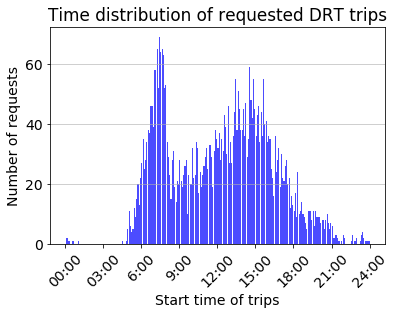

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=time_request, bins=np.arange(0,86400+1,86400/24/10), color='blue', alpha=0.7, rwidth=0.85, density=False)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Start time of trips')
plt.ylabel('Number of requests')
plt.title('Time distribution of requested DRT trips')

plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
ax.set_xticklabels(names_x,rotation=45)

# plt.xlim([6*60*60 , 9*60*60])
plt.show()